In [34]:
# General
import sys
import os
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/time_cells')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
import spike_preproc
import events_preproc

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
labelfontsize = 12
tickfontsize = 12
figfontsize = 14

In [3]:
def read_json(json_file):
    """Read the Goldmine json file.
    
    Stitches together broken lines and then
    checks that all lines are correctly formatted.
    
    Parameters
    ----------
    json_file : str
        Filepath to the json file
        
    Returns
    -------
    pandas.core.frame.DataFrame
        A DataFrame with len() == number of rows 
        in the json file
    """
    with open(json_file, 'r') as f_open:
        f_lines = [line.strip() for line in f_open.readlines()]

        # Stitch together broken lines
        f_lines_cleaned = []
        for iLine, line in enumerate(f_lines):
            if len(line) > 0:
                if (line[0]=='{'):
                    f_lines_cleaned.append(line)
                else:
                    f_lines_cleaned[-1] += line

        # Check that all lines are now correctly formatted
        assert np.all([((line[0]=='{') and (line[-1:]=='}')) for line in f_lines_cleaned])

        # Convert json list to a pandas DataFrame
        return pd.read_json('\n'.join([line for line in f_lines_cleaned]), lines=True)

def fill_column(df, key, key_, fill_back=False):
    """Create a column from the values in a df['value'][key_] 
    category for df['key']==key.
    
    if fill_back == True, then values are filled backwards from
    the indices where they occur. Otherwise values are filled
    forward from the indices where they occur.
    
    Returns
    -------
    newcol : list
        The new column values with len() == len(df)
    """
    df_ = df.loc[df['key']==key]
    if len(df_) == 0:
        return None
    
    inds = df_.index.tolist()
    vals = [row[key_] for row in df_['value']]
    
    for i in range(len(inds)+1):
        # Select the value that will be filled
        if i == 0:
            val = vals[i]
        elif fill_back: 
            if i == len(inds):
                val = vals[i - 1]
            else:
                val = vals[i]
        else:
            val = vals[i-1]
        
        # Fill the value over the appropriate
        # number of rows
        if i == 0:
            newcol = [val] * inds[i]
        elif i == len(inds):
            newcol += [val] * (len(df) - inds[i-1])
        else:
            newcol += [val] * (inds[i] - inds[i-1])
    
    return newcol

def get_trial_inds(df):
    """Figure out where each trial begins and ends based on gameState.

    Only complete trials are included.

    Returns
    -------
        trial_inds : itertools.OrderedDict
            (trial, [df_inds]) key/value pairs
    """
    inds = [idx for idx, row in df.query("(key=='gameState')").iterrows() 
            if row['value']['stateName'] in ['InitTrial', 'DoNextTrial']]
    df_ = df.loc[inds]
    trial_inds = od([])
    trial = 1
    iRow = 0
    while iRow < (len(df_)-1):
        if (df_.iloc[iRow]['gameState'] == 'InitTrial') and (df_.iloc[iRow+1]['gameState'] == 'DoNextTrial'):
            trial_inds[trial] = list(np.arange(df_.iloc[iRow].name, df_.iloc[iRow+1].name+1, dtype=int))
            trial += 1
            iRow += 2
        else:
            iRow += 1
    return trial_inds

def game_state_intervals(exp_df, game_state, cols=['time']):
    """Return trial-wise start and stop values for a game state.
    
    Values are determined by the column names in cols and are
    referenced against the index, with a trial period running
    from the first index of the trial to the first index of
    the next trial.
    
    Returns
    -------
    pandas.core.frame.DataFrame
    """
    def first_last(row):
        """Return first and last values in the col iterable."""
        vals = row.index.tolist()
        return [vals[0], vals[-1]+1] 
    
    # Format inputs correctly.
    if type(cols) == str:
        cols = [cols]
    
    # Ensure that all indices are consecutive (i.e. we are not accidentally
    # including another gameState in between values for the desired gameState)
    assert np.all([np.all(np.diff(x)==1) 
                   for x in exp_df.query("(gameState=='{}')".format(game_state))
                   .groupby('trial').indices.values()])

    # Group by trial and get the first and last indices for the gameState.
    output_df = (exp_df.query("(gameState=='{}')".format(game_state))
                       .groupby('trial')
                       .apply(lambda x: first_last(x))
                       .reset_index()
                       .rename(columns={0:'index'}))
    
    # Apply the indices to each column that we want to grab values for.
    for col in cols:
        output_df[col] = output_df['index'].apply(lambda x: [exp_df.loc[x[0], col], 
                                                             exp_df.loc[x[1], col]])
    
    return output_df

def rmse(v1, v2):
    """Return the root mean squared error
    between equal-length vectors v1 and v2.
    """
    err = v1 - v2
    return np.sqrt(np.dot(err, err)/len(err))

def find_pulse_starts(sync_chan, 
                      pulse_thresh=200, # voltage change
                      sampling_rate=32000, # Hz
                      interpulse_thresh_ms=100,
                      intrapulse_thresh_ms=50
                     ): 
    """Return sync_chan indices that mark that start of each sync pulse.
    
    Note: the default arguments were defined on data that were sampled
    at 2000 Hz and might need to be adjusted if the sampling rate
    differs much from this.
    
    Algorithm
    ---------
    1) Identifies sync pulse periods by finding sync channel indices
       for which the absolute value of the trace derivative exceeds
       pulse_thresh. 
    2) Identifies the start of each sync pulse by finding suprathreshold
       sync pulse indices for which the inter-pulse interval exceeds
       interpulse_thresh, and for which the subsequent suprathreshold 
       sync pulse occurs within a certain number of indices, defined by
       intrapulse_thresh. In other words, we are looking for dramatic
       changes in voltage that occur some time after the last dramatic
       voltage change, and that are sustained for some period of time.
    
    Parameters
    ----------
    sync_chan : numpy.ndarray
        Voltage trace from the channel that
        the sync box was plugged into
    pulse_thresh : int or float
        See algorithm description
    sampling_rate : int or float
        Sampling rate of the LFP sync channel in Hz
    interpulse_thresh_ms : int or float
        See algorithm description
    intrapulse_thresh_ms : int or float
        See algorithm description
    
    Returns
    -------
    pulse_startinds : numpy.ndarray
        Array of indices that mark the start of each sync pulse.
    """
    # Find sync pulses by looking for suprathreshold changes 
    # in the absolute value of the derivative of the sync channel
    sync_pulses = np.abs(np.pad(np.diff(sync_chan), (1, 0), 'constant'))>pulse_thresh
    pulse_inds = np.where(sync_pulses)[0]

    # Find the inter-pulse intervals
    ipis = np.insert(np.diff(pulse_inds), 0, pulse_inds[0])

    # Identify the start of each pulse by finding suprathreshold
    # inter-pulse intervals that are followed by a short IPI.
    interpulse_thresh = interpulse_thresh_ms * (sampling_rate / 1000)
    intrapulse_thresh = intrapulse_thresh_ms * (sampling_rate / 1000)
    pulse_startinds = pulse_inds[[i for i in range(len(ipis)-1) 
                                  if ((ipis[i]>interpulse_thresh) 
                                      & (ipis[i+1]<intrapulse_thresh))]]
    return pulse_startinds

def align_sync_pulses(event_synctimes, # vector of event sync times
                      lfp_synctimes, # vector of LFP sync times in ms
                      sampling_rate=32000, # Hz
                     ):
    """Return the slope and intercept to align event to LFP times.
    
    Algorithm
    ---------
    1) Subtracts the first sync time from all sync times, so
       both vectors start at 0.
    2) Finds the best fit between event and LFP sync times
       by comparing their inter-pulse intervals at 30 offset
       steps for the LFP sync times. An exception is raised if
       a good fit is not found.
    3) Finds the closest LFP sync time to each event sync time.
    4) Estimates the intercept and slope to align event to
       LFP sync times using robust linear regression.
       
    Parameters
    ----------
    event_synctimes : numpy.ndarray
        Vector of event sync times
    lfp_synctimes : numpy.ndarray
        Vector of LFP sync times
    sampling_rate : int or float
        Sampling rate of the LFP sync channel in Hz
        
    Returns
    -------
    sync_params : collections.OrderedDict
        Intercept and slope to align
        event timestamps to LFP timestamps
    before_stats : collections.OrderedDict
        Pearson correlation and RMSE (in ms) between
        event and LFP sync times before alignment.
    after_stats : collections.OrderedDict
        Pearson correlation and RMSE (in ms) between
        event and LFP sync times after alignment.
    """
    def rmse(v1, v2):
        """Return the root mean squared error
        between equal-length vectors v1 and v2.
        """
        err = v1 - v2
        return np.sqrt(np.dot(err, err)/len(err))
        
    def error_percentiles(v1, v2):
        err = np.abs(v1 - v2)
        pcts = [0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100]
        return pd.Series([np.percentile(err, pct) for pct in pcts], index=pcts)
    
    # Find the best starting fit between event and LFP sync times
    # by comparing the inter-pulse intervals for each, testing
    # LFP sync shifts at different rolling indices.
    min_syncs = np.min((len(event_synctimes), len(lfp_synctimes)))
    offsets = np.arange(-(min_syncs-2), (min_syncs-2))
    rvals = []
    lfp_synctimes_diff = np.diff(lfp_synctimes[:min_syncs])
    event_synctimes_diff = np.diff(event_synctimes[:min_syncs])
    for offset in offsets:
        rvals.append(stats.pearsonr(np.roll(lfp_synctimes_diff, offset), event_synctimes_diff)[0])
    shift_by = offsets[np.argmax(rvals)]
    lfp_synctimes_ = np.roll(lfp_synctimes[:min_syncs], shift_by)
    print('Shift by {}; Best r = {:.3f}'.format(shift_by, np.max(rvals)))
    
    # Make the first pulse start at time 0.
#     event_synctimes_ = np.copy(event_synctimes - event_synctimes[0])
#     lfp_synctimes_ = np.copy(lfp_synctimes - lfp_synctimes[0])
    event_synctimes_ = np.copy(event_synctimes)
    lfp_synctimes_ = np.copy(lfp_synctimes)
    
    # For each event sync time, find the closest LFP sync time.
    if (len(event_synctimes_) == len(lfp_synctimes_)) & (shift_by==0):
        sync_pairs = np.array([(event_synctimes_[i], 
                                lfp_synctimes_[i])
                               for i in range(len(event_synctimes_))])
    else:
        sync_pairs = np.array([(event_synctimes_[i], 
                                lfp_synctimes_[np.abs(lfp_synctimes_ - event_synctimes_[i])
                                               .argmin()])
                               for i in range(len(event_synctimes_))])

    # Get a robust linear fit between the event/LFP sync pairs.
    X = sm.add_constant(sync_pairs[:, 0]) # the event sync times
    y = sync_pairs[:, 1] # the LFP channel sync times
    rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
    rlm_results = rlm_model.fit()
    intercept, slope = rlm_results.params
    
    # Add back the difference in starting times.
#     intercept += (lfp_synctimes[0] - event_synctimes[0])
    print('Intercept: {}; Slope: {}'.format(intercept, slope))
    
    # See how well the alignment went.
    sync_params = od([('intercept', intercept), ('slope', slope)])
    event_synctimes_aligned = intercept + (slope * event_synctimes_)
    before_stats = od([('r', stats.pearsonr(event_synctimes_[:min_syncs], lfp_synctimes_[:min_syncs])[0]),
                       ('rmse', rmse(event_synctimes_[:min_syncs], lfp_synctimes_[:min_syncs])),
                       ('err_pcts', error_percentiles(event_synctimes_[:min_syncs], lfp_synctimes_[:min_syncs]))])
    after_stats = od([('r', stats.pearsonr(event_synctimes_aligned[:min_syncs], lfp_synctimes_[:min_syncs])[0]),
                      ('rmse', rmse(event_synctimes_aligned[:min_syncs], lfp_synctimes_[:min_syncs])),
                      ('err_pcts', error_percentiles(event_synctimes_aligned[:min_syncs], lfp_synctimes_[:min_syncs]))])
    return offsets, rvals, shift_by, sync_params, before_stats, after_stats

def shift_spike_inds(spike_inds, step, floor=0, ceiling=np.inf):
    """Return the time-shifted spike_inds array.
    
    Parameters
    ----------
    spike_inds : np.ndarray
        Array of spike time indices.
    floor : int
        The lowest spike index before rolling backward from stop.
    ceiling : int
        One above highest spike index before rolling forward from start.
    step : int
        Number of indices to shift the spike train by.
    """
    ceiling -= floor
    spike_inds_shifted = (spike_inds-floor) + step
    
    if step < 0:
        roll_by = -len(spike_inds_shifted[spike_inds_shifted<0])
        spike_inds_shifted[spike_inds_shifted<0] = spike_inds_shifted[spike_inds_shifted<0] + ceiling
    else:
        roll_by = len(spike_inds_shifted[spike_inds_shifted>=ceiling])
        spike_inds_shifted[spike_inds_shifted>=ceiling] = spike_inds_shifted[spike_inds_shifted>=ceiling] - ceiling

    spike_inds_shifted = np.roll(spike_inds_shifted, roll_by) + floor

    return spike_inds_shifted

## Preprocess spikes

In [30]:
reload(spike_preproc)

<module 'spike_preproc' from '/home1/dscho/code/projects/time_cells/spike_preproc.py'>

In [36]:
subj_sess = 'U521_ses0'

In [38]:
proj_dir = '/home1/dscho/projects/time_cells'
events = dio.open_pickle(os.path.join(proj_dir, 'analysis', 'events', '{}-events_formatted.pkl'.format(subj_sess)))
events['time'] = events['time'].apply(lambda x: np.int(np.round(x, 0)))
events.shape

(98962, 8)

In [32]:
# Process and format wave_clus outputs into spike files for each neuron.
start_time = time()

spikes = spike_preproc.format_spikes(subj_sess,
                                     add_montage_info=True,
                                     calc_fr=False,
                                     sigma=500,
                                     spikes_dirname='wave_clus3_sortbyhand',
                                     overwrite=True,
                                     save_output=True,
                                     split_files=True)

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 15.11 secs


In [52]:
times = events_preproc.game_state_intervals(events, 'Delay1')
times.head()

trial           index                time
0      1        [14, 29]  [1453927, 1463944]
1      2    [3119, 3134]  [1577174, 1587175]
2      3    [6308, 6323]  [1702673, 1712690]
3      4    [8733, 8748]  [1804654, 1814671]
4      5  [11540, 11554]  [1918969, 1928970]

In [7]:
spikes.groupby('hemroi').agg({'chan': len, 'unit': np.sum, 'fr': np.mean})

chan  unit         fr
hemroi                       
LAI        6     7   4.632157
LMH        1     1   1.612766
LPHG      16    29   3.930012
LTO        5    11  11.725491
RMH        2     2   2.450754

## Perform ses0 alignment

In [62]:
subj_sess = 'U521_ses0'
data_dir = '/scratch/dscho/time_cells/data'
analysis_dir = '/scratch/dscho/time_cells/analysis'
sampling_rate = 30000

# --------------------------------------

# Get subject directories.
subj, sess = subj_sess.split('_')
subj_dir = os.path.join(data_dir, subj, sess)
events_dir = os.path.join(subj_dir, 'events')
# spikes_dir = os.path.join(subj_dir, 'spikes', 'wave_clus3_autosort')
spikes_dir = os.path.join(subj_dir, 'spikes', 'wave_clus3_sortbyhand')
macros_dir = os.path.join(subj_dir, 'macro_lfps')
micros_dir = os.path.join(subj_dir, 'micro_lfps')
sync_dir = os.path.join(subj_dir, 'sync')
sr = sampling_rate

In [ ]:
shift_by = -14
start = 4700
stop = 5400
align_sync_pulses(event_synctimes[:min_syncs][start:stop],
                  np.roll(lfp_synctimes[:min_syncs], shift_by)[start:stop])

In [118]:
shift_by = -14

# Align events to LFP.
sync_params, before_stats, after_stats = align_sync_pulses(event_synctimes[:min_syncs][start:stop], 
                                                           np.roll(lfp_synctimes[:min_syncs], shift_by)[start:stop], 
                                                           good_fit_thresh_ms=None)

# Define the intercept as the difference between the first LFP sync time 
# and the first events sync time that we are aligning
intercept = np.roll(lfp_synctimes[:min_syncs], shift_by)[start:stop][0] - event_synctimes[:min_syncs][start:stop][0]

# Apply the alignment to all event times.
# events['time_aligned'] = events['time'].apply(lambda x: 0 + (sync_params['slope'] * x))
events['time'] = events['time'].apply(lambda x: 112766.5349958418 + (sync_params['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes)))
print('\n--------------------\nAlignment parameters\n--------------------')
print('Intercept: {}\nSlope: {}'.format(sync_params['intercept'], sync_params['slope']))
print('Before alignment r={:.4f}, RMSE={:.4f} ms,\n|Error| percentiles:\n{}'
      .format(before_stats['r'], before_stats['rmse'], before_stats['err_pcts']))
print('After alignment r={:.4f}, RMSE={:.4f} ms,\n|Error| percentiles:\n{}'
      .format(after_stats['r'], after_stats['rmse'], after_stats['err_pcts']))
print(rmse(events.loc[events.key=='syncPulse', 'time'][:min_syncs][start:stop], lfp_synctimes[:min_syncs][start:stop]))
print(stats.pearsonr(np.diff(events.loc[events.key=='syncPulse', 'time'][:min_syncs][start:stop]), 
                     np.diff(lfp_synctimes[:min_syncs][-shift_by+start:-shift_by+stop])))
print(rmse(events.loc[events.key=='syncPulse', 'time'][:min_syncs][start:stop], lfp_synctimes[:min_syncs][-shift_by+start:-shift_by+stop]))
print(rmse(events.loc[events.key=='syncPulse', 'time'][-shift_by:-shift_by+min_syncs][start:stop], 
           lfp_synctimes[-shift_by:-shift_by+min_syncs][-shift_by+start:-shift_by+stop]))

In [162]:
event_synctimes, lfp_synctimes, lfp_synctimes[:10] - event_synctimes[:10]

(array([1.35606982e+03, 2.37656006e+03, 3.35800000e+03, ...,
        5.96180501e+06, 5.96275772e+06, 5.96359029e+06]),
 array([  33315.46666667,   34236.06666667,   35206.6       , ...,
        5993894.56666667, 5994746.83333333, 5995748.46666667]),
 array([31959.39684245, 31859.50660807, 31848.6       , 31889.52011719,
        31851.74008789, 31932.60660807, 31762.46350911, 31922.62327474,
        31834.73994141, 31861.96336263]))

In [167]:
sync_pairs = align_sync_pulses(event_synctimes, lfp_synctimes)

Shift by -14; Best r = 0.139


In [182]:
slp, icpt, *_ = stats.linregress(sync_pairs[:, 0], sync_pairs[:, 1])
slp, icpt, _

(0.9999072276631373,
 358.3626015195623,
 [0.9999996727994759, 0.0, 1.047752431820586e-05])

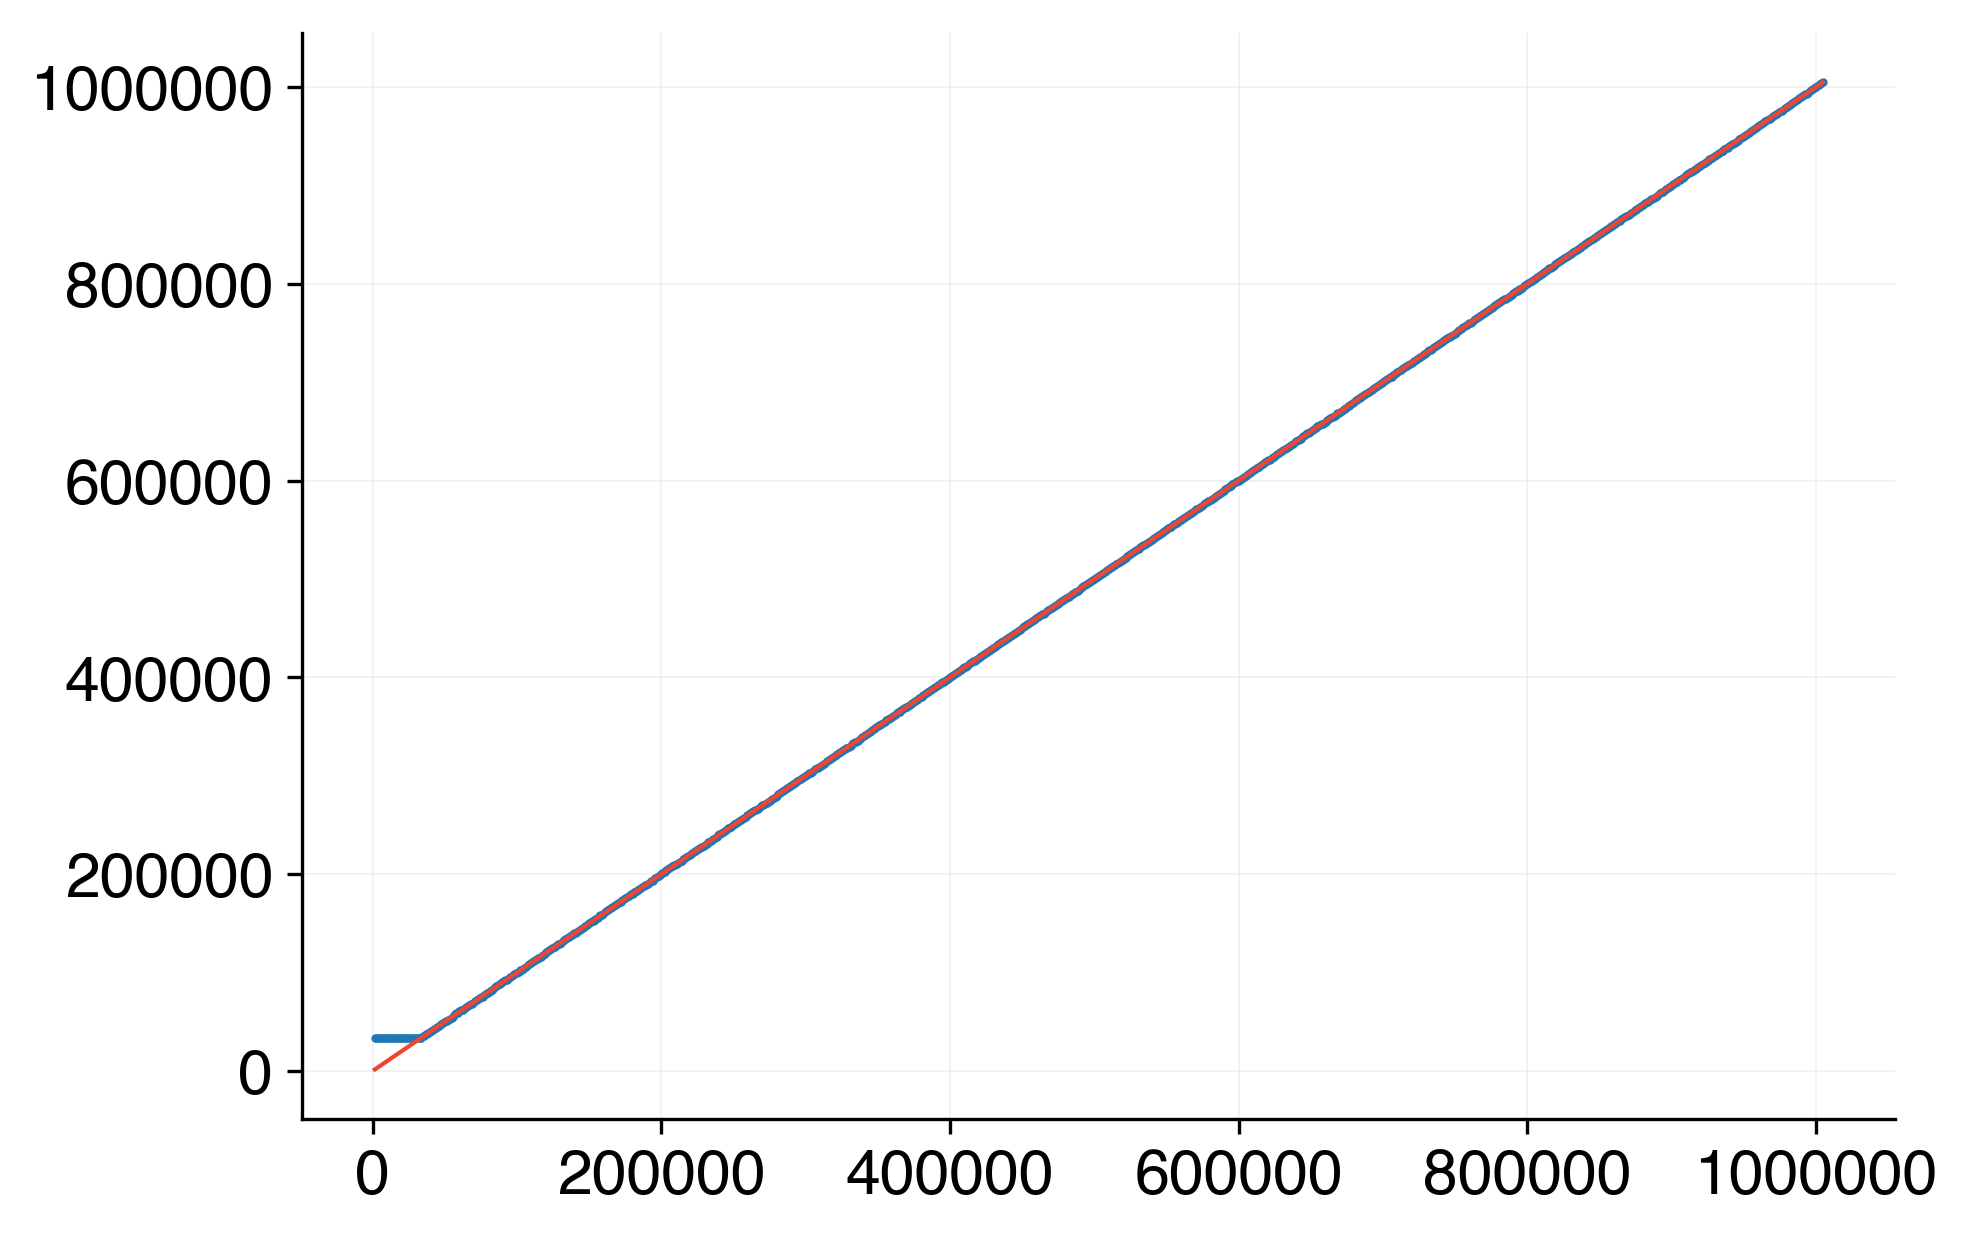

In [194]:
start = 0
stop = 1000
plt.scatter(sync_pairs[:, 0][start:stop], sync_pairs[:, 1][start:stop], s=1)
plt.plot(sync_pairs[:, 0][start:stop], sync_params['intercept'] + (sync_pairs[:, 0][start:stop] * slp), color=colors[1])

In [320]:
# Get event timestamps in ms.
events = read_json(os.path.join(events_dir, 'events.jsonl'))
events = events[['time', 'type', 'data']].rename(columns={'type': 'key', 'data': 'value'})
events['time'] = (events['time'] - events.at[0, 'time'])
events.insert(0, 'subj_sess', subj_sess)
event_synctimes = events.loc[events.key=='syncPulse', 'time'].values
print('{} events recorded over {} min and {} sec'.format(len(events), int(events.iloc[-1]['time']/60000), int((events.iloc[-1]['time']%60000)/1000)))

# Get LFP timestamps, convert sec to ms,
# and subtract the first timestamp from all timestamps
try:
    lfp_timestamps = np.squeeze(sio.loadmat(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'))['timeStamps'])
except NotImplementedError:
    with h5py.File(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'), 'r') as f:
        lfp_timestamps = np.squeeze(f['timeStamps'])
lfp_timestamps = lfp_timestamps * 1e3
#lfp_timestamps = lfp_timestamps - lfp_timestamps[0]
session_length = (lfp_timestamps[-1] - lfp_timestamps[0]) * 1e-3 # in sec
print('session length is {} min and {} sec'.format(int(session_length/60), int(session_length%60)))

# Load the sync channel data (sampled at 30000 Hz for U515_ses0)
# and convert the analog signal into sync start indices.
try:
    sync_chan = np.squeeze(sio.loadmat(os.path.join(sync_dir, 'sync_channel_micro.mat'))['data'])
except NotImplementedError:
    with h5py.File(os.path.join(sync_dir, 'sync_channel_micro.mat'), 'r') as f:
        sync_chan = np.squeeze(f['data'])
print('{} lfp timestamps and {} sync channel datapoints (should be equal)'.format(len(lfp_timestamps), len(sync_chan)))
pulse_startinds = find_pulse_starts(sync_chan)
print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

# Get the LFP time in ms for each sync pulse event.
lfp_synctimes = lfp_timestamps[pulse_startinds]
      
# Align events to LFP.
# offsets, r_vals, shift_by, sync_params, before_stats, after_stats = align_sync_pulses(event_synctimes, lfp_synctimes)
shift_by = -14
start = 4700
stop = 5400
# shift_by = 0
# start = 0
# stop = 60
offsets, r_vals, shift_by, sync_params, before_stats, after_stats = align_sync_pulses(event_synctimes[start:stop],
                                                                                      np.roll(lfp_synctimes, shift_by)[start:stop])

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: sync_params['intercept'] + (sync_params['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes)))
print('\n--------------------\nAlignment parameters\n--------------------')
print('Intercept: {}\nSlope: {}'.format(sync_params['intercept'], sync_params['slope']))
print('Before alignment r={:.4f}, RMSE={:.4f} ms,\n|Error| percentiles:\n{}'
      .format(before_stats['r'], before_stats['rmse'], before_stats['err_pcts']))
print('After alignment r={:.4f}, RMSE={:.4f} ms,\n|Error| percentiles:\n{}'
      .format(after_stats['r'], after_stats['rmse'], after_stats['err_pcts']))

123620 events recorded over 99 min and 24 sec
session length is 99 min and 55 sec
179877325 lfp timestamps and 179877325 sync channel datapoints (should be equal)
Detected 5933 syncs for 5962 sync pulse events
Shift by 0; Best r = 1.000
Intercept: 69165.30542636616; Slope: 1.0000147639399801
5962 event sync pulses
5933 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
Intercept: 69165.30542636616
Slope: 1.0000147639399801
Before alignment r=1.0000, RMSE=69239.8875 ms,
|Error| percentiles:
0      69234.486637
1      69234.916811
5      69235.315333
10     69235.788475
25     69237.322522
50     69239.866813
75     69242.459196
90     69243.986973
95     69244.557967
99     69244.963545
100    69245.166813
dtype: float64
After alignment r=1.0000, RMSE=0.1543 ms,
|Error| percentiles:
0      0.000117
1      0.004244
5      0.019080
10     0.035776
25     0.068650
50     0.124551
75     0.175494
90     0.237236
95     0.276634
99     0.369755
100    

In [322]:
start, stop

(4700, 5400)

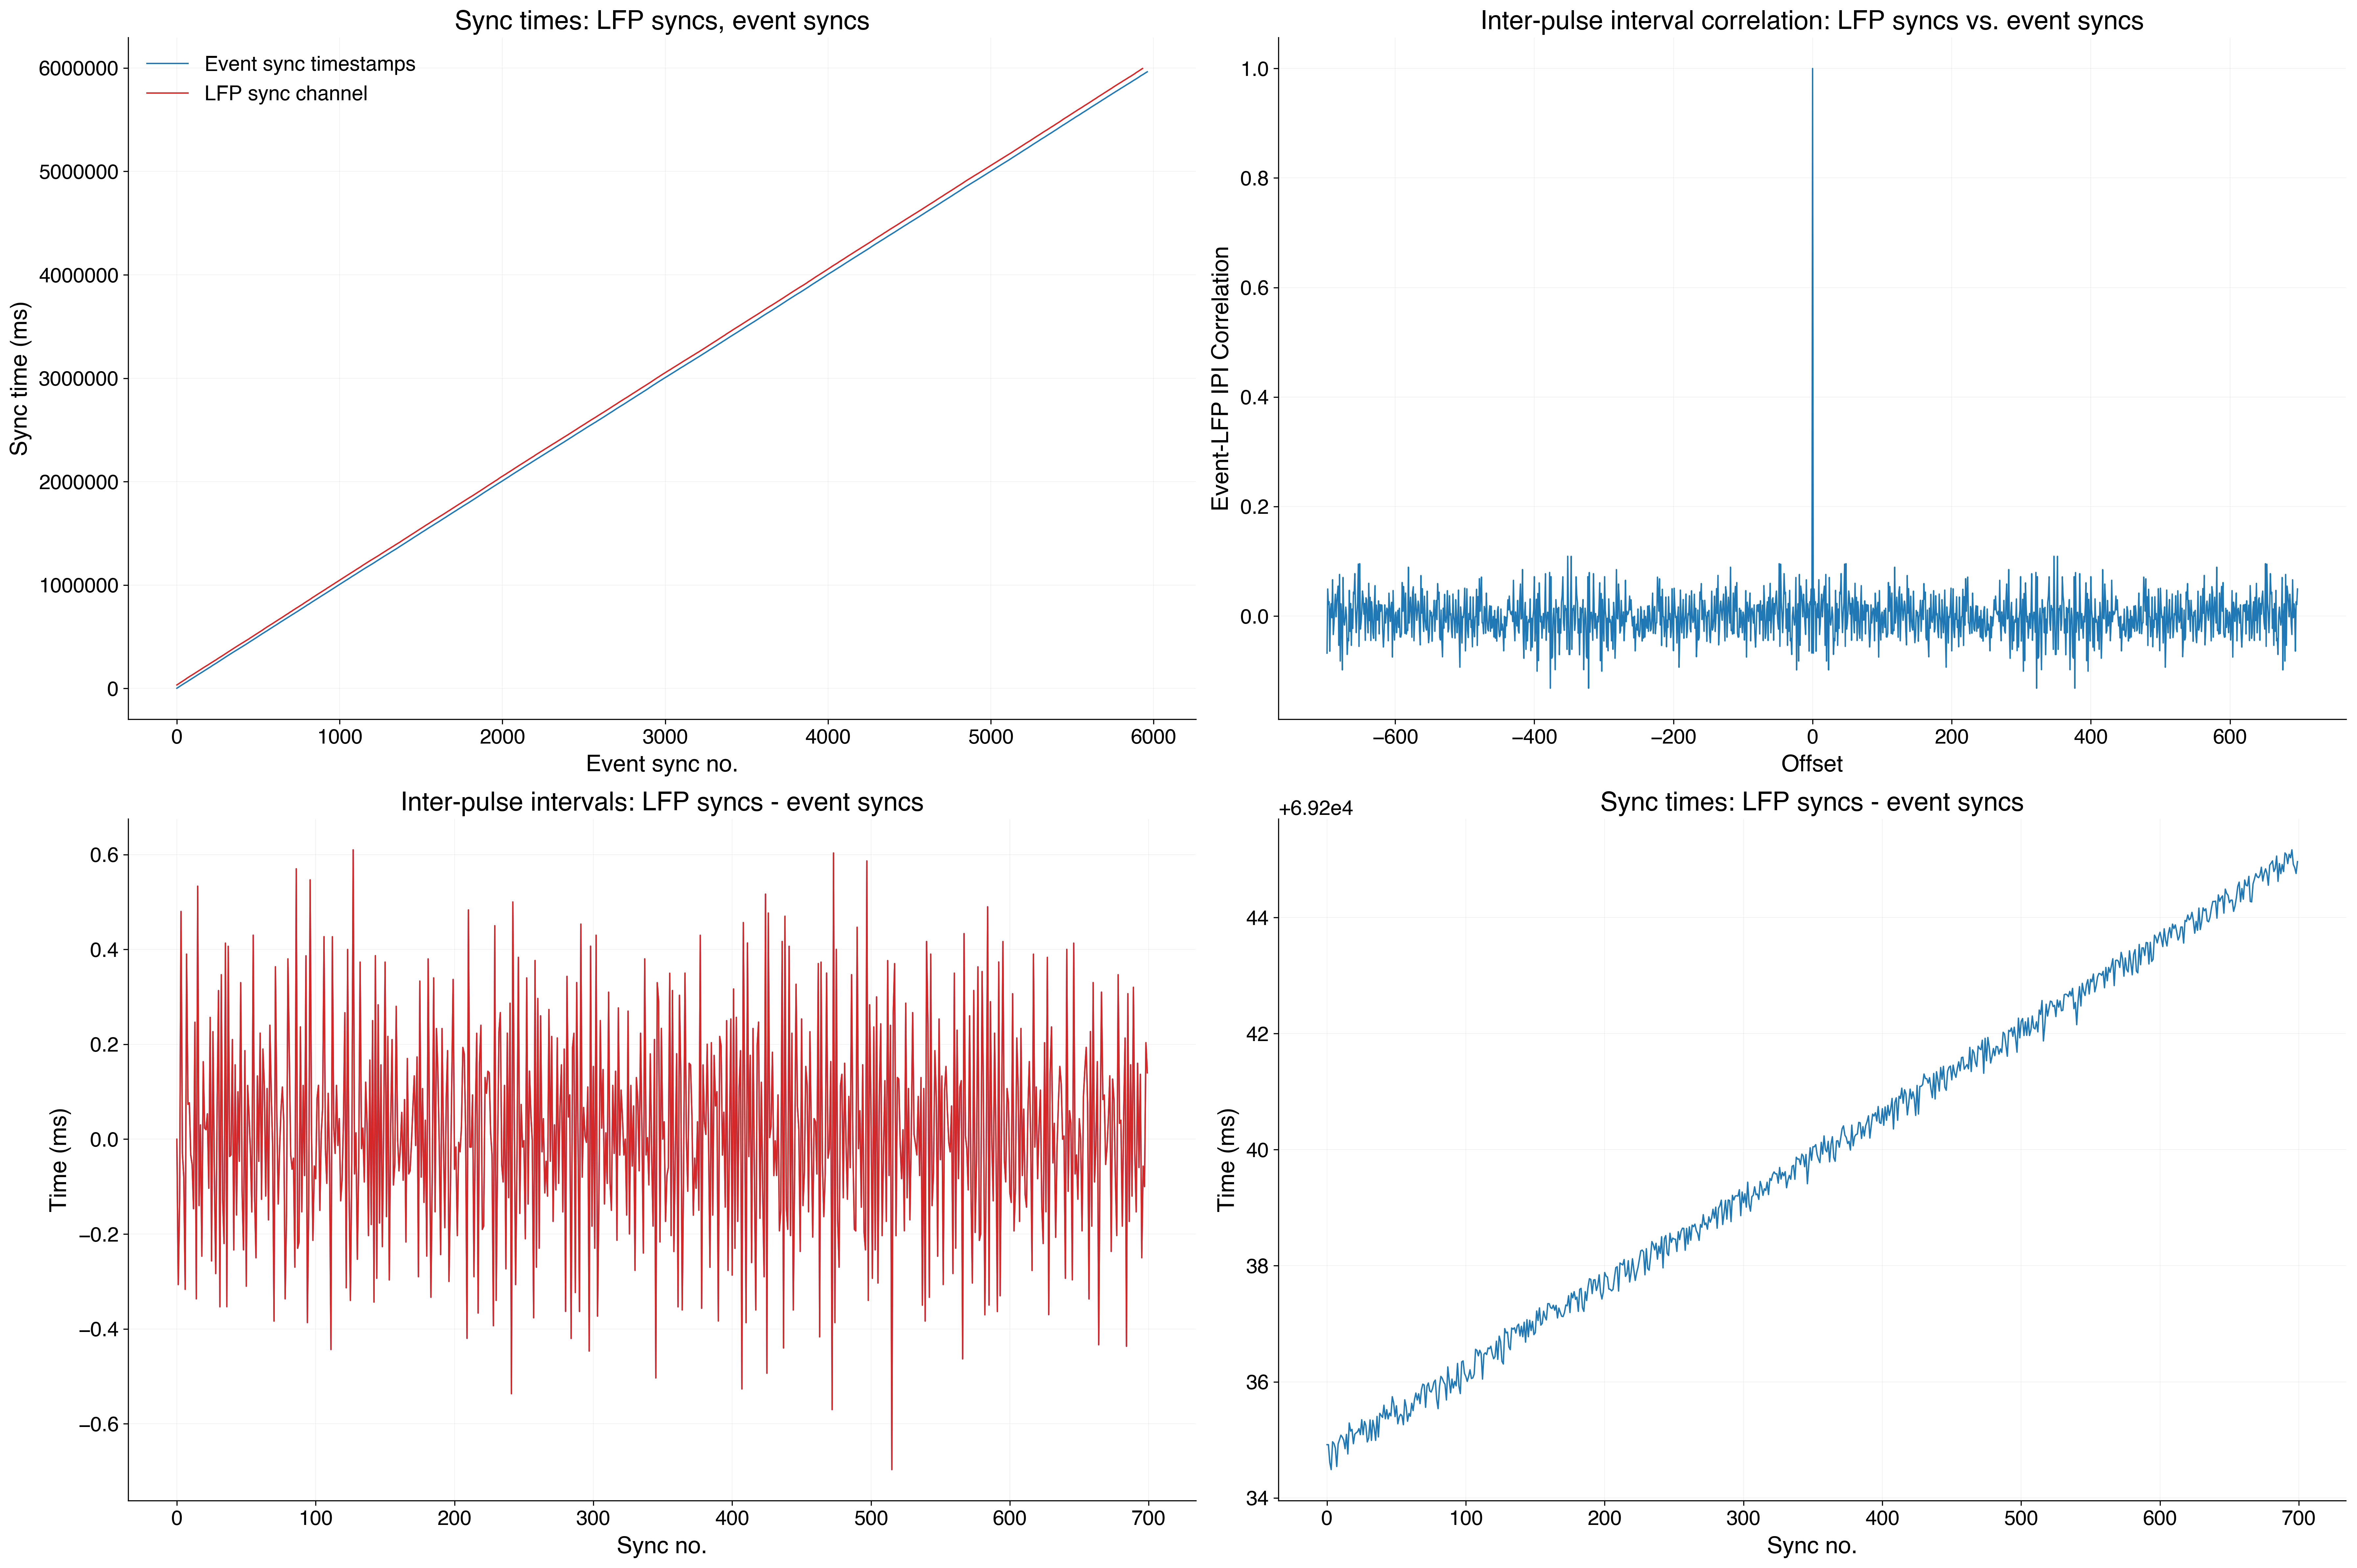

In [324]:
fig, ax = plt.subplots(2, 2, figsize=(24, 16), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i].plot(np.arange(len(event_synctimes)), event_synctimes, color='C0', label='Event sync timestamps')
ax[i].plot(np.arange(len(lfp_synctimes)), lfp_synctimes, color='C1', label='LFP sync channel')
ax[i].set_xlabel('Event sync no.', labelpad=5)
ax[i].set_ylabel('Sync time (ms)', labelpad=5)
ax[i].legend(loc=2)
ax[i].set_title('Sync times: LFP syncs, event syncs')

i = 1
ax[i].plot(offsets, r_vals)
ax[i].set_xlabel('Offset', labelpad=5)
ax[i].set_ylabel('Event-LFP IPI Correlation', labelpad=5)
ax[i].set_title('Inter-pulse interval correlation: LFP syncs vs. event syncs')

i = 2
shift_by_ = -14
ax[i].plot(np.roll(np.diff(lfp_synctimes), shift_by_)[start:stop] - np.diff(event_synctimes)[start:stop])
ax[i].plot(np.roll(np.diff(lfp_synctimes), shift_by_)[start:stop] - np.diff(event_synctimes)[start:stop])
ax[i].set_xlabel('Sync no.', labelpad=5)
ax[i].set_ylabel('Time (ms)', labelpad=5)
ax[i].set_title('Inter-pulse intervals: LFP syncs - event syncs')

i = 3
ax[i].plot(np.roll(lfp_synctimes, shift_by_)[start:stop] - event_synctimes[start:stop])
ax[i].set_xlabel('Sync no.', labelpad=5)
ax[i].set_ylabel('Time (ms)', labelpad=5)
ax[i].set_title('Sync times: LFP syncs - event syncs')

fig.tight_layout()

In [136]:
import eeg_plotting
reload(eeg_plotting)
from eeg_plotting import plot_trace, plot_trace2

In [90]:
len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])

(5933, 5962)

In [235]:
lfp_timestamps[-1]*30

179877324.00000003

In [279]:
lfp_synctimes, lfp_timestamps, pulse_startinds

(array([  33315.46666667,   34236.06666667,   35206.6       , ...,
        5993894.56666667, 5994746.83333333, 5995748.46666667]),
 array([0.00000000e+00, 3.33333333e-02, 6.66666667e-02, ...,
        5.99591073e+06, 5.99591077e+06, 5.99591080e+06]),
 array([   999464,   1027082,   1056198, ..., 179816837, 179842405,
        179872454]))

In [306]:
sync_params
(event_synctimes*30).astype(np.int64), len(lfp_timestamps)

(array([   999464,   1030078,   1059521, ..., 179812932, 179841513,
        179866490]), 179877325)

In [327]:
np.array([x for x in (event_synctimes*30).astype(np.int64) if (x<len(lfp_timestamps))])

array([  2115641,   2146257,   2175700, ..., 179816843, 179842413,
       179872458])

In [333]:
(event_pulse_inds/30)/1000

array([  70.52136667,   71.5419    ,   72.52333333, ..., 5993.89476667,
       5994.7471    , 5995.7486    ])

In [330]:
pulse_startinds_train = np.zeros(len(sync_chan))
pulse_startinds_train[pulse_startinds] = 1

# Get event timestamps in ms.
# events = read_json(os.path.join(events_dir, 'events.jsonl'))
# events = events[['time', 'type', 'data']].rename(columns={'type': 'key', 'data': 'value'})
# events['time'] = (events['time'] - events.at[0, 'time'])
# events.insert(0, 'subj_sess', subj_sess)

# icpt2 = lfp_timestamps[pulse_startinds[0]] - events.loc[events.key=='syncPulse', 'time'].values[0]
# print(icpt2)
event_synctimes = events.loc[events.key=='syncPulse', 'time'].values# + icpt2
event_pulse_inds = np.array([x for x in (event_synctimes*30).astype(np.int64) if (x<len(lfp_timestamps))])
event_pulse_startinds_train = np.zeros(len(sync_chan))
event_pulse_startinds_train[event_pulse_inds] = 1

In [269]:
len(sync_chan), events.loc[events.key=='syncPulse', 'time'].values[-1]*30

(179877325, 180985309.2466361)

In [289]:
pulse_startinds_train = np.zeros(len(sync_chan))
pulse_startinds_train[pulse_startinds[:5]] = 1

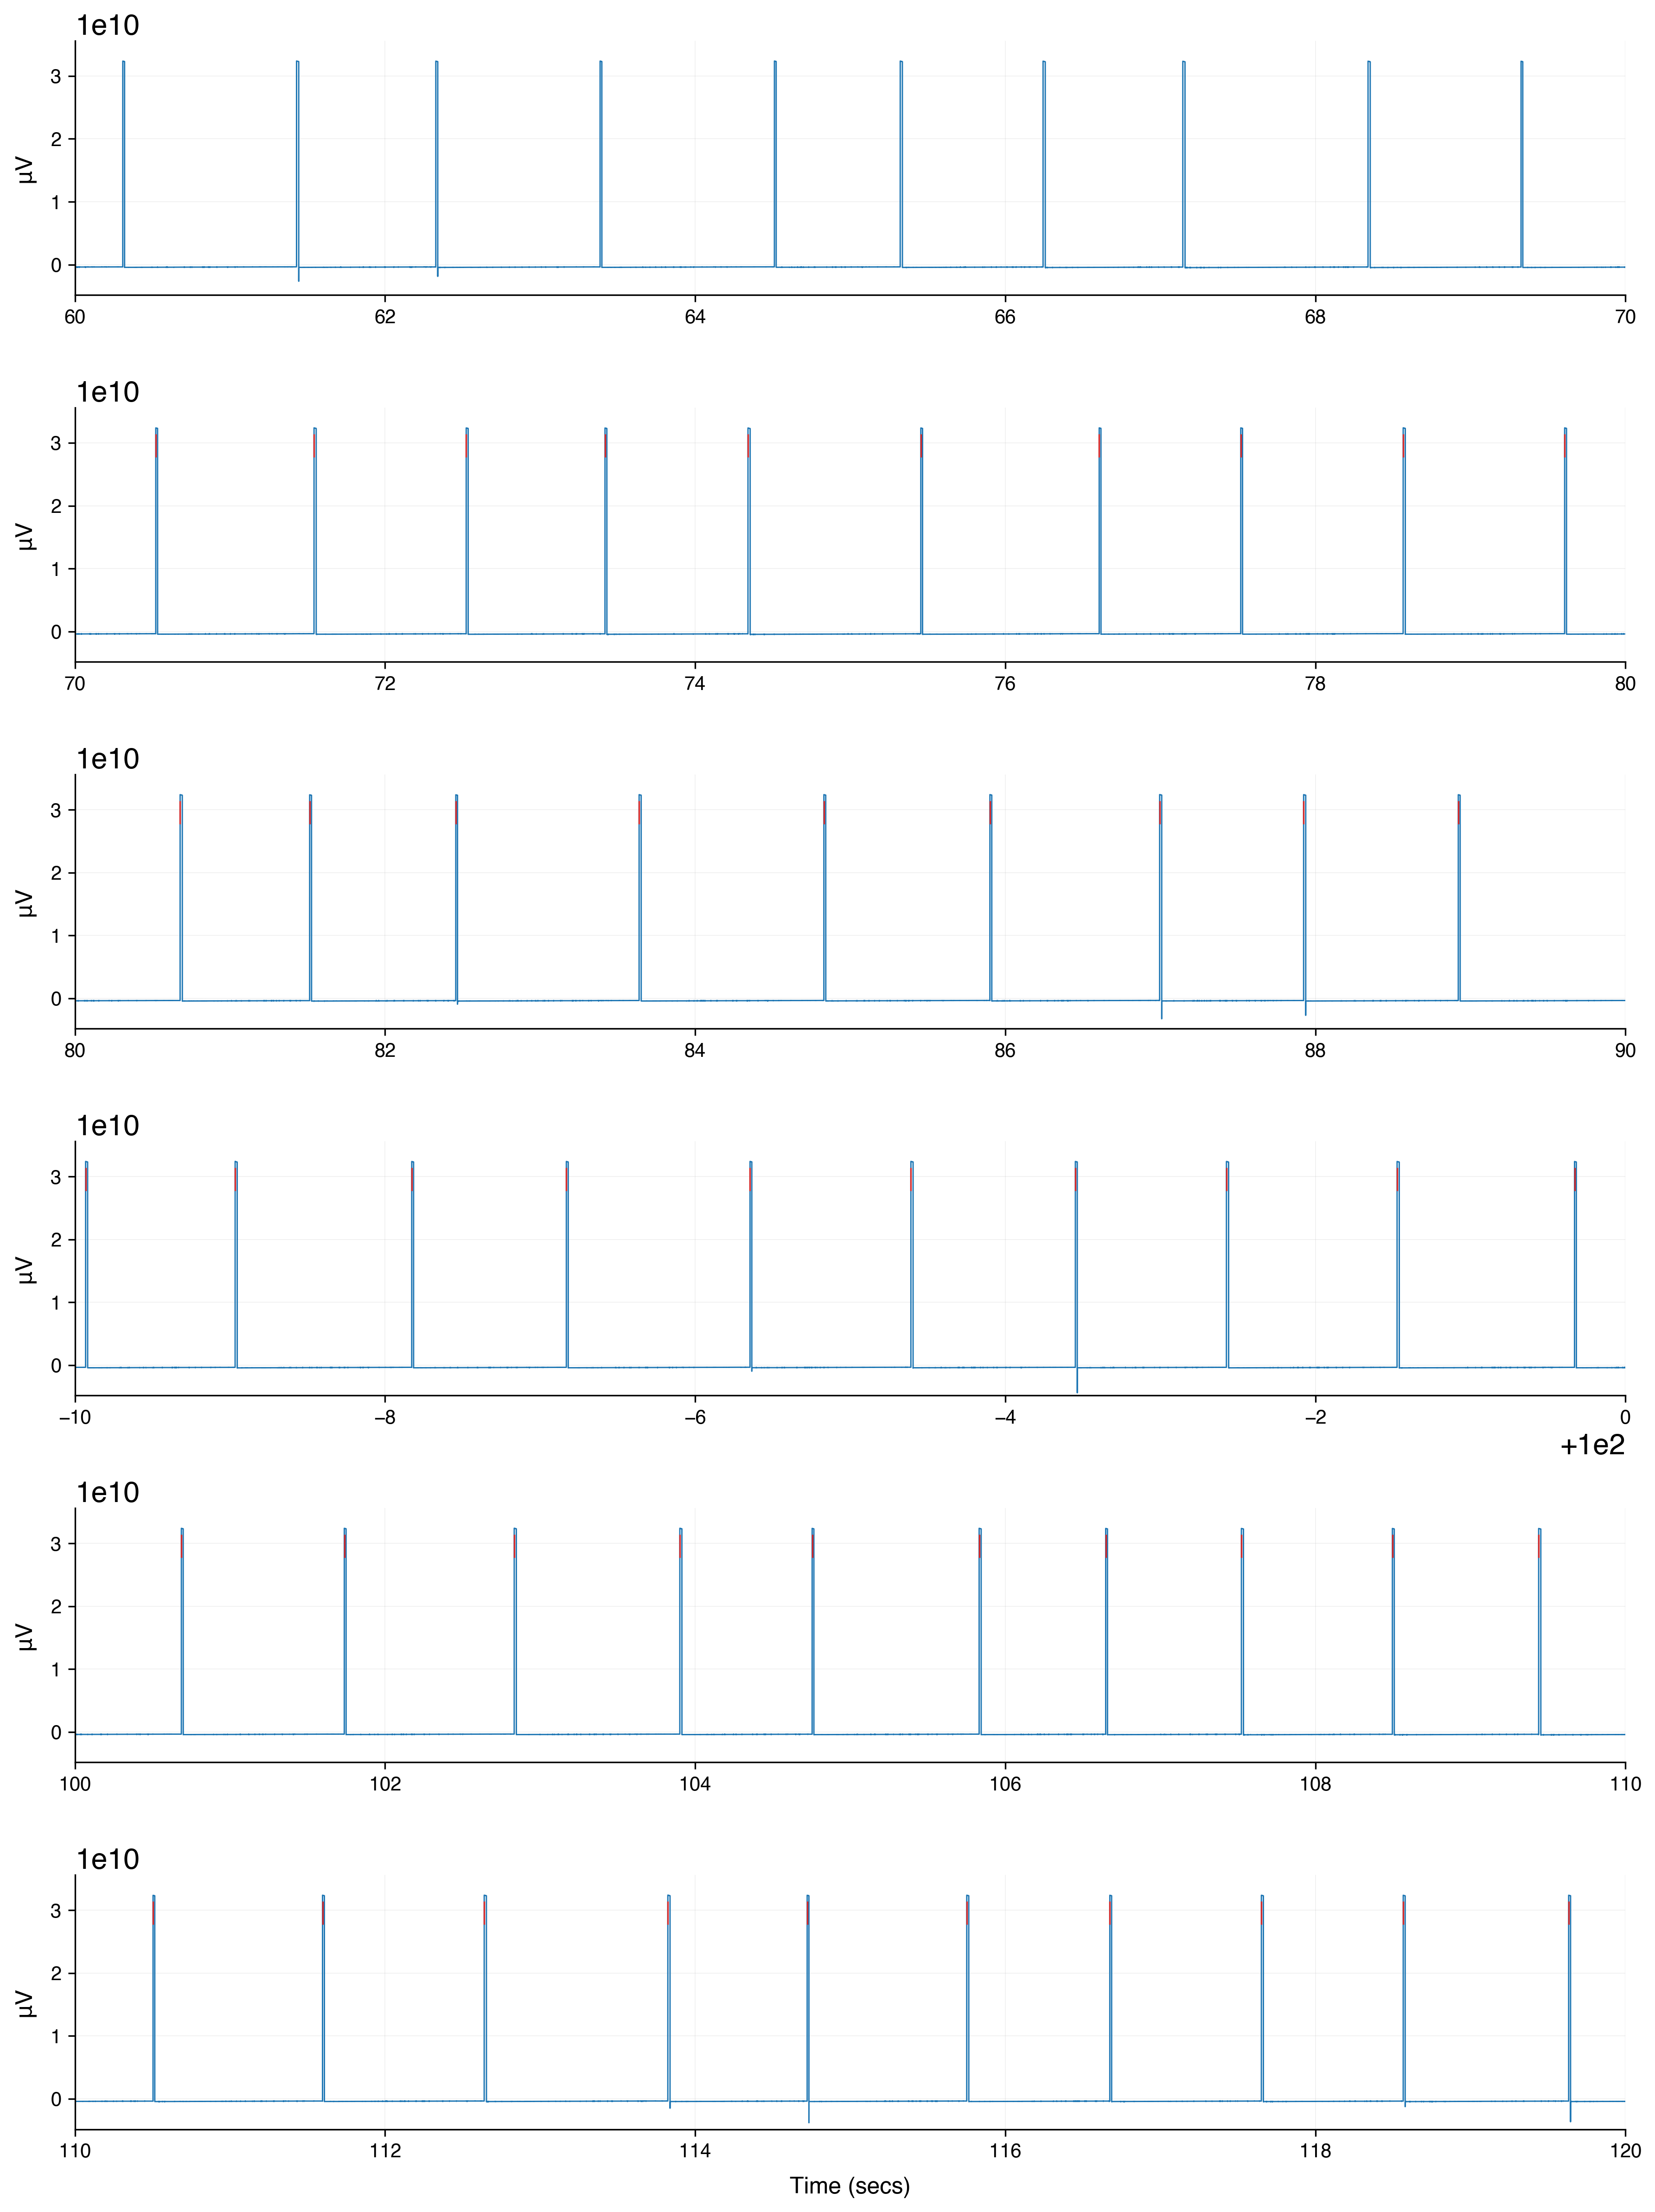

In [334]:
fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                      start=60, duration=60, nwin=6, x_units='secs', sampling_rate=30000)

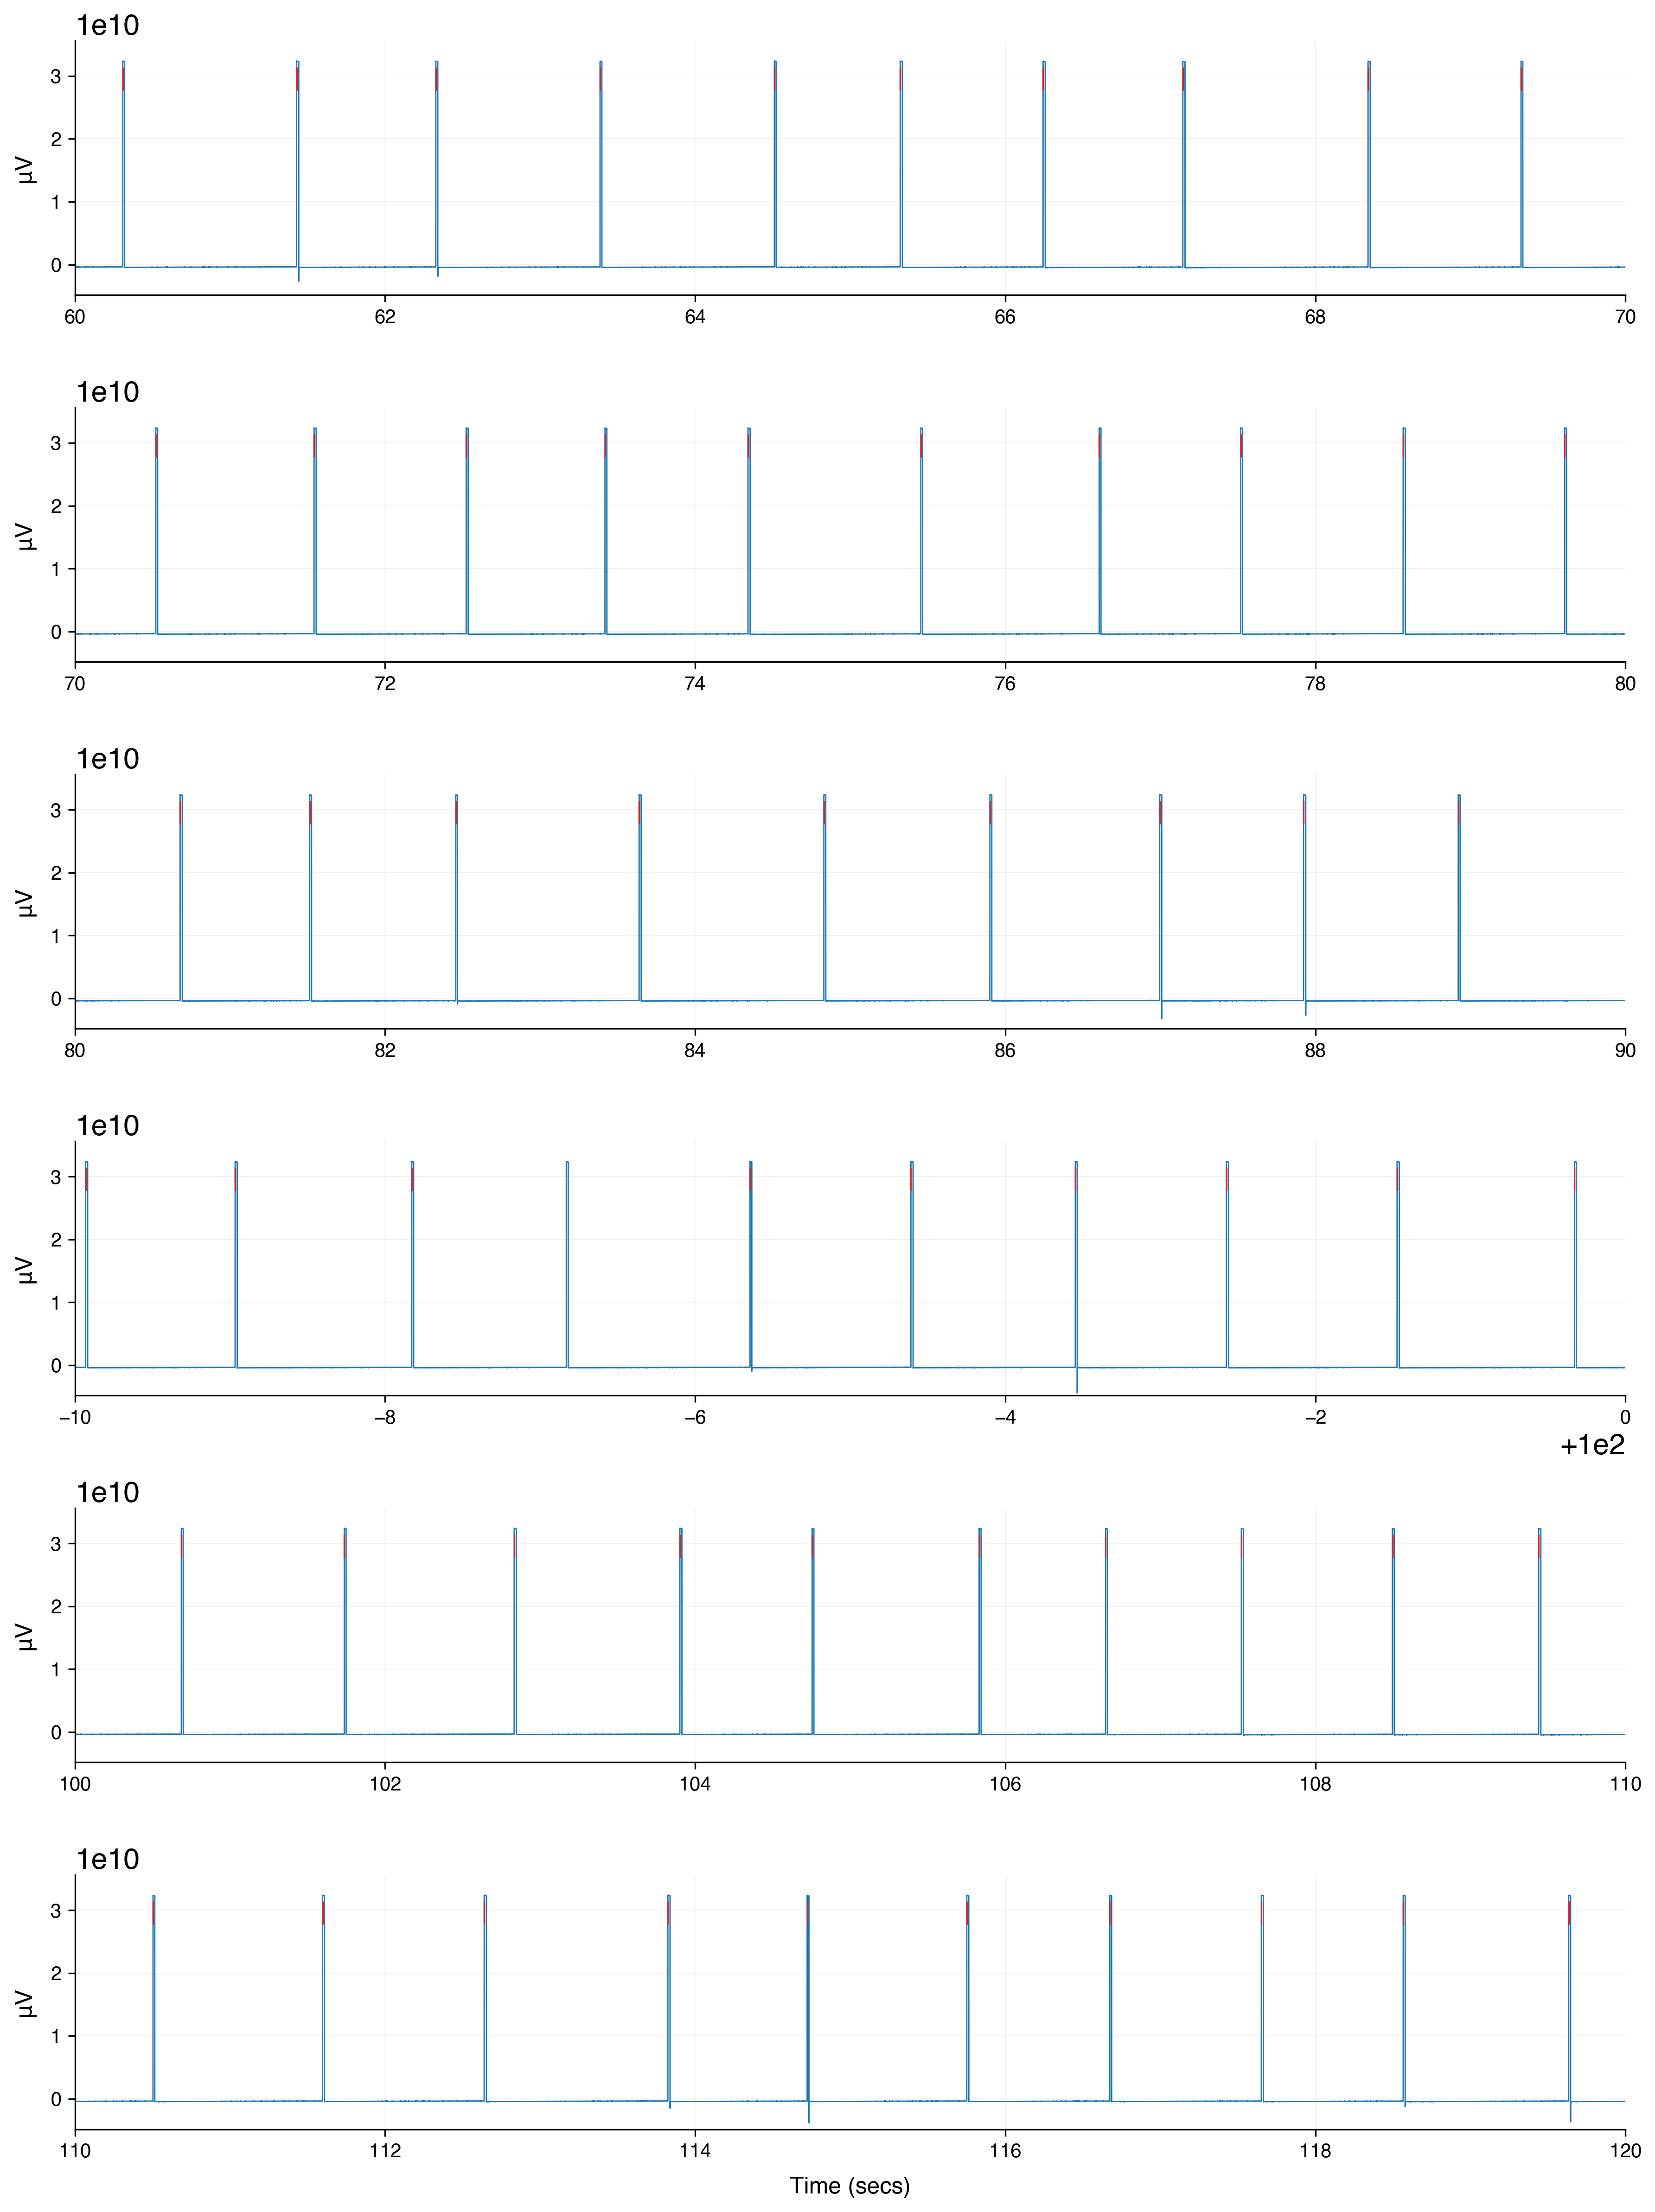

In [335]:
fig, ax = plot_trace2(sync_chan, spike_dat=pulse_startinds_train,
                      start=60, duration=60, nwin=6, x_units='secs', sampling_rate=30000)

In [89]:
# files = glob(os.path.join(macros_dir, 'MACRO*.mat'))
# print('{} files'.format(len(files)))
# iChan = 0
# dat = []
# for datf in files[iChan:iChan+1]:
#     print(datf)
#     with h5py.File(datf, 'r') as f:
#         dat.append(np.squeeze(f['data']))
# dat = np.array(dat) * 1e-6
# print(dat.shape)
# fig, ax = plot_trace2(dat, start=600, duration=60, x_units='secs', sampling_rate=2000)

In [268]:
# Get event timestamps in ms.
events = read_json(os.path.join(events_dir, 'events.jsonl'))
events = events[['time', 'type', 'data']].rename(columns={'type': 'key', 'data': 'value'})
events['time'] = (events['time'] - events.at[0, 'time'])
event_synctimes = events.loc[events.key=='syncPulse', 'time'].values[:800]
print('{} events recorded over {} min and {} sec'.format(len(events), int(events.iloc[-1]['time']/60000), int((events.iloc[-1]['time']%60000)/1000)))

# Get LFP timestamps, convert sec to ms,
# and subtract the first timestamp from all timestamps
try:
    lfp_timestamps = np.squeeze(sio.loadmat(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'))['timeStamps'])
except NotImplementedError:
    with h5py.File(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'), 'r') as f:
        lfp_timestamps = np.squeeze(f['timeStamps'])
lfp_timestamps = lfp_timestamps * 1e3
#lfp_timestamps = lfp_timestamps - lfp_timestamps[0]
session_length = (lfp_timestamps[-1] - lfp_timestamps[0]) * 1e-3 # in sec
print('session length is {} min and {} sec'.format(int(session_length/60), int(session_length%60)))

# Load the sync channel data (sampled at 2000 Hz for U515_ses0)
# and convert the analog signal into sync start indices.
try:
    sync_chan = np.squeeze(sio.loadmat(os.path.join(sync_dir, 'sync_channel_micro.mat'))['data'])
except NotImplementedError:
    with h5py.File(os.path.join(sync_dir, 'sync_channel_micro.mat'), 'r') as f:
        sync_chan = np.squeeze(f['data'])
print('{} lfp timestamps and {} sync channel datapoints (should be equal)'.format(len(lfp_timestamps), len(sync_chan)))
pulse_startinds = find_pulse_starts(sync_chan)

# Get the LFP time in ms for each sync pulse event.
lfp_synctimes = lfp_timestamps[pulse_startinds][:800]
      
# Align events to LFP.
sync_params, before_stats, after_stats = align_sync_pulses(event_synctimes, lfp_synctimes, good_fit_thresh_ms=None)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: sync_params['intercept'] + (sync_params['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes)))
print('\n--------------------\nAlignment parameters\n--------------------')
print('Intercept: {}\nSlope: {}'.format(sync_params['intercept'], sync_params['slope']))
print('Before alignment r={:.4f}, RMSE={:.4f} ms,\n|Error| percentiles:\n{}'
      .format(before_stats['r'], before_stats['rmse'], before_stats['err_pcts']))
print('After alignment r={:.4f}, RMSE={:.4f} ms,\n|Error| percentiles:\n{}'
      .format(after_stats['r'], after_stats['rmse'], after_stats['err_pcts']))

81314 events recorded over 80 min and 5 sec
session length is 81 min and 6 sec
145996506 lfp timestamps and 145996506 sync channel datapoints (should be equal)
Best IPI fit ind: 30 (shift=0), RMSE=0.19 ms
800 event sync pulses
800 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
Intercept: 32207.222069452953
Slope: 1.0000112667842214
Before alignment r=1.0000, RMSE=32211.7249 ms,
|Error| percentiles:
0      32207.820020
1      32207.949919
5      32208.189662
10     32208.415054
25     32209.300887
50     32211.503255
75     32213.911601
90     32215.517425
95     32216.016883
99     32216.436719
100    32216.719971
dtype: float64
After alignment r=1.0000, RMSE=0.2740 ms,
|Error| percentiles:
0      0.000590
1      0.001904
5      0.013083
10     0.026075
25     0.066925
50     0.174849
75     0.291521
90     0.417471
95     0.572419
99     0.857332
100    0.978098
dtype: float64


## Format ses0 events

In [338]:
events.shape

(123620, 4)

In [339]:
experiment_scene = 'SMaze2'

# ----------------------------------
# Add column for scene.
events['scene'] = fill_column(events, 'loadScene', 'sceneName', fill_back=False)

# Get the main experiment events (dropping the tutorial events).
events = events.loc[events['scene']==experiment_scene].reset_index(drop=True).copy()

# Add column for game states.
events['gameState'] = fill_column(events, 'gameState', 'stateName', fill_back=False)

# Add column for trial.
events['trial'] = 0
trial_inds = get_trial_inds(events)
for trial, inds in trial_inds.items():
    events.loc[inds, 'trial'] = trial

# Add whether each trial has a time penalty or not. (-1 means we could not resolve.)
events['time_penalty'] = -1
for trial, has_penalty in {x['trial']:x['value']['isTimedTrial'] 
                           for idx, x in events.query("(key=='timedTrial')").iterrows()}.items():
    events.loc[events['trial']==trial, 'time_penalty'] = 1 if has_penalty else 0
    
# Reorder columns.
events = events[['time', 'key', 'value', 'scene', 'trial', 'time_penalty', 'gameState']]

# Distinguish between pre-encoding delays (Delay1)
# and pre-retrieval delays (Delay2),
# and between post-encoding returns to base (ReturnToBase1)
# and post-retrieval returns to base (ReturnToBase2)
for trial in range(1, events['trial'].max()+1):
    for game_state in ['Delay', 'ReturnToBase']:
        inds = events.loc[(events['trial']==trial) & (events['gameState']==game_state)].index.tolist()
        sep = np.where(np.diff(inds)>1)[0]
        assert len(sep) == 1
        events.loc[(events.index.isin(inds[:sep[0]+1])) & 
                   (events['trial']==trial) & 
                   (events['gameState']==game_state), 'gameState'] = game_state + '1'
        events.loc[(events.index.isin(inds[sep[0]+1:])) & 
                   (events['trial']==trial) & 
                   (events['gameState']==game_state), 'gameState'] = game_state + '2'
        
print(events.shape)

(99509, 7)


In [340]:
# Take note of which trial periods should be thrown out.
events['bad_trials'] = ''

# Flag incomplete trials.
check_game_states = ['InitTrial', 'Delay1', 'Encoding', 'ReturnToBase1',
                     'Delay2', 'Retrieval', 'ReturnToBase2', 'DoNextTrial']
events.loc[(events['trial']==0), 'bad_trials'] = 'incomplete'
for trial in range(1, events['trial'].max()+1):
    game_states = list(events.loc[(events['trial']==trial), 'gameState'].unique())
    if not np.all([x in game_states for x in check_game_states]):
        events.loc[(events['trial']==trial), 'bad_trials'] = 'incomplete'

# Flag trial periods with manual pauses.
timed_game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
pause_inds = [idx for idx, row in events.query("(key=='gamePaused')").iterrows() 
              if row['value']['pauseType']=='manualPause']
for idx in pause_inds:
    game_state = events.iloc[idx]['gameState']
    if game_state in timed_game_states:
        events.loc[(events['trial']==trial) & (events['gameState']==game_state), 'bad_trials'] = 'paused'

# Remove bad trial periods.
print('Removing trial periods:\n')
display(events.query("bad_trials!=''").groupby(['trial', 'gameState'])['bad_trials'].apply(lambda x: np.unique(x)))
events = events.loc[events['bad_trials']==''].reset_index(drop=True)
events.shape

Removing trial periods:



trial  gameState  
0      DoNextTrial    [incomplete]
       InitTrial      [incomplete]
Name: bad_trials, dtype: object

(98962, 8)

In [341]:
print('Main experiment has {} events recorded over {} min and {} sec'.format(len(events), 
                                                         int((events.iloc[-1]['time'] - events.iloc[0]['time'])/60000), 
                                                         int(((events.iloc[-1]['time'] - events.iloc[0]['time'])%60000)/1000)))

Main experiment has 98962 events recorded over 74 min and 43 sec


In [354]:
events.query("(key=='score')").shape, events.query("(key=='dig')").shape
events.query("(key=='dig')").agg({'value': lambda x})

time  key                                              value  \
7851   1.773755e+06  dig  {'successful': False, 'distanceFromNearestGold...   
7883   1.774705e+06  dig  {'successful': False, 'distanceFromNearestGold...   
7900   1.775138e+06  dig  {'successful': False, 'distanceFromNearestGold...   
7919   1.775637e+06  dig  {'successful': False, 'distanceFromNearestGold...   
7937   1.776139e+06  dig  {'successful': False, 'distanceFromNearestGold...   
8064   1.781539e+06  dig  {'successful': False, 'distanceFromNearestGold...   
8090   1.782221e+06  dig  {'successful': False, 'distanceFromNearestGold...   
22440  2.362478e+06  dig  {'successful': False, 'distanceFromNearestGold...   
22588  2.367527e+06  dig  {'successful': False, 'distanceFromNearestGold...   
25493  2.486042e+06  dig  {'successful': True, 'distanceFromNearestGold'...   
28183  2.599606e+06  dig  {'successful': True, 'distanceFromNearestGold'...   
36777  3.190496e+06  dig  {'successful': True, 'distanceFromNearestGold'...   
50514  3.837935e+06  dig  {'successful': True, 'distanceFromNearestGold'...   
58602  4.169245e+06  dig  {'successful': False, 'distanceFromNearestGold...   
58622  4.169711e+06  dig  {'successful': False, 'distanceFromNearestGold...   
58671  4.171161e+06  dig  {'successful': True, 'distanceFromNearestGold'...   
60982  4.270494e+06  dig  {'successful': False, 'distanceFromNearestGold...   
61109  4.274660e+06  dig  {'successful': False, 'distanceFromNearestGold...   
61245  4.279176e+06  dig  {'successful': False, 'distanceFromNearestGold...   
64945  4.421708e+06  dig  {'successful': False, 'distanceFromNearestGold...   
65058  4.425474e+06  dig  {'successful': False, 'distanceFromNearestGold...   
67171  4.516655e+06  dig  {'successful': False, 'distanceFromNearestGold...   
67284  4.520356e+06  dig  {'successful': True, 'distanceFromNearestGold'...   
68916  4.719685e+06  dig  {'successful': True, 'distanceFromNearestGold'...   
70899  4.805400e+06  dig  {'successful': False, 'distanceFromNearestGold...   
70949  4.806735e+06  dig  {'successful': False, 'distanceFromNearestGold...   
71048  4.809733e+06  dig  {'successful': False, 'distanceFromNearestGold...   
71227  4.814682e+06  dig  {'successful': False, 'distanceFromNearestGold...   
71472  4.821900e+06  dig  {'successful': False, 'distanceFromNearestGold...   
73798  4.911415e+06  dig  {'successful': True, 'distanceFromNearestGold'...   
87184  5.460305e+06  dig  {'successful': True, 'distanceFromNearestGold'...   
92174  5.671785e+06  dig  {'successful': False, 'distanceFromNearestGold...   
92313  5.676334e+06  dig  {'successful': False, 'distanceFromNearestGold...   
95602  5.804016e+06  dig  {'successful': False, 'distanceFromNearestGold...   
95620  5.804432e+06  dig  {'successful': False, 'distanceFromNearestGold...   

        scene  trial  time_penalty  gameState bad_trials  
7851   SMaze2      3             0  Retrieval             
7883   SMaze2      3             0  Retrieval             
7900   SMaze2      3             0  Retrieval             
7919   SMaze2      3             0  Retrieval             
7937   SMaze2      3             0  Retrieval             
8064   SMaze2      3             0  Retrieval             
8090   SMaze2      3             0  Retrieval             
22440  SMaze2      8             0  Retrieval             
22588  SMaze2      8             0  Retrieval             
25493  SMaze2      9             1  Retrieval             
28183  SMaze2     10             0  Retrieval             
36777  SMaze2     13             1  Retrieval             
50514  SMaze2     18             1  Retrieval             
58602  SMaze2     21             0  Retrieval             
58622  SMaze2     21             0  Retrieval             
58671  SMaze2     21             0  Retrieval             
60982  SMaze2     22             0  Retrieval             
61109  SMaze2     22             0  Retrieval             
61245  SMaze2     22             0  Retrieval    

In [343]:
subj_sess = 'U521_ses0'
data_dir = '/scratch/dscho/time_cells/data'
analysis_dir = '/scratch/dscho/time_cells/analysis'
sampling_rate = 30000

# --------------------------------------

# Get subject directories.
subj, sess = subj_sess.split('_')
subj_dir = os.path.join(data_dir, subj, sess)
events_dir = os.path.join(subj_dir, 'events')
# spikes_dir = os.path.join(subj_dir, 'spikes', 'wave_clus3_autosort')
spikes_dir = os.path.join(subj_dir, 'spikes', 'wave_clus3_sortbyhand')
micros_dir = os.path.join(subj_dir, 'micro_lfps')
sync_dir = os.path.join(subj_dir, 'sync')
sr = sampling_rate

# Save events!
events_f = os.path.join(analysis_dir, 'events', '{}_events_formatted.pkl'.format(subj_sess))
if os.path.exists(events_f):
    print('Found events')
    events = dio.open_pickle(events_f)
else:
    dio.save_pickle(events, events_f)

Saved /scratch/dscho/time_cells/analysis/events/U521_ses0_events_formatted.pkl


## Load ses0 spike data

In [36]:
spikes_dir, micros_dir

('/scratch/dscho/time_cells/data/U518/ses0/spikes/wave_clus3_sortbyhand',
 '/scratch/dscho/time_cells/data/U518/ses0/micro_lfps')

In [157]:
def format_spikes(subj_sess,
                  n_spike_thresh=0,
                  fr_thresh=0, # in Hz
                  proj_dir='/home1/dscho/projects/time_cells',
                  spikes_dirname='wave_clus3_sortbyhand',
                  add_montage_info=True,
                  save_output=True,
                  overwrite=False,
                  verbose=True):
    """Gather spike times from all wave_clus single-units.
    
    Depends on the Goldmine file structure.
    
    Timestamps are converted to ms for compatability with
    the micro LFP files.
    
    Returns
    -------
    spikes : pandas.core.frame.DataFrame
    """
    # Look for existing output file.
    output_f = os.path.join(proj_dir, 'analysis', 'spikes', 
                            '{}_spikes.pkl'.format(subj_sess))
    if os.path.exists(output_f) and not overwrite:
        print('Found spikes')
        spikes = dio.open_pickle(output_f)
        return spikes
    
    # Check for required input files.
    spikes_dir = os.path.join(proj_dir, 'data', subj, sess, 'spikes', spikes_dirname)
    micros_dir = os.path.join(proj_dir, 'data', subj, sess, 'micro_lfps')
    lfp_timestamps_f = os.path.join(micros_dir, 'lfpTimeStamps_micro.mat')
    assert os.path.exists(lfp_timestamps_f)
    if add_montage_info:
        elec_montage_f = os.path.join(micros_dir, 'anatleads.txt')
        assert os.path.exists(elec_montage_f)
    
    # Get all spike files for the session.
    spike_files_ = glob(os.path.join(spikes_dir, 'times*.mat'))
    assert len(spike_files_) > 0
    if verbose:
        print('Found {} wave_clus files.'.format(len(spike_files_)), end='\n\n')
    
    # Reorder spike files.
    spike_fname = 'times_CSC{}.mat'
    spike_files = [os.path.join(spikes_dir, spike_fname.format(chan))
                   for chan in range(1, len(spike_files_)+1)
                   if os.path.exists(os.path.join(spikes_dir, spike_fname.format(chan)))]
    if verbose: 
        if len(spike_files) < len(spike_files_):
            print('Dropped these files: {}'
                  .format([f for f in spike_files_ if f not in spike_files]))
        print('{} wave_clus files after reordering.'.format(len(spike_files)), end='\n\n')
    
    # Get LFP timestamps, convert sec to ms,
    # and subtract the first timestamp from all timestamps
    try:
        lfp_timestamps = np.squeeze(sio.loadmat(lfp_timestamps_f)['timeStamps'])
    except NotImplementedError:
        with h5py.File(lfp_timestamps_f, 'r') as f:
            lfp_timestamps = np.squeeze(f['timeStamps'])
    lfp_timestamps = lfp_timestamps * 1e3
    if verbose:
        session_dur = (lfp_timestamps[-1] - lfp_timestamps[0]) * 1e-3 # in sec
        print('session duration is {} min and {} sec'.format(int(session_dur/60), 
                                                             int(session_dur%60)),
              end='\n\n')
        
    # Get spike times from all wave_clus single-units.
    chans = [int(os.path.basename(f).split('CSC')[1].split('.')[0]) for f in spike_files]
    spikes = []
    for iChan, spike_file in enumerate(spike_files):
        chan = chans[iChan]
        cluster_class = sio.loadmat(spike_file)['cluster_class']
        units = np.unique(cluster_class[:, 0])
        if len(units) > 1:
            for unit in range(1, len(units)):
                spike_times = cluster_class[:, 1][np.where(cluster_class[:, 0]==unit)[0]]
                n_spikes = len(spike_times)
                fr = n_spikes/session_dur
                if (n_spikes>n_spike_thresh) & (fr>fr_thresh):
                    spikes.append([subj_sess, subj, sess, chan, 
                                   unit, spike_times, n_spikes, fr])
    cols = ['subj_sess', 'subj', 'sess', 'chan', 
            'unit', 'spike_times', 'n_spikes', 'fr']
    spikes = pd.DataFrame(spikes, columns=cols)
    if verbose:
        print('Found {} neurons'.format(len(spikes)))
        print('Firing rates:', spikes['fr'].describe(), sep='\n', end='\n\n')
        
    # Add electrode region info.
    if add_montage_info:
        with open(elec_montage_f, 'r') as f:
            mont = f.readlines()
        mont = [line.strip('\n').split(', ') for line in mont]
        mont = od([(x[0], np.arange(int(x[1].split('-')[0]), int(x[1].split('-')[1])+1))
                   for x in mont])
        def get_hemroi(chan, mont):
            for hemroi, chans in mont.items():
                if chan in chans:
                    return hemroi
        spikes['hemroi'] = spikes['chan'].apply(lambda x: get_hemroi(x, mont))
    if verbose:
        display(spikes.groupby('hemroi').agg({'unit': len, 
                                              'chan': lambda x: len(np.unique(x)), 
                                              'fr': lambda x: percentiles(x)}))
    
    # Save spikes.
    if save_output:
        dio.save_pickle(spikes, output_f, verbose)
    
    return spikes

In [68]:
# Format wave_clus outputs and generate a spike null distribution.
spikes = format_spikes(subj_sess, fr_thresh=0.1, overwrite=True, save_output=False)
spikes = add_null_to_spikes(spikes, n_perms=1000, save_output=True)

Found 96 wave_clus files.

96 wave_clus files after reordering.

session duration is 81 min and 6 sec

Found 56 neurons
Firing rates:
count    56.000000
mean      3.776990
std       4.709883
min       0.129866
25%       0.900022
50%       1.828811
75%       5.101663
max      21.102423
Name: fr, dtype: float64



unit  chan                                             fr
hemroi                                                           
LA         6     6      [0.72, 0.81, 0.93, 1.4, 1.93, 2.52, 3.05]
LAI        8     7       [0.22, 0.26, 0.3, 0.36, 1.0, 2.25, 4.59]
LMH       11     7      [0.51, 0.83, 0.94, 2.85, 5.72, 8.0, 8.54]
LO         6     5   [1.36, 1.79, 2.49, 4.22, 6.34, 13.89, 21.04]
LTO        3     3     [1.61, 1.71, 1.86, 2.11, 11.6, 17.3, 21.1]
LTPO       5     3       [1.0, 1.02, 1.05, 2.6, 4.34, 4.79, 5.08]
REC        6     6     [0.58, 0.72, 0.88, 1.04, 1.15, 4.94, 8.73]
RIP        2     2     [0.13, 0.15, 0.17, 0.21, 0.24, 0.27, 0.28]
RTO        9     7  [0.77, 1.24, 2.25, 6.43, 10.33, 13.56, 13.67]

In [49]:
elec_montage_f = os.path.join(micros_dir, 'anatleads.txt')
with open(elec_montage_f, 'r') as f:
    mont = f.readlines()
mont = [line.strip('\n').split(', ') for line in mont]
mont = od([(x[0], np.arange(int(x[1].split('-')[0]), int(x[1].split('-')[1])+1))
           for x in mont])

In [ ]:
# Add electrode region info.
def get_hemroi(chan):
    for hemroi, chans in mont.items():
        if chan in chans:
            return hemroi
spikes['hemroi'] = spikes['chan'].apply(lambda x: get_hemroi(x))

In [23]:
# Get all spike files for the session.
spike_files = glob(os.path.join(spikes_dir, 'times*.mat'))
print('{} files'.format(len(spike_files)))

# Reorder spike files.
spike_fname = 'times_CSC{}.mat'
spike_files = [os.path.join(spikes_dir, spike_fname.format(chan))
               for chan in range(1, len(spike_files)+1)
               if os.path.exists(os.path.join(spikes_dir, spike_fname.format(chan)))]
print('{} files'.format(len(spike_files)))

# Get LFP timestamps, convert sec to ms,
# and subtract the first timestamp from all timestamps
try:
    lfp_timestamps = np.squeeze(sio.loadmat(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'))['timeStamps'])
except NotImplementedError:
    with h5py.File(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'), 'r') as f:
        lfp_timestamps = np.squeeze(f['timeStamps'])
lfp_timestamps = lfp_timestamps * 1e3
session_length = (lfp_timestamps[-1] - lfp_timestamps[0]) * 1e-3 # in sec
print('session length is {} min and {} sec'.format(int(session_length/60), int(session_length%60)))

96 files
96 files
session length is 81 min and 6 sec


In [24]:
# Get spike times from all wave_clus single-units.
n_spike_thresh = 0
fr_thresh = 0.1
# ------------------

chans = [int(os.path.basename(f).split('CSC')[1].split('.')[0]) for f in spike_files]
spike_dat = []
for iChan, spike_file in enumerate(spike_files):
    chan = chans[iChan]
    cluster_class = sio.loadmat(spike_file)['cluster_class']
    units = np.unique(cluster_class[:, 0])
    if len(units) > 1:
        for unit in range(1, len(units)):
            spike_times = cluster_class[:, 1][np.where(cluster_class[:, 0]==unit)[0]]
            n_spikes = len(spike_times)
            if n_spikes > n_spike_thresh:
                spike_dat.append([subj_sess, subj, sess, chan, unit, spike_times, n_spikes, n_spikes/session_length])
cols = ['subj_sess', 'subj', 'sess', 'chan', 'unit', 'spike_times', 'n_spikes', 'fr']
spike_dat = pd.DataFrame(spike_dat, columns=cols)
spike_dat = spike_dat.loc[spike_dat['fr']>fr_thresh].reset_index(drop=True)
print(spike_dat.shape)
print(spike_dat['fr'].describe())

(56, 8)
count    56.000000
mean      3.776990
std       4.709883
min       0.129866
25%       0.900022
50%       1.828811
75%       5.101663
max      21.102423
Name: fr, dtype: float64


In [25]:
# Add montage info for U515
def get_hemroi(chan):
    mont = od([('REC', np.arange(1, 9, dtype=int)),
               ('RTO', np.arange(9, 17, dtype=int)),
               ('RIP', np.arange(17, 25, dtype=int)),
               ('LA', np.arange(25, 33, dtype=int)),
               ('LMH', np.arange(33, 41, dtype=int)),
               ('LTO', np.arange(41, 49, dtype=int)),
               ('LAI', np.arange(49, 57, dtype=int)),
               ('LMTG', np.arange(57, 65, dtype=int)),
               ('LO', np.arange(65, 73, dtype=int)),
               ('LTPO', np.arange(73, 81, dtype=int)),
               ('LPC', np.arange(81, 89, dtype=int)),
               ('LPOSTI', np.arange(89, 97, dtype=int))])
    for hemroi, chans in mont.items():
        if chan in chans:
            return hemroi
spike_dat['hemroi'] = spike_dat['chan'].apply(lambda x: get_hemroi(x))

In [19]:
# Save spikes.
spikes_f = os.path.join(analysis_dir, 'spikes', '{}_spikes.pkl'.format(subj_sess))
if os.path.exists(spikes_f):
    print('Found spikes')
    spike_dat = dio.open_pickle(spikes_f)
else:
    dio.save_pickle(spike_dat, spikes_f)

Saved /scratch/dscho/time_cells/analysis/spikes/U518_ses0_spikes.pkl


In [26]:
def percentiles(x):
    qs = []
    for q in [0, 10, 25, 50, 75, 90, 100]:
        qs.append(np.round(np.percentile(x, q), 2))
    return qs

print('{} neurons'.format(len(spike_dat)))
display(spike_dat.groupby('hemroi').agg({'unit': len, 'chan': lambda x: len(np.unique(x)), 'fr': lambda x: percentiles(x)}))

56 neurons


unit  chan                                             fr
hemroi                                                           
LA         6     6      [0.72, 0.81, 0.93, 1.4, 1.93, 2.52, 3.05]
LAI        8     7       [0.22, 0.26, 0.3, 0.36, 1.0, 2.25, 4.59]
LMH       11     7      [0.51, 0.83, 0.94, 2.85, 5.72, 8.0, 8.54]
LO         6     5   [1.36, 1.79, 2.49, 4.22, 6.34, 13.89, 21.04]
LTO        3     3     [1.61, 1.71, 1.86, 2.11, 11.6, 17.3, 21.1]
LTPO       5     3       [1.0, 1.02, 1.05, 2.6, 4.34, 4.79, 5.08]
REC        6     6     [0.58, 0.72, 0.88, 1.04, 1.15, 4.94, 8.73]
RIP        2     2     [0.13, 0.15, 0.17, 0.21, 0.24, 0.27, 0.28]
RTO        9     7  [0.77, 1.24, 2.25, 6.43, 10.33, 13.56, 13.67]

Text(0, 0.5, 'Time (ms)')

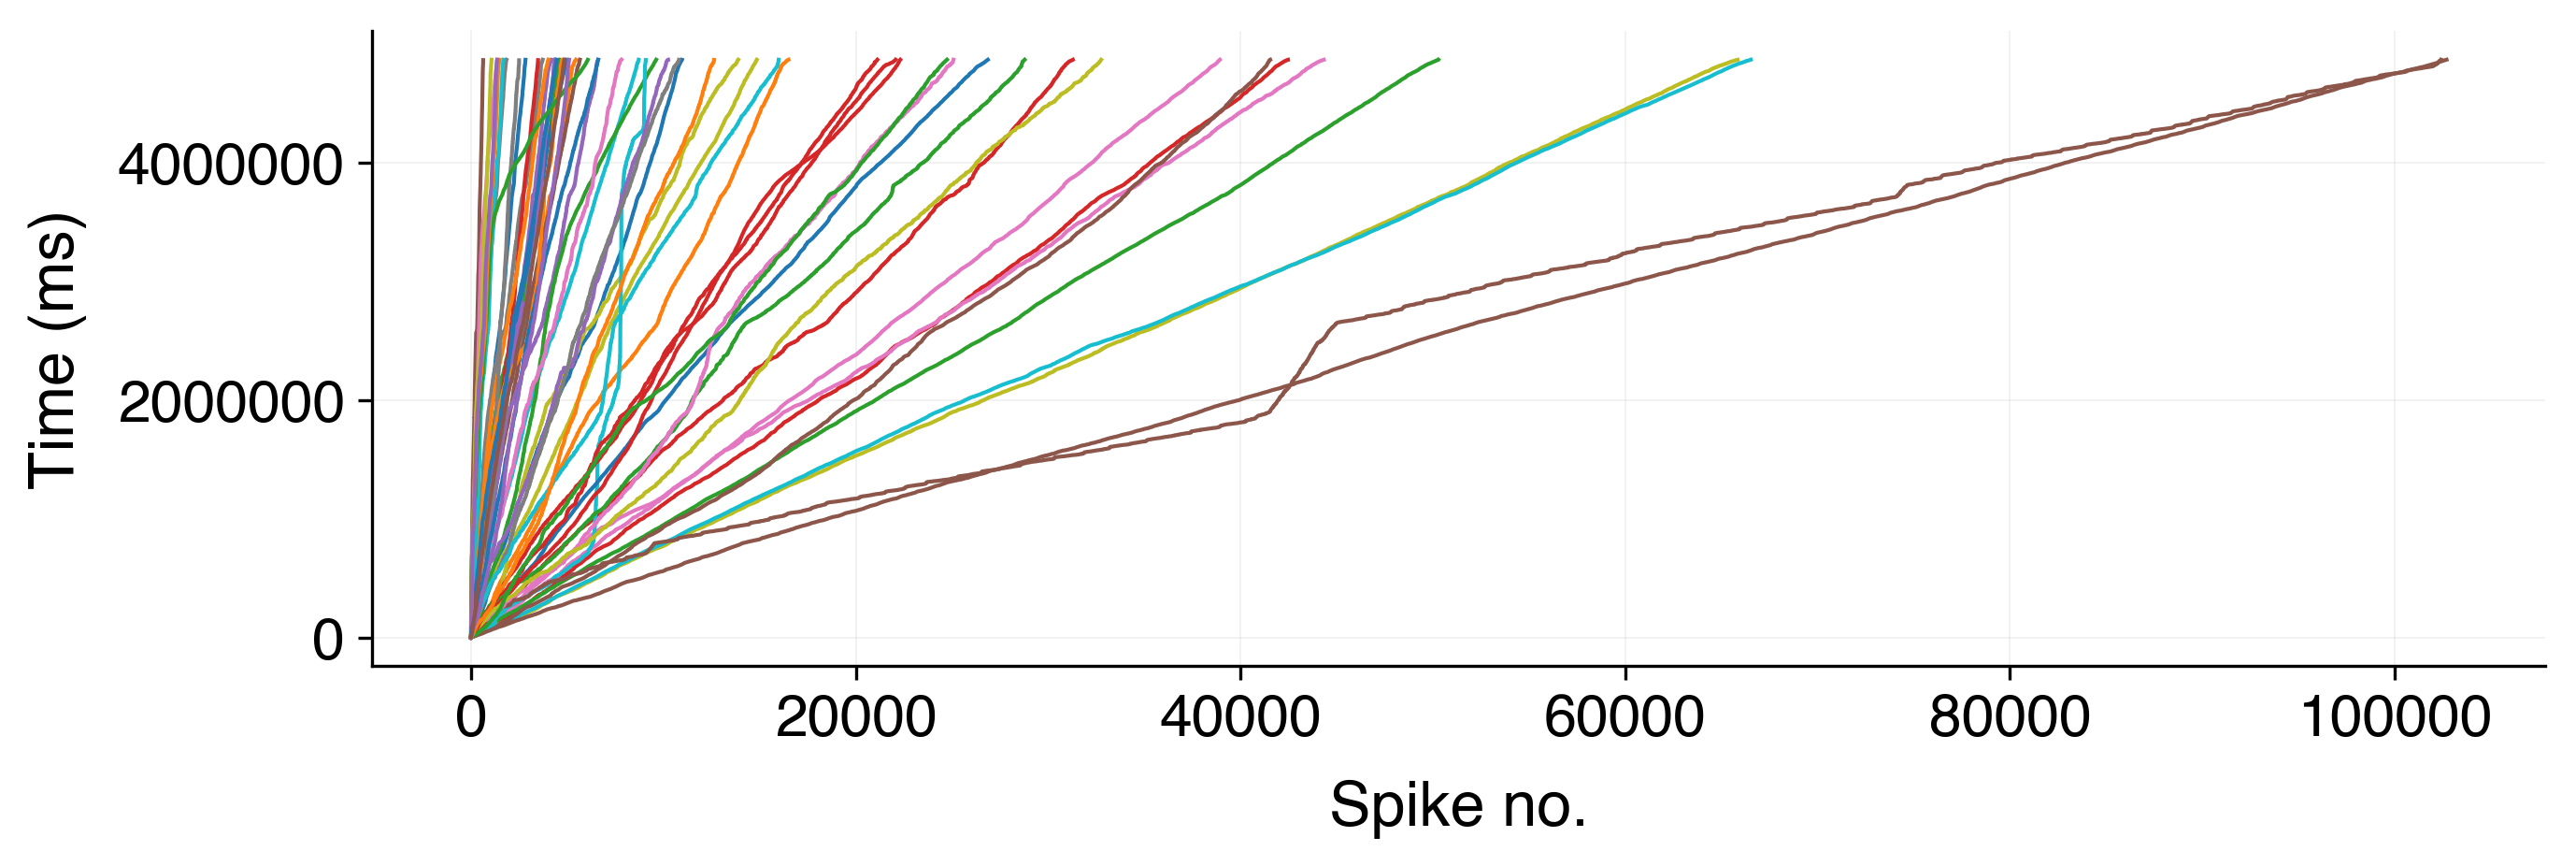

In [452]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)

for i in range(len(spike_dat)):
    ax.plot(spike_dat['spike_times'].tolist()[i])

ax.set_xlabel('Spike no.', fontsize=labelfontsize, labelpad=8)
ax.set_ylabel('Time (ms)', fontsize=labelfontsize, labelpad=8)

fig.show()

## Analyze task period activity

In [438]:
# Get the start and stop times for each task period, for each trial.
df1 = game_state_intervals(events, game_state='Encoding', cols=['time'])
df2 = game_state_intervals(events, game_state='Retrieval', cols=['time'])
df1.insert(1, 'gameState', 'Encoding')
df2.insert(1, 'gameState', 'Retrieval')
task_times = pd.concat((df1, df2), axis=0)

# Divide each task period into 60 time bins of equal duration
# (should be ~500 ms each)
n_time_bins_task = 60
task_times['time_bins'] = task_times['time'].apply(lambda x: np.linspace(x[0], x[1], num=n_time_bins_task+1))
task_time_bins = np.array(task_times['time_bins'].tolist()) # event x time_bin

print(task_time_bins.shape)

(72, 61)


In [439]:
# For each neuron, get the number of spikes in each task period time bin
start_time = time()

task_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>task_time_bins[iEvent, iTime], 
                                                spike_dat.loc[iUnit, 'spike_times']<=task_time_bins[iEvent, iTime+1]))
                            for iTime in range(task_time_bins.shape[1]-1)]
                           for iEvent in range(task_time_bins.shape[0])]
                         for iUnit in range(len(spike_dat))])
print(task_spikes.shape) # neuron x event x time_bin

print('Done in {:.2f} secs'.format(time() - start_time))

(56, 72, 60)
Done in 16.72 secs


In [440]:
# Use a one-way ANOVA to assess unequal firing rates across time
anova_results = []
for iUnit in range(task_spikes.shape[0]):
    df = pd.DataFrame({'trial_phase': np.repeat(task_times['gameState'].tolist(), n_time_bins_task),
                       'time_bin': np.tile(np.arange(n_time_bins_task, dtype=int), len(task_times)),
                       'n_spikes': task_spikes[iUnit, :, :].ravel()})
    model = ols('n_spikes ~ C(time_bin)', data=df).fit()
    anova_results.append((model.rsquared, model.fvalue, model.f_pvalue))
anova_results = pd.DataFrame(anova_results, columns=['R^2', 'F', 'F_p'])
anova_results.insert(0, 'iUnit', np.arange(len(anova_results), dtype=int))
anova_results['sig_fdr'] = sm.stats.multipletests(anova_results['F_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
anova_results = anova_results.sort_values('R^2', ascending=False).reset_index(drop=True)

# For each neuron, add the number of spikes in each time bin, across all task periods.
sig_cells_task = np.array(anova_results.query("(sig_fdr==True)")['iUnit'].tolist())
xtrial_task_spikes = np.sum(task_spikes[sig_cells_task, :, :], axis=1) # neuron x time_bin
show_units_task = sig_cells_task[np.argsort(xtrial_task_spikes.argmax(axis=-1))]

n_sig = anova_results['sig_fdr'].sum()
n_cells = len(anova_results)

print('{}/{} ({:.1f}%) cells are significantly time-modified'.format(n_sig, n_cells, 100 * (n_sig/n_cells)))

22/56 (39.3%) cells are significantly time-modified


min=0.15


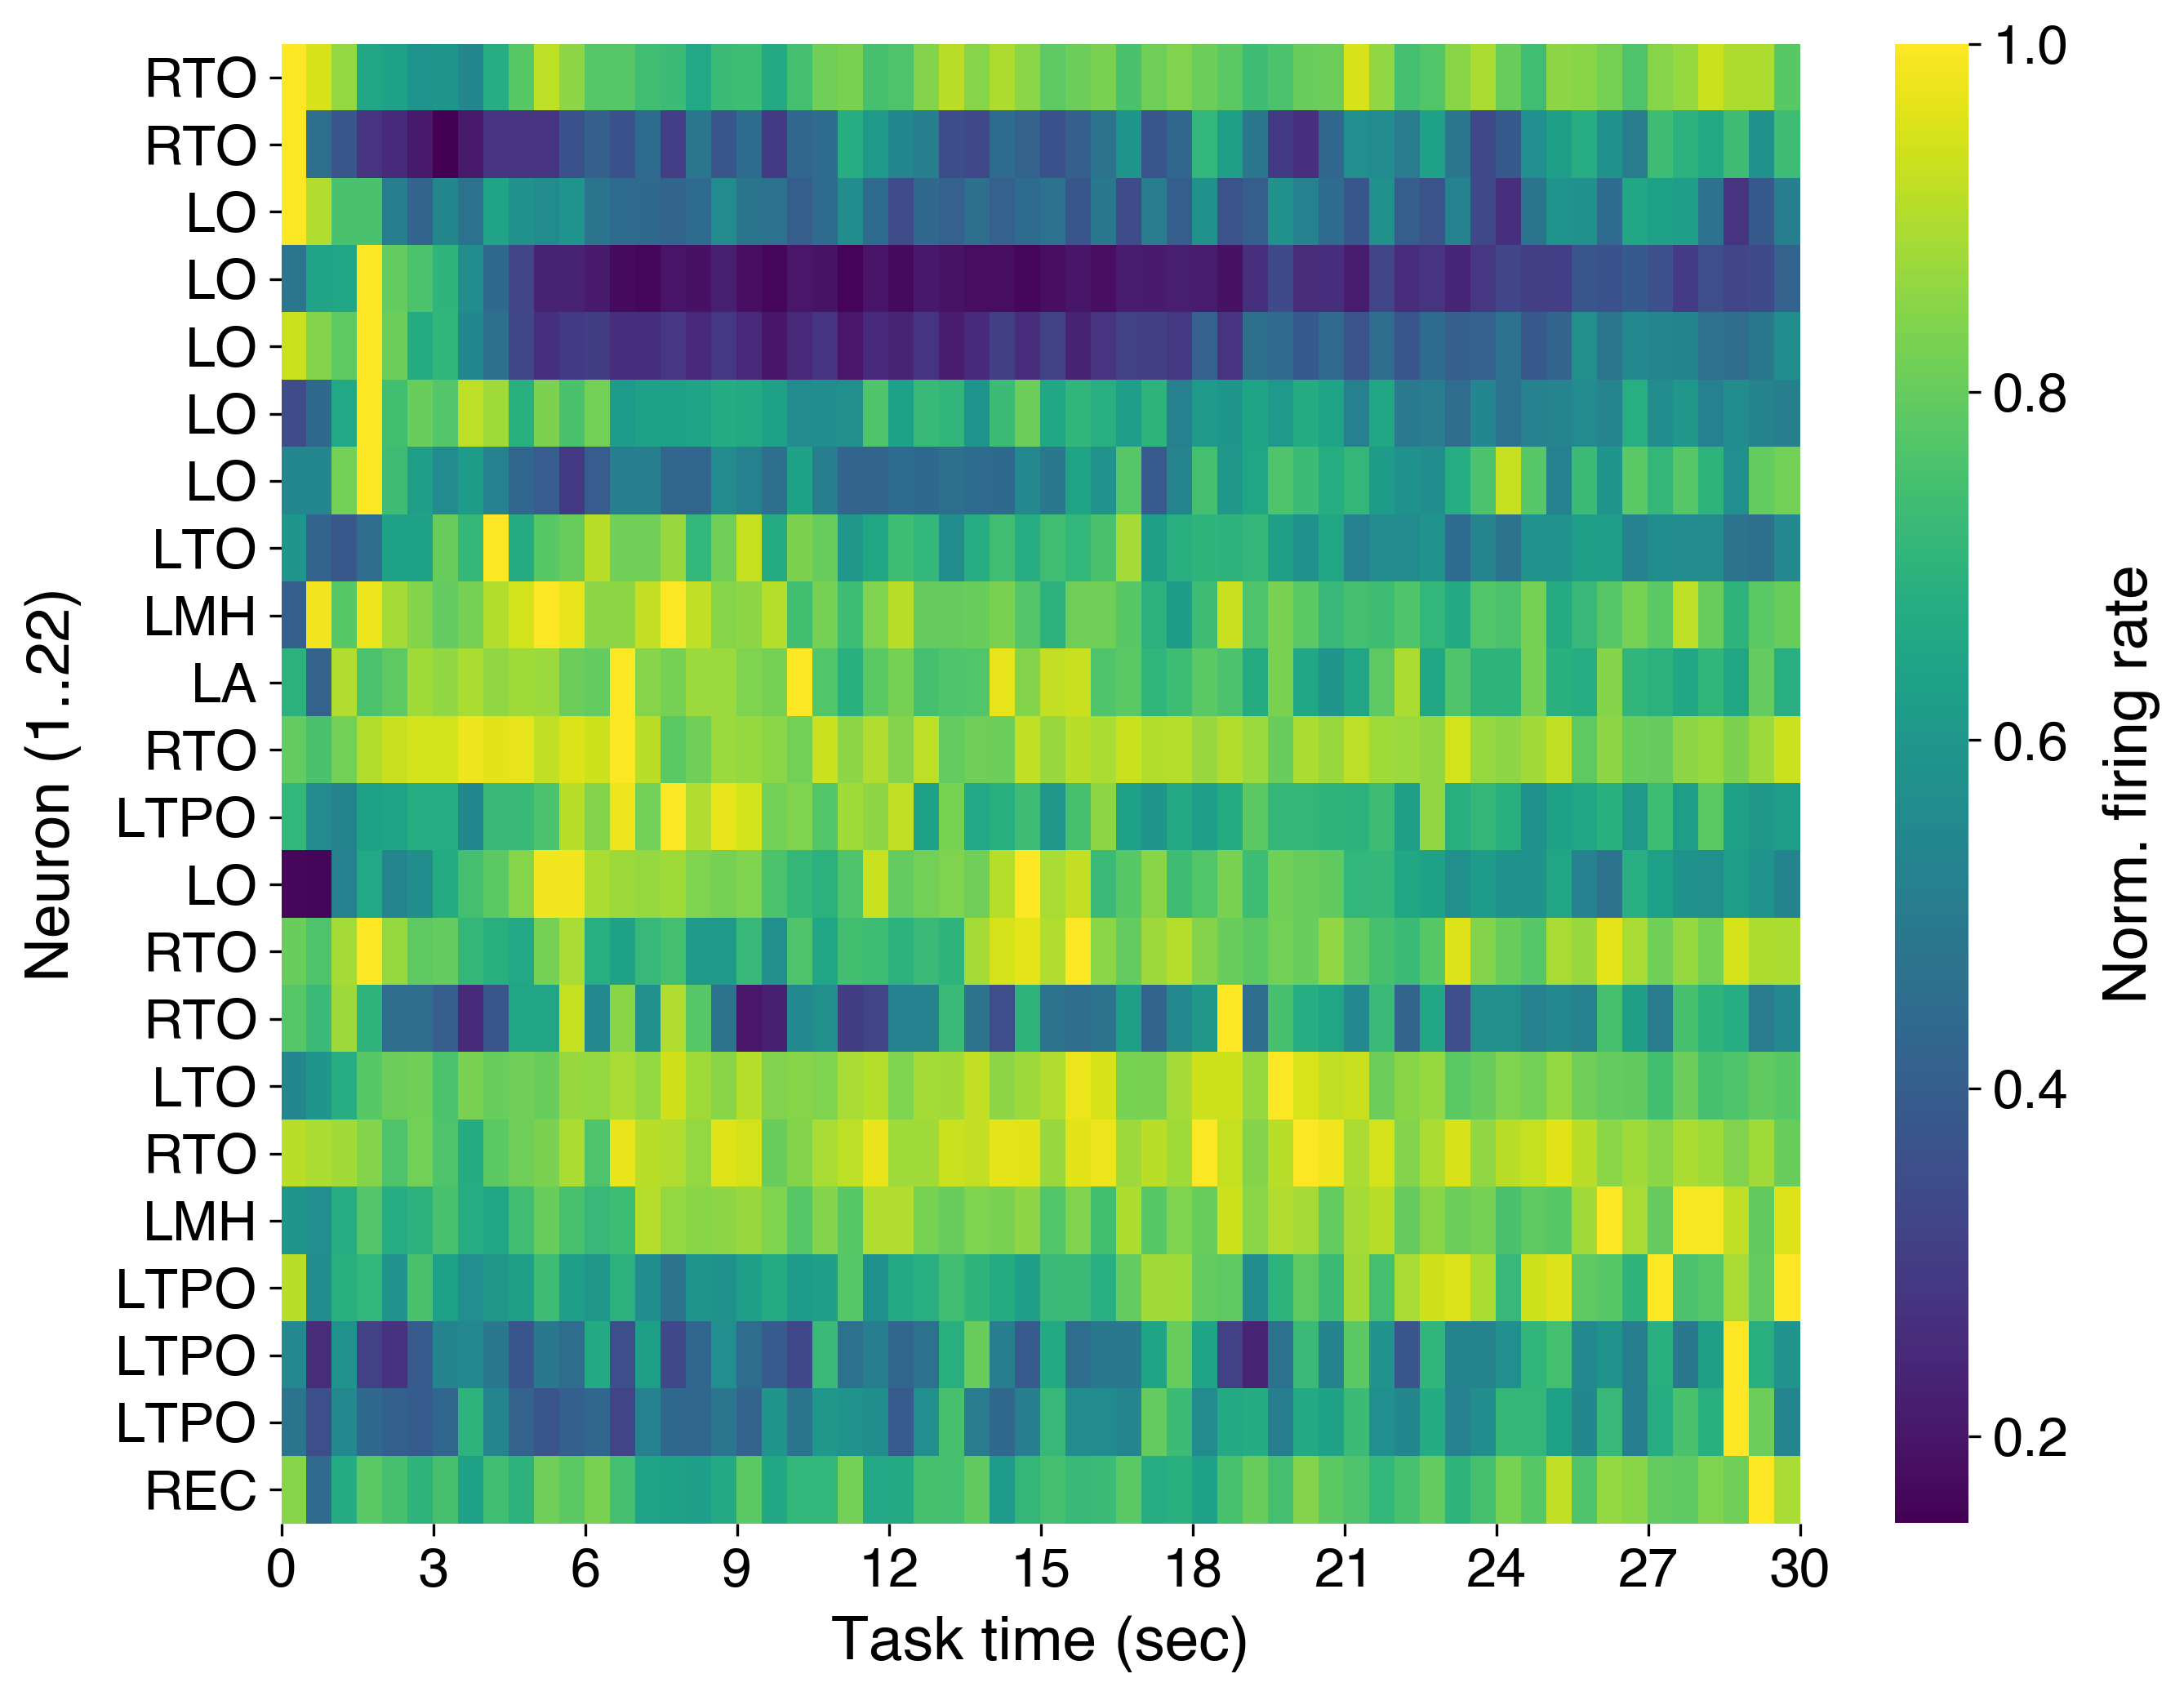

In [441]:
# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_task_spikes[np.argsort(xtrial_task_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, vmin=0.15, vmax=1, cmap='viridis', cbar=True, square=False, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 60, 11))
ax[i].set_xticklabels(np.linspace(0, 30, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spike_dat.iloc[show_units_task]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Task time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_task_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

## Analyze ses0 delay period activity

In [71]:
proj_dir = '/home1/dscho/projects/time_cells'
fname = os.path.join(proj_dir, 'analysis', 'spikes_by_time_bin', 'U518_ses0_delay_spikes_by_time_bin.pkl')
dat = dio.open_pickle(fname)

In [76]:
dat['time_info_delay_null'].shape[0]

1000

In [91]:
n_neurons = len(delay_fdr_sig)
delay_pvals = [  (np.sum(dat['time_info_delay_null'][:, iUnit]>dat['time_info_delay'][iUnit]) + 1) 
               / (dat['time_info_delay_null'].shape[0] + 1)
               for iUnit in range(n_neurons)]

# FDR correct the p-values.
delay_fdr_sig = sm.stats.multipletests(delay_pvals, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
n_sig_delay = np.sum(delay_fdr_sig)
sig_cells_delay = np.where(delay_fdr_sig)[0]

print('Found {}/{} ({:.1f} %) significant time cells during the delay interval'
      .format(n_sig_delay, n_neurons, 100*n_sig_delay/n_neurons))

Found 23/56 (41.1 %) significant time cells during the delay interval


In [30]:
# Get the start and stop times for each delay period, for each trial.
df1 = game_state_intervals(events, game_state='Delay1', cols=['time'])
df2 = game_state_intervals(events, game_state='Delay2', cols=['time'])
df1.insert(1, 'gameState', 'Delay1')
df2.insert(1, 'gameState', 'Delay2')
assert len(df1) == len(df2)

dat = []
for iRow in range(len(df1)):
    dat.append(df1.iloc[iRow])
    dat.append(df2.iloc[iRow])
    
delay_times = pd.DataFrame(dat, columns=df1.columns)

# Divide each delay period into 50 time bins of equal duration
# (should be ~500 ms each)
n_time_bins_delay = 20
delay_times['time_bins'] = delay_times['time'].apply(lambda x: np.linspace(x[0], x[1], num=n_time_bins_delay+1))
delay_time_bins = np.array(delay_times['time_bins'].tolist()) # event x time_bin

print(delay_time_bins.shape)

(72, 21)


In [31]:
# For each neuron, get the number of spikes in each delay period time bin
start_time = time()

delay_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>delay_time_bins[iEvent, iTime], 
                                                 spike_dat.loc[iUnit, 'spike_times']<=delay_time_bins[iEvent, iTime+1]))
                           for iTime in range(delay_time_bins.shape[1]-1)]
                          for iEvent in range(delay_time_bins.shape[0])]
                         for iUnit in range(len(spike_dat))])
print(delay_spikes.shape) # neuron x event x time_bin

print('Done in {:.2f} secs'.format(time() - start_time))

(56, 72, 20)
Done in 5.99 secs


In [457]:
# Use a one-way ANOVA to assess unequal firing rates across time x trial_phase
anova_results = []
for iUnit in range(delay_spikes.shape[0]):
    df = pd.DataFrame({'trial_phase': np.repeat(delay_times['gameState'].tolist(), n_time_bins_delay),
                       'time_bin': np.tile(np.arange(n_time_bins_delay, dtype=int), len(delay_times)),
                       'n_spikes': delay_spikes[iUnit, :, :].ravel()})
    model = ols('n_spikes ~ C(time_bin)', data=df).fit()
    anova_results.append((model.rsquared, model.fvalue, model.f_pvalue))
anova_results = pd.DataFrame(anova_results, columns=['R^2', 'F', 'F_p'])
anova_results.insert(0, 'iUnit', np.arange(len(anova_results), dtype=int))
anova_results['sig_fdr'] = sm.stats.multipletests(anova_results['F_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
anova_results = anova_results.sort_values('R^2', ascending=False).reset_index(drop=True)

# For each neuron, add the number of spikes in each time bin, across all delay periods.
sig_cells_delay = np.array(anova_results.query("(sig_fdr==True)")['iUnit'].tolist())
xtrial_delay_spikes = np.sum(delay_spikes[sig_cells_delay, :, :], axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=-1))]

n_sig = anova_results['sig_fdr'].sum()
n_cells = len(anova_results)

print('{}/{} ({:.1f}%) cells are significantly time-modified'.format(n_sig, n_cells, 100 * (n_sig/n_cells)))

19/56 (33.9%) cells are significantly time-modified


In [32]:
# Use a two-way ANOVA to assess unequal firing rates across time x trial_phase
anova_results = []
for iUnit in range(delay_spikes.shape[0]):
    df = pd.DataFrame({'trial_phase': np.repeat(delay_times['gameState'].tolist(), n_time_bins_delay),
                       'time_bin': np.tile(np.arange(n_time_bins_delay, dtype=int), len(delay_times)),
                       'n_spikes': delay_spikes[iUnit, :, :].ravel()})
    model = ols('n_spikes ~ C(time_bin) * C(trial_phase)', data=df).fit()
    anova_ixn = sm.stats.anova_lm(model, typ=2)
    model = ols('n_spikes ~ C(time_bin) + C(trial_phase)', data=df).fit()
    anova = sm.stats.anova_lm(model, typ=2)    
    anova_results.append((anova_ixn.loc['C(time_bin):C(trial_phase)']['F'], 
                          anova_ixn.loc['C(time_bin):C(trial_phase)']['PR(>F)'],
                          anova.loc['C(time_bin)']['F'],
                          anova.loc['C(time_bin)']['PR(>F)'],
                          anova.loc['C(trial_phase)']['F'],
                          anova.loc['C(trial_phase)']['PR(>F)']))
cols = ['ixn_F', 'ixn_p', 'time_F', 'time_p', 'trial_phase_F', 'trial_phase_p']
anova_results = pd.DataFrame(anova_results, columns=cols)
anova_results.insert(0, 'iUnit', np.arange(len(anova_results), dtype=int))
anova_results['ixn_sig_fdr'] = sm.stats.multipletests(anova_results['ixn_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
anova_results['time_sig_fdr'] = sm.stats.multipletests(anova_results['time_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
anova_results['trial_phase_sig_fdr'] = sm.stats.multipletests(anova_results['trial_phase_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]

# For each neuron, add the number of spikes in each time bin, across all delay periods.
sig_cells_delay = np.array(anova_results.query("(time_sig_fdr==True)")['iUnit'].tolist())
xtrial_delay_spikes = np.sum(delay_spikes[sig_cells_delay, :, :], axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=-1))]

n_sig_ixn = anova_results['ixn_sig_fdr'].sum()
n_sig_time = anova_results['time_sig_fdr'].sum()
n_sig_trial_phase = anova_results['trial_phase_sig_fdr'].sum()
n_cells = len(anova_results)

print('{}/{} ({:.1f}%) cells have a significant time x trial phase interaction'.format(n_sig_ixn, n_cells, 100 * (n_sig_ixn/n_cells)))
print('{}/{} ({:.1f}%) cells are significantly time-modified'.format(n_sig_time, n_cells, 100 * (n_sig_time/n_cells)))
print('{}/{} ({:.1f}%) cells are significantly trial phase-modified'.format(n_sig_trial_phase, n_cells, 100 * (n_sig_trial_phase/n_cells)))

0/56 (0.0%) cells have a significant time x trial phase interaction
19/56 (33.9%) cells are significantly time-modified
7/56 (12.5%) cells are significantly trial phase-modified


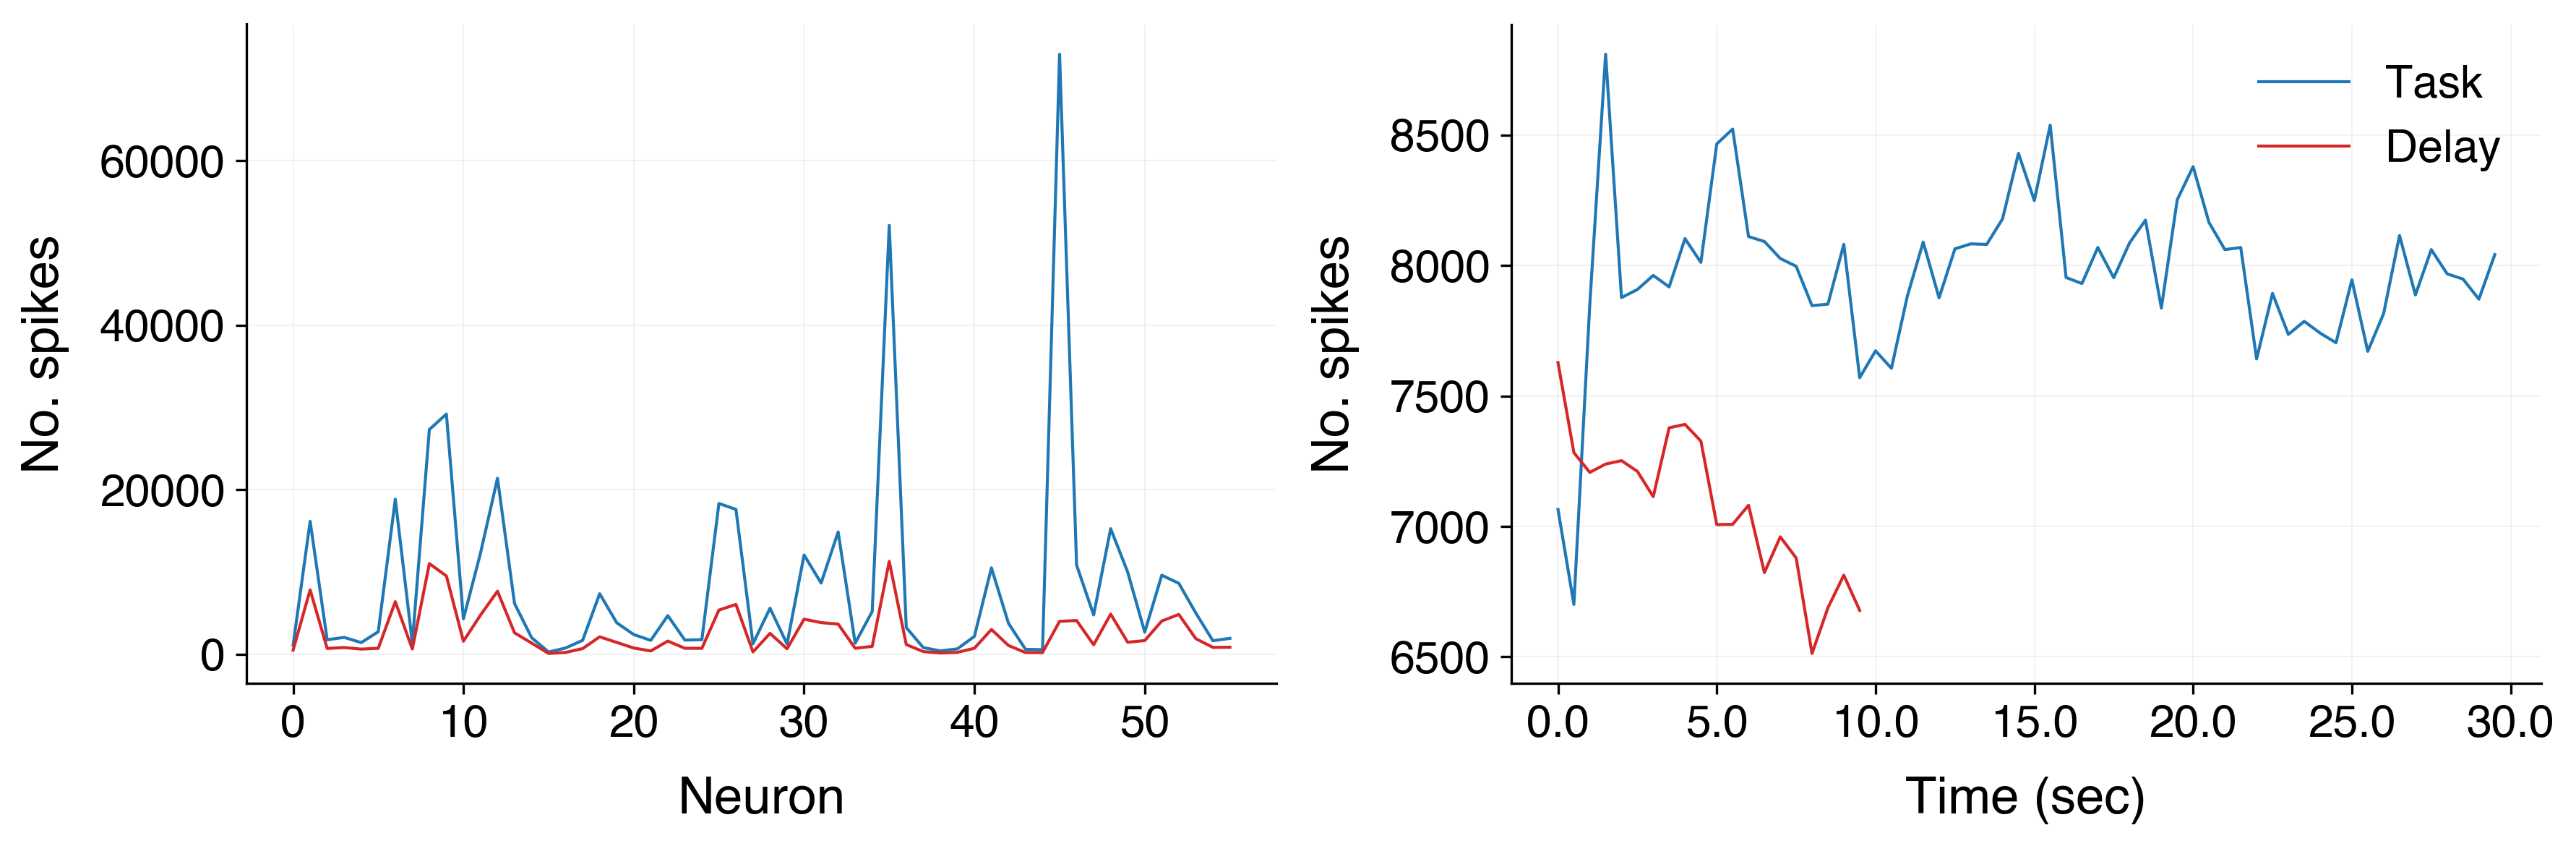

In [446]:
# How many spikes in each time bin across neurons?
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i].plot(np.sum(task_spikes, axis=(1, 2)), label='Task')
ax[i].plot(np.sum(delay_spikes, axis=(1, 2)), label='Delay')
ax[i].set_xlabel('Neuron')
ax[i].set_ylabel('No. spikes')

i = 1
ax[i].plot(np.sum(task_spikes, axis=(0, 1)), label='Task')
ax[i].plot(np.sum(delay_spikes, axis=(0, 1)), label='Delay')
ax[i].set_xticks(np.linspace(0, 60, 7, dtype=int))
ax[i].set_xticklabels([x/2 for x in np.linspace(0, 60, 7, dtype=int)])
ax[i].set_xlabel('Time (sec)')
ax[i].set_ylabel('No. spikes')
ax[i].legend()

fig.tight_layout()

In [33]:
sig_cells_delay = np.array(anova_results.query("(time_sig_fdr==True)")['iUnit'].tolist())
sig_cells_delay

array([ 1,  6,  8, 12, 13, 14, 22, 25, 32, 35, 45, 46, 47, 48, 49, 50, 51,
       52, 53])

min=0.11


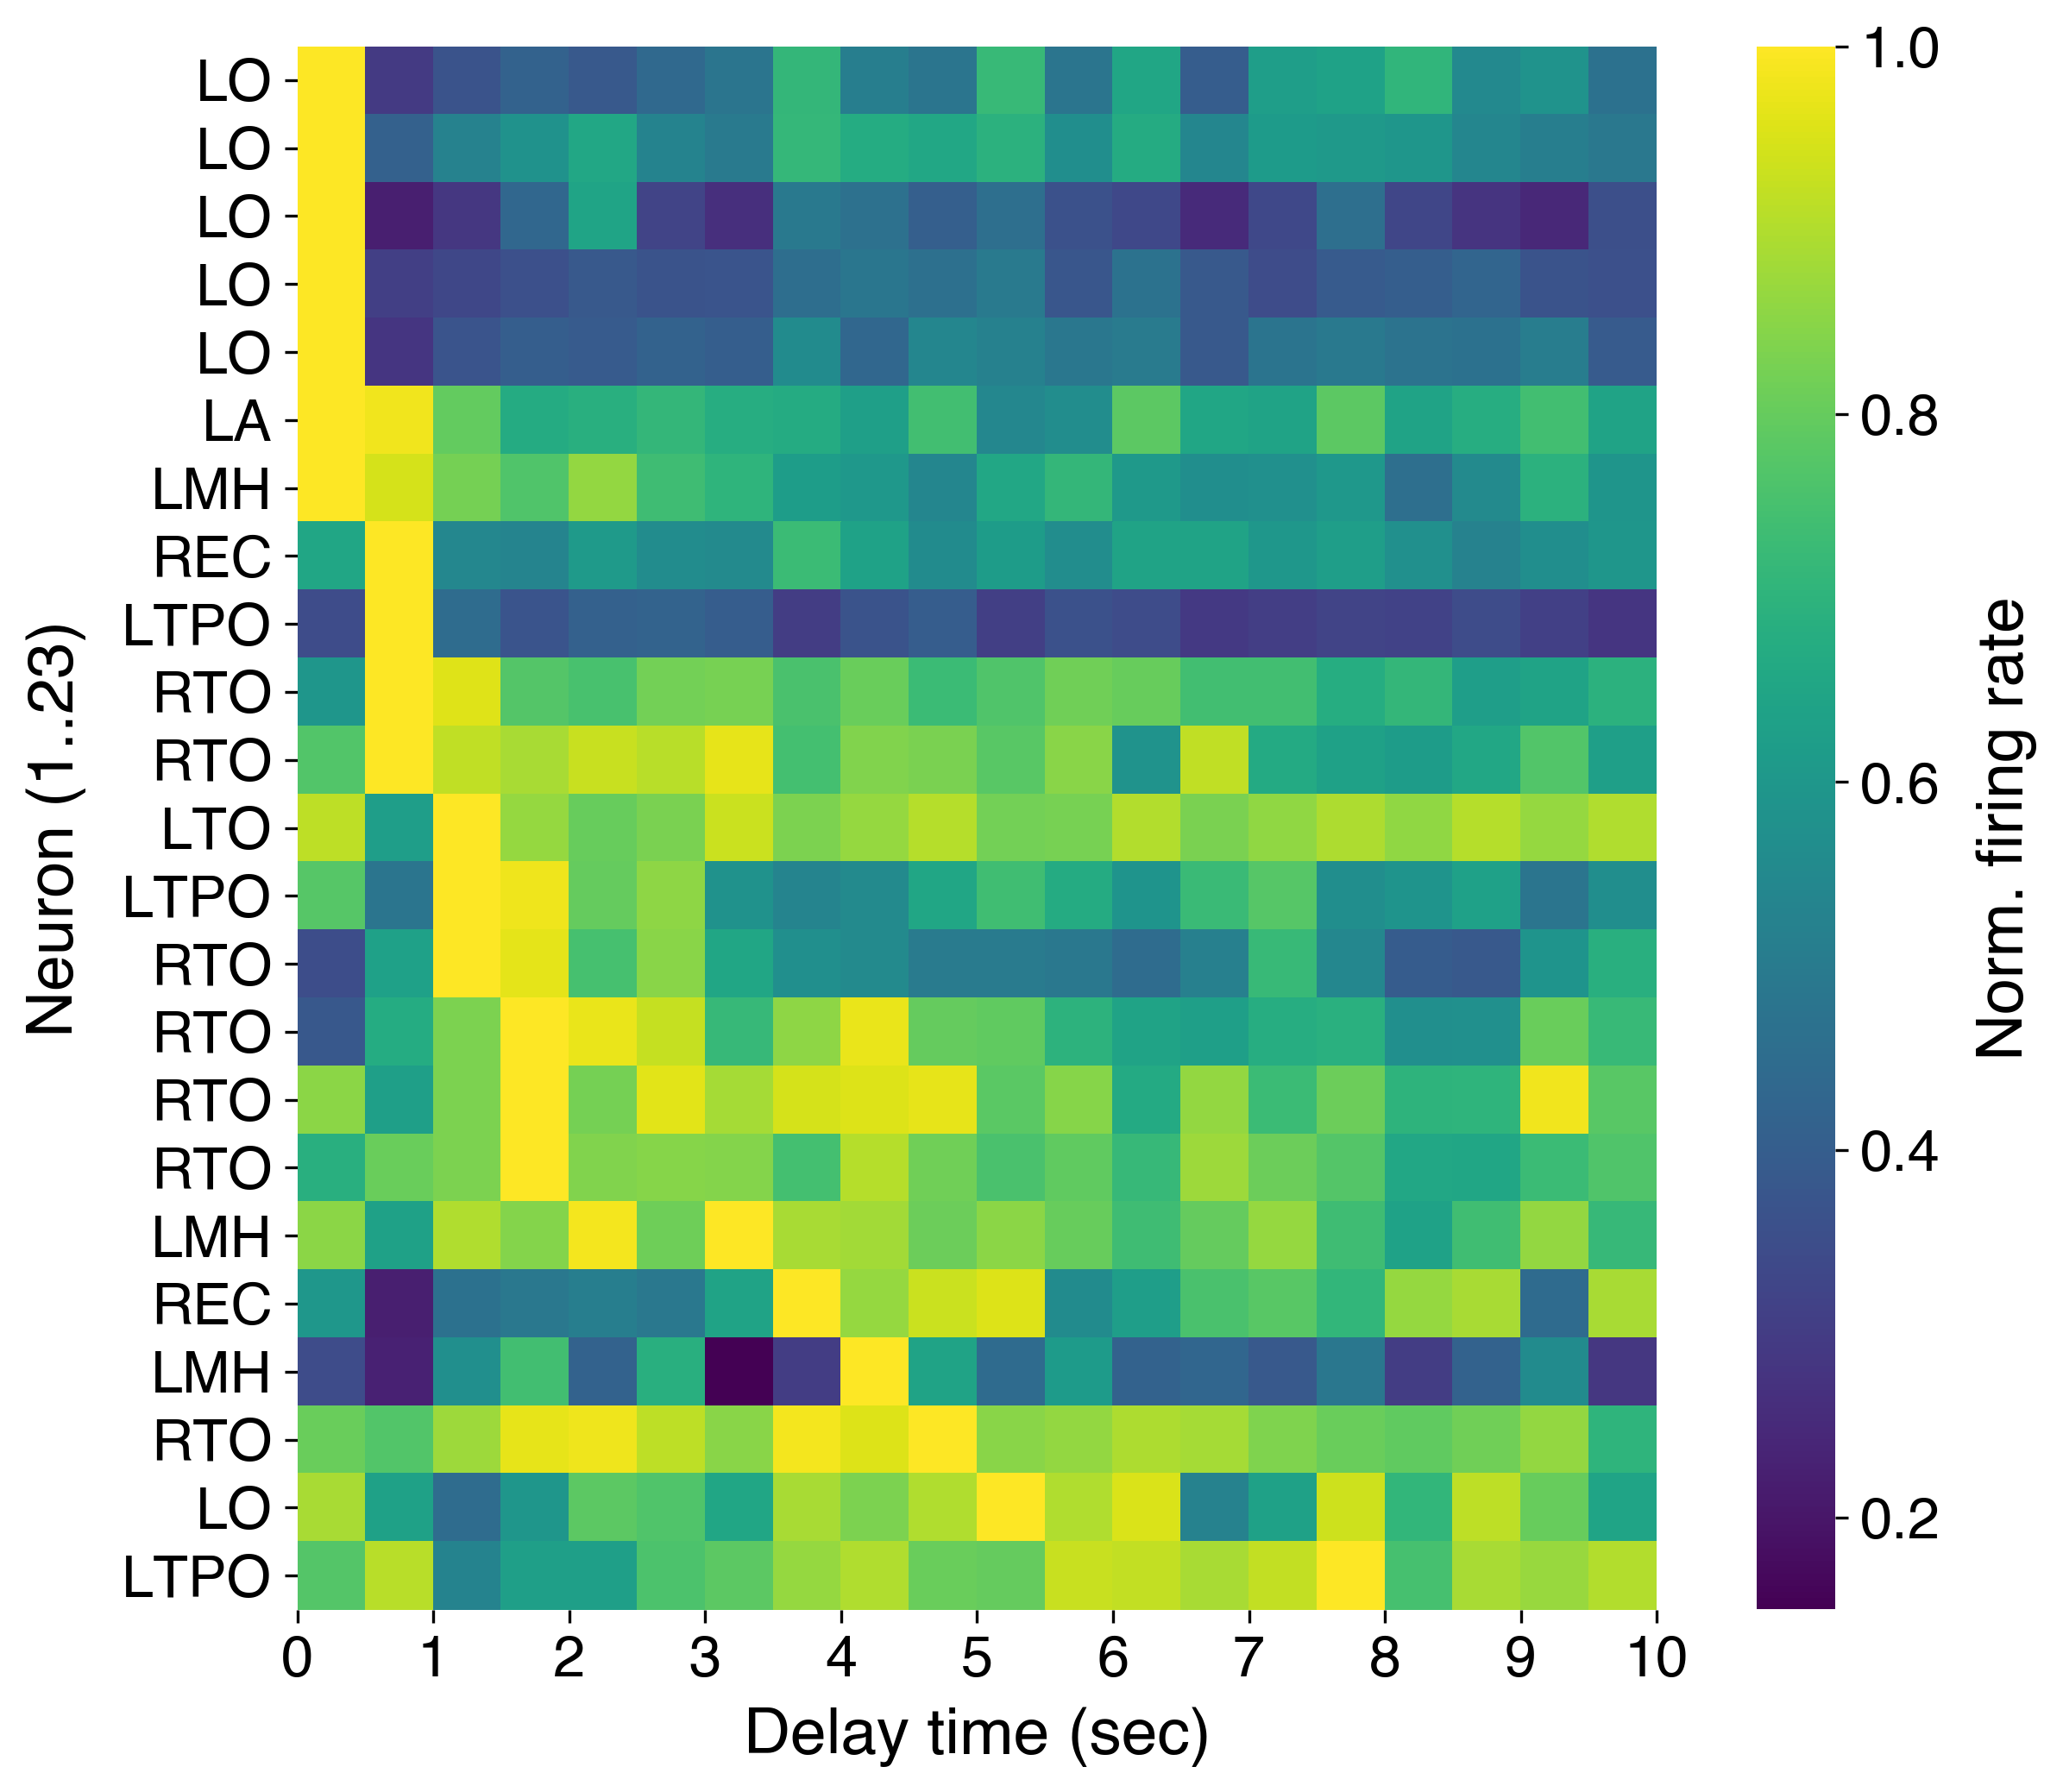

In [92]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
xtrial_delay_spikes = np.sum(delay_spikes[sig_cells_delay, :, :], axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=-1))]

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, vmin=0.15, vmax=1, cmap='viridis', cbar=True, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spike_dat.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

min=0.22


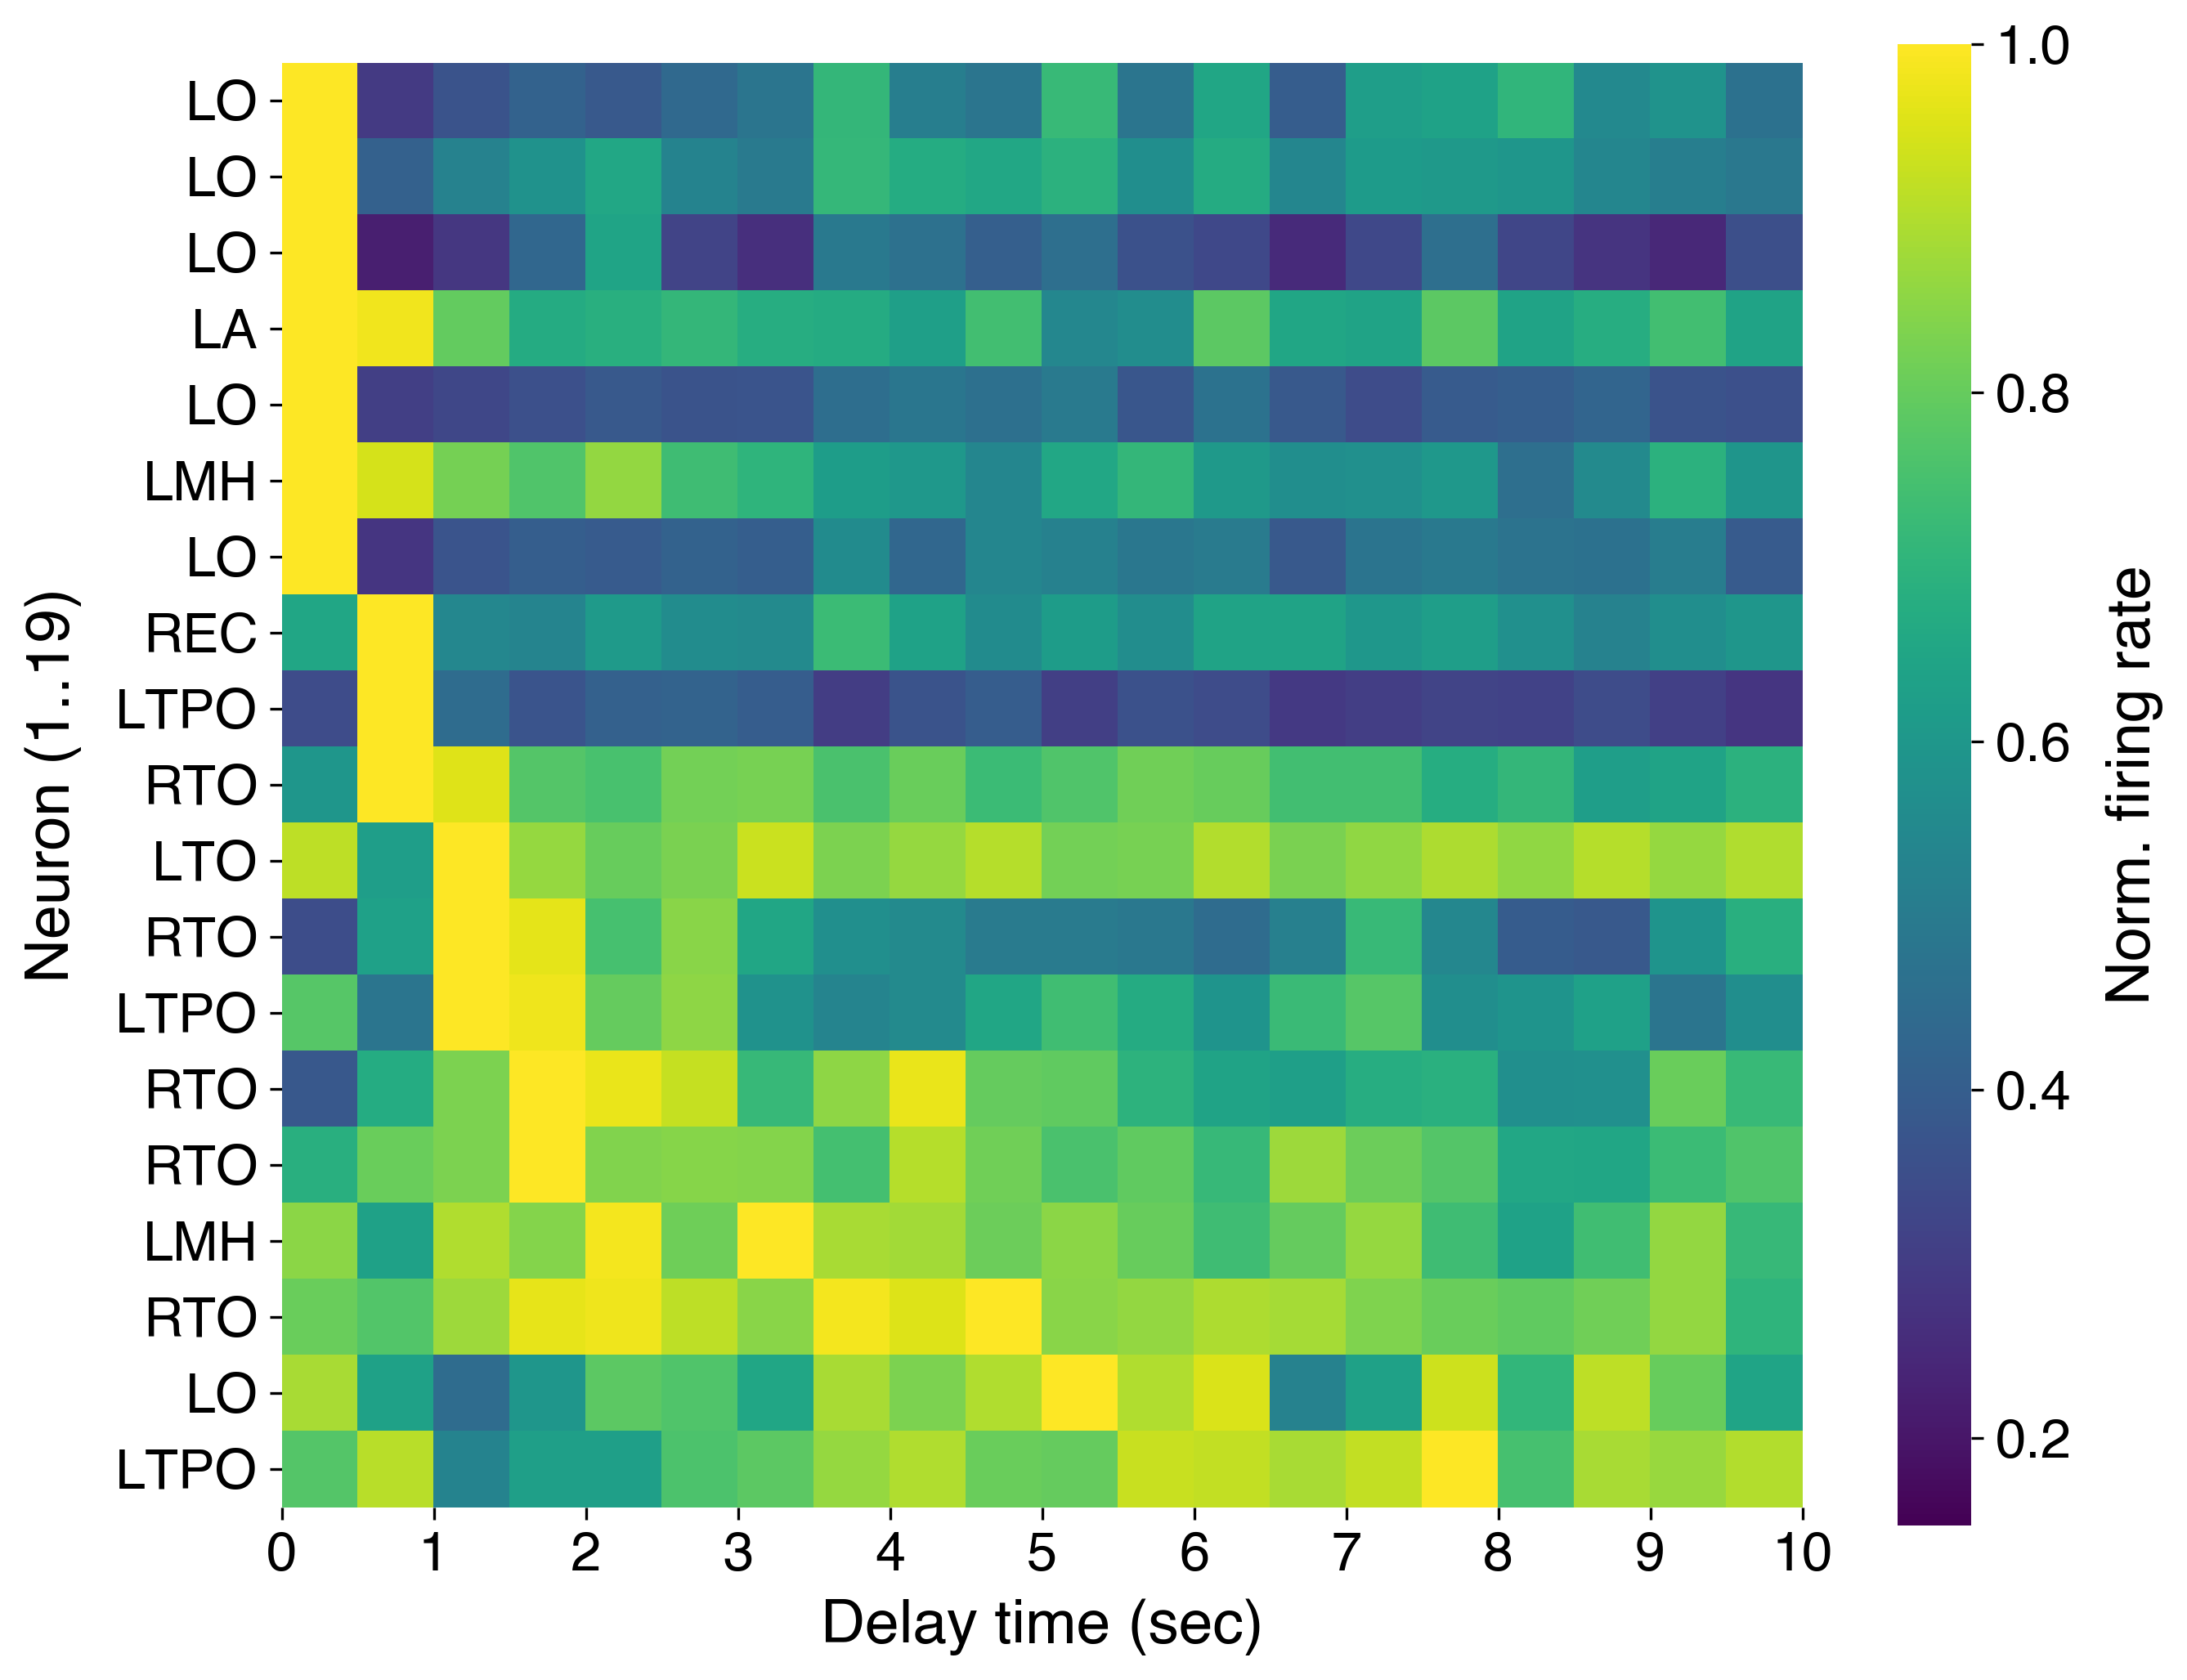

In [447]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
sig_cells_delay = np.array(anova_results.query("(time_sig_fdr==True)")['iUnit'].tolist())
xtrial_delay_spikes = np.sum(delay_spikes[sig_cells_delay, :, :], axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=-1))]

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, vmin=0.15, vmax=1, cmap='viridis', cbar=True, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spike_dat.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

In [448]:
anova_results.query("(trial_phase_sig_fdr==True)")

iUnit     ixn_F     ixn_p    time_F    time_p  trial_phase_F  \
2       2  0.570434  0.928395  0.835867  0.664759       8.699870   
3       3  0.763029  0.753167  1.283317  0.184150       9.051200   
11     11  0.892597  0.592607  1.661416  0.036404      10.913950   
32     32  1.050913  0.397812  3.360619  0.000001      18.640267   
36     36  0.936480  0.536632  0.812901  0.693372       8.305060   
52     52  0.805710  0.702206  2.118375  0.003347       9.648920   
54     54  1.402538  0.115388  1.501472  0.075784      11.081701   

    trial_phase_p  ixn_sig_fdr  time_sig_fdr  trial_phase_sig_fdr  
2        0.003234        False         False                 True  
3        0.002671        False         False                 True  
11       0.000978        False         False                 True  
32       0.000017        False          True                 True  
36       0.004013        False         False                 True  
52       0.001932        False          True                 True  
54       0.000894        False         False                 True

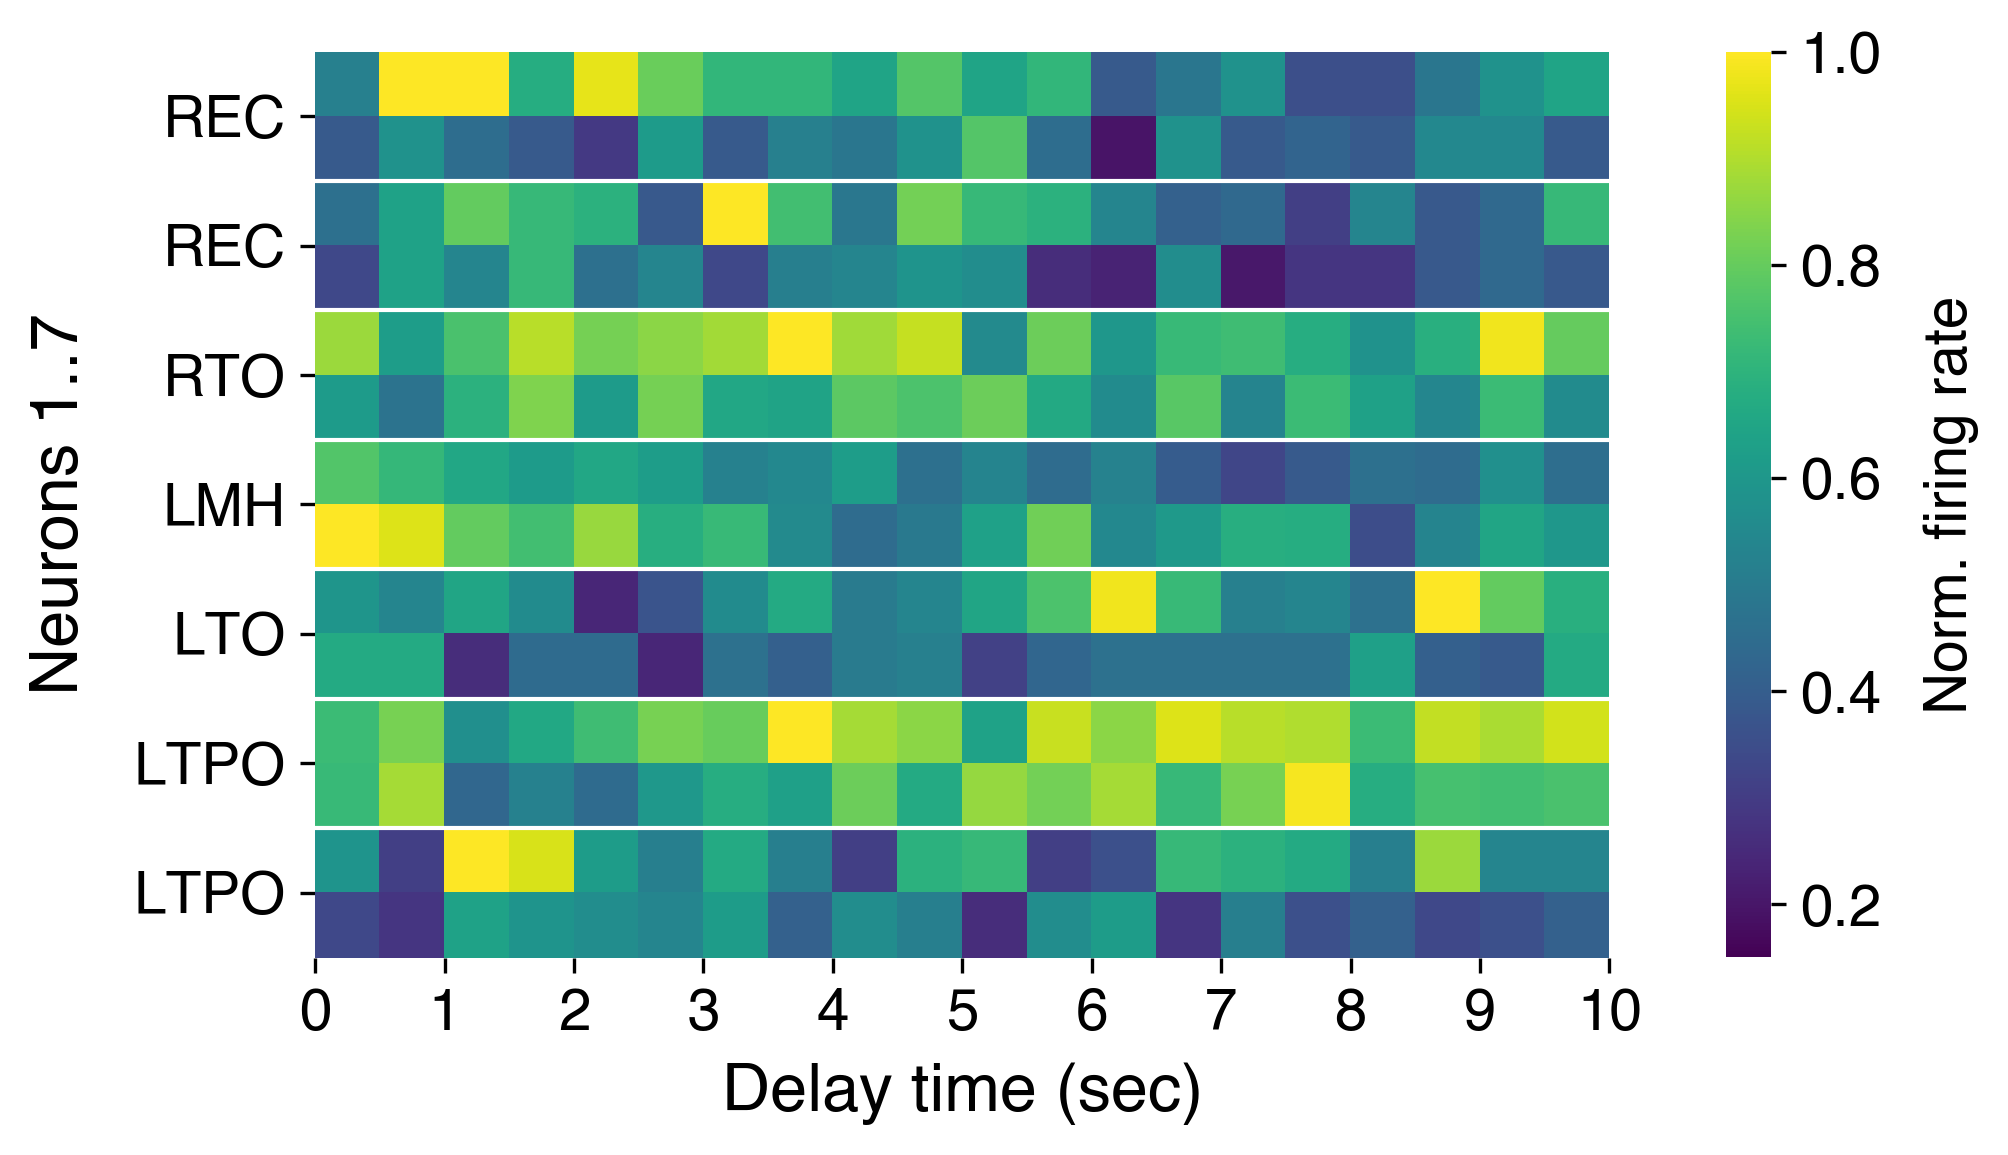

In [461]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
sig_cells_delay = np.array(anova_results.query("(trial_phase_sig_fdr==True)")['iUnit'].tolist())
xtrial_delay_spikes = []
for iUnit in sig_cells_delay:
    dat = np.vstack((np.sum(delay_spikes[iUnit, ::2, :], axis=0), 
                     np.sum(delay_spikes[iUnit, 1::2, :], axis=0)))
    dat = dat / np.max(dat)
    xtrial_delay_spikes.append(dat[0, :])
    xtrial_delay_spikes.append(dat[1, :])
xtrial_delay_spikes = np.array(xtrial_delay_spikes)
dat = xtrial_delay_spikes

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 16

i = 0
ax[i] = sns.heatmap(dat, vmin=0.15, vmax=1, cmap='viridis', cbar=True, square=True, ax=ax[i])
for iRow in range(len(sig_cells_delay)-1):
    ax[i].axhline(y=2*iRow+2, color='w', linewidth=1, alpha=1)
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])[::2]+1)
ax[i].set_yticklabels(spike_dat.iloc[sig_cells_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neurons 1..{}'.format(len(sig_cells_delay)), fontsize=labelfontsize, labelpad=10)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=tickfontsize)

In [462]:
sig_cells_delay

array([ 2,  3, 11, 32, 36, 52, 54])

In [467]:
anova_results.query("iUnit=={}".format(list(sig_cells_delay)))

iUnit     ixn_F     ixn_p    time_F    time_p  trial_phase_F  \
2       2  0.570434  0.928395  0.835867  0.664759       8.699870   
3       3  0.763029  0.753167  1.283317  0.184150       9.051200   
11     11  0.892597  0.592607  1.661416  0.036404      10.913950   
32     32  1.050913  0.397812  3.360619  0.000001      18.640267   
36     36  0.936480  0.536632  0.812901  0.693372       8.305060   
52     52  0.805710  0.702206  2.118375  0.003347       9.648920   
54     54  1.402538  0.115388  1.501472  0.075784      11.081701   

    trial_phase_p  ixn_sig_fdr  time_sig_fdr  trial_phase_sig_fdr  
2        0.003234        False         False                 True  
3        0.002671        False         False                 True  
11       0.000978        False         False                 True  
32       0.000017        False          True                 True  
36       0.004013        False         False                 True  
52       0.001932        False          True                 True  
54       0.000894        False         False                 True

In [468]:
spike_dat.head()

subj_sess  subj  sess  chan  unit  \
0  U518_ses0  U518  ses0     2     1   
1  U518_ses0  U518  ses0     4     1   
2  U518_ses0  U518  ses0     5     1   
3  U518_ses0  U518  ses0     6     1   
4  U518_ses0  U518  ses0     7     1   

                                         spike_times  n_spikes        fr  \
0  [3010.4333333333334, 3178.066666666667, 4154.3...      2832  0.581932   
1  [62.36666666666667, 71.53333333333335, 82.3666...     42469  8.726716   
2  [4192.1, 4193.933333333334, 8277.7, 9955.26666...      4631  0.951598   
3  [57.53333333333334, 3679.2333333333336, 4037.0...      5454  1.120712   
4  [417.1, 803.4333333333334, 821.1666666666667, ...      4190  0.860980   

  hemroi  
0    REC  
1    REC  
2    REC  
3    REC  
4    REC

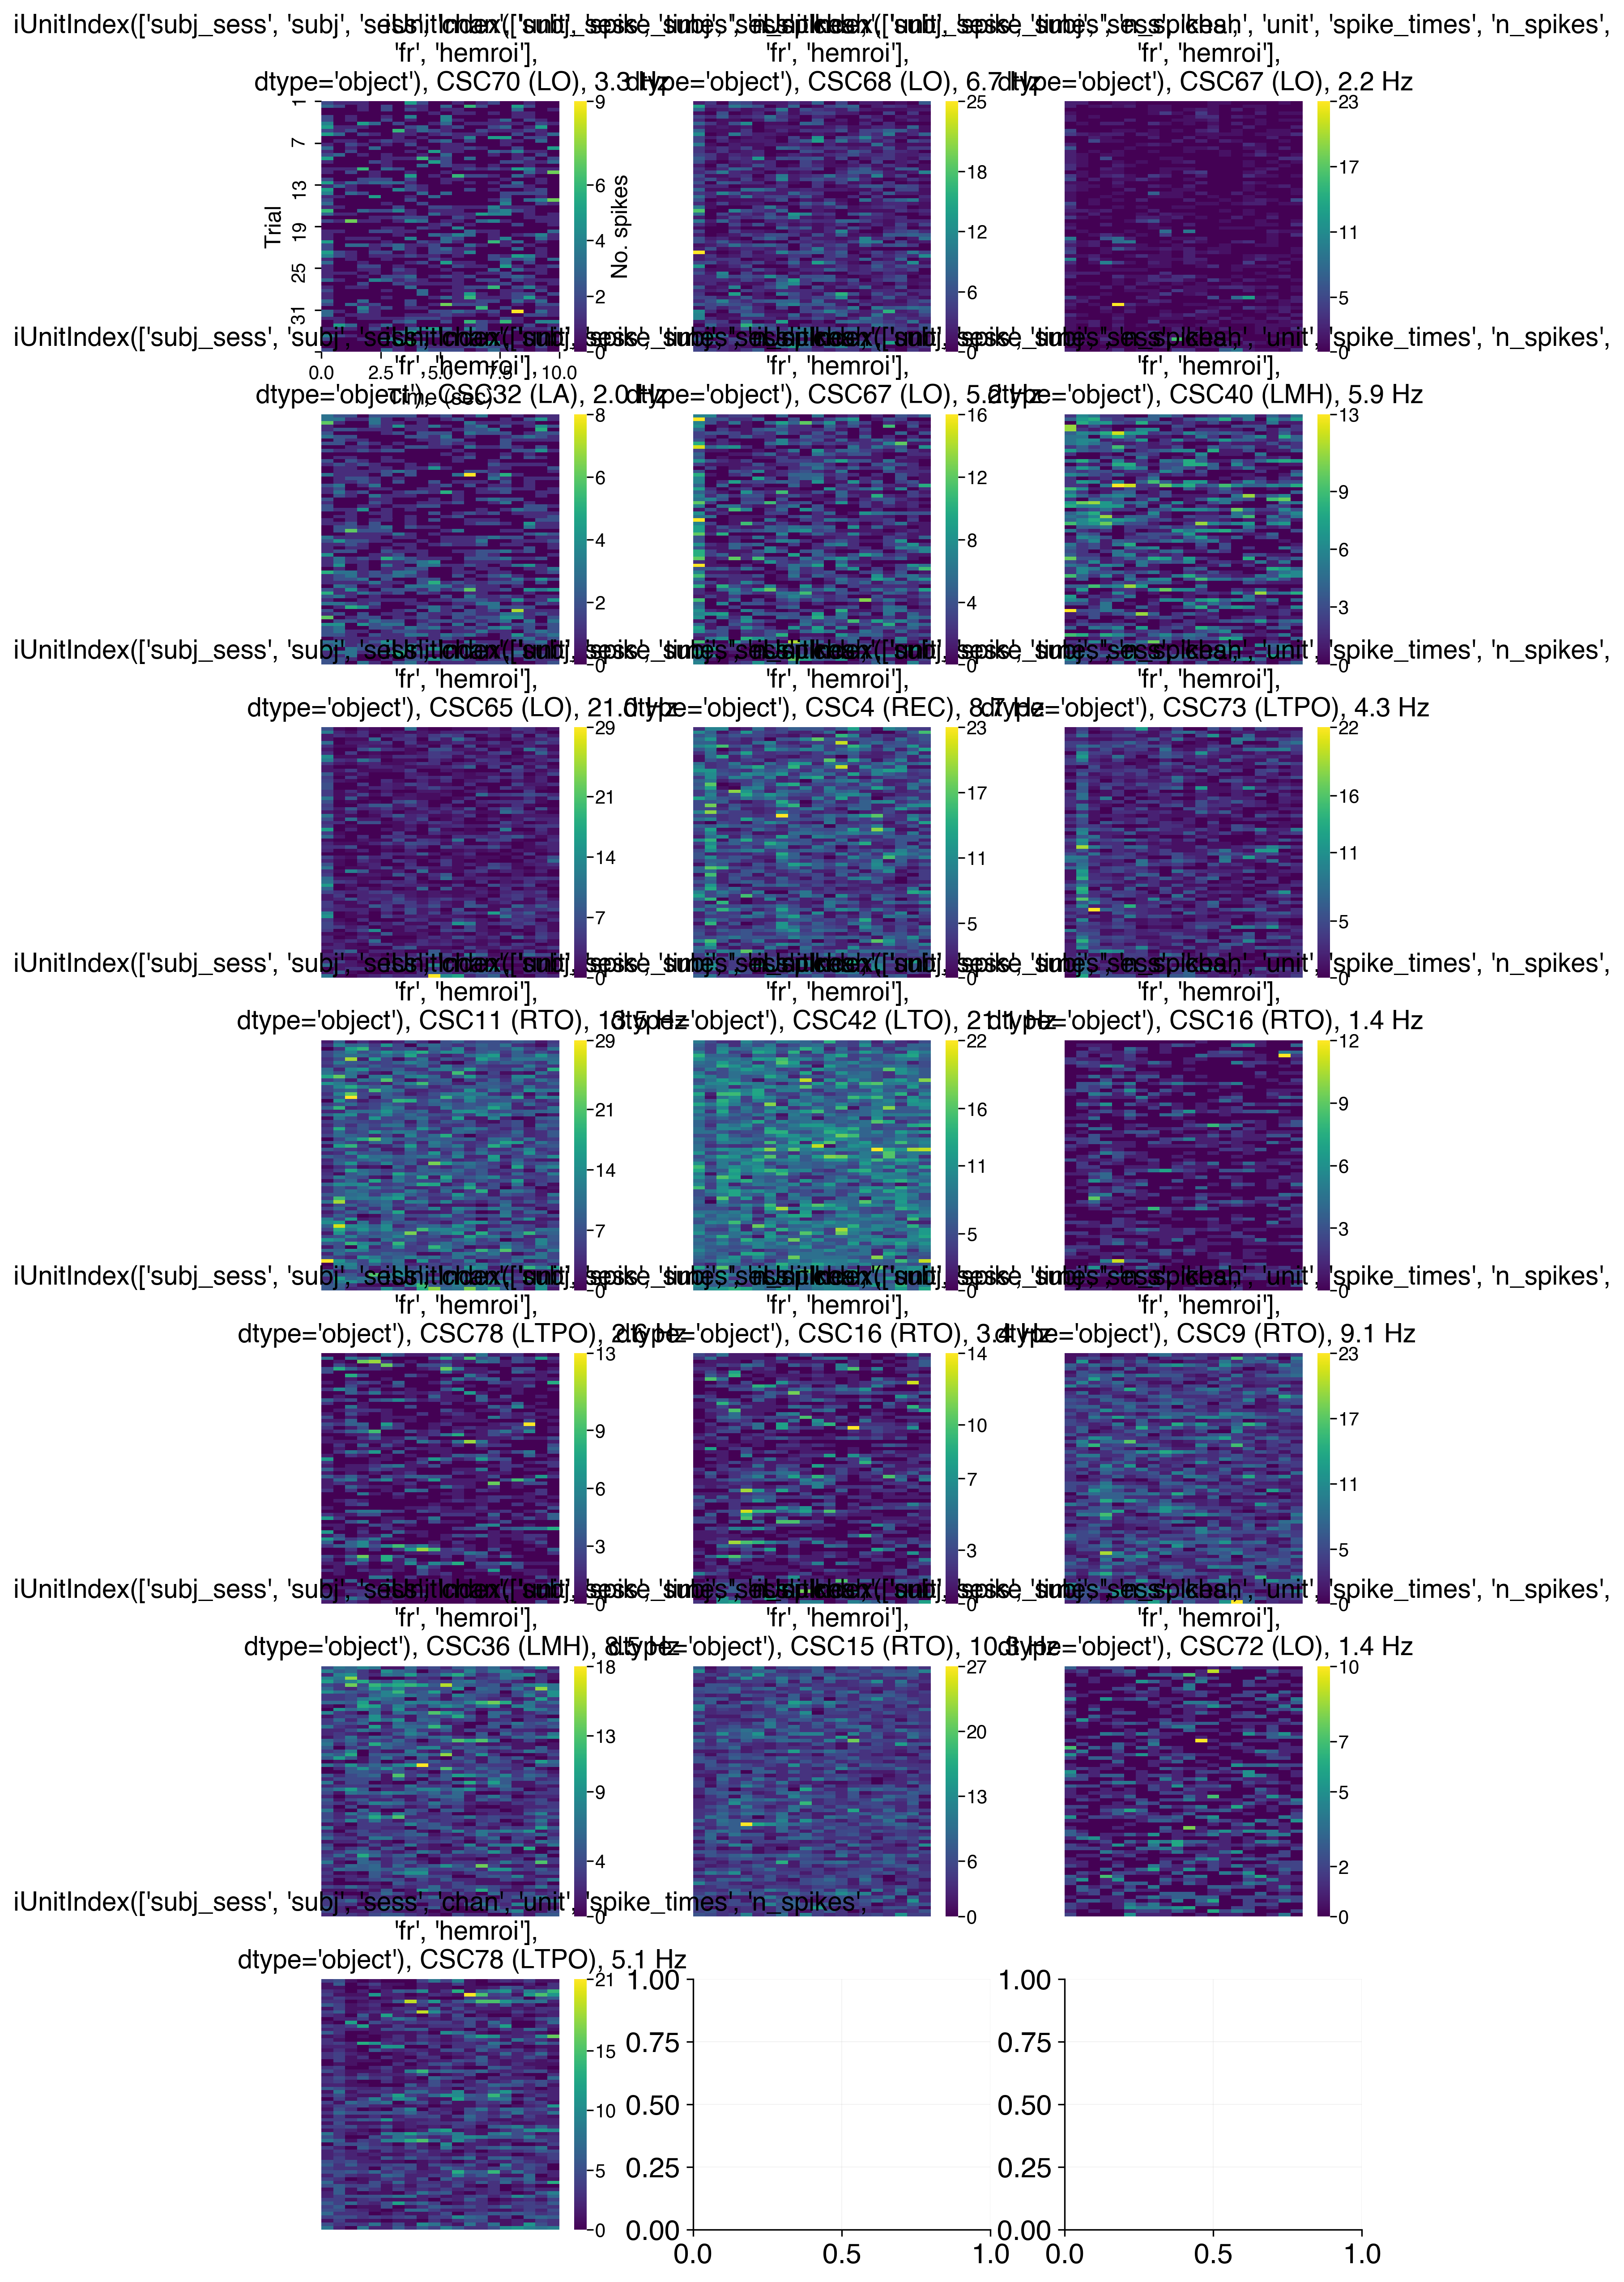

In [469]:
fig, ax = plt.subplots(7, 3, figsize=(10, 21), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

for i in range(len(show_units_delay)):
    ax[i] = sns.heatmap(delay_spikes[show_units_delay[i], :, :], cmap='viridis', square=False, ax=ax[i])
    ax[i].set_title('iUnit{}, CSC{} ({}), {:.1f} Hz'.format(spike_dat.iloc[show_units_delay[i]].index, 
                                                            spike_dat.iloc[show_units_delay[i]]['chan'], 
                                                            spike_dat.iloc[show_units_delay[i]]['hemroi'],
                                                            spike_dat.iloc[show_units_delay[i]]['fr']), fontsize=figfontsize, y=1.05)
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
    vmin = np.min(delay_spikes[show_units_delay[i], :, :])
    vmax = np.max(delay_spikes[show_units_delay[i], :, :])
    cbar.set_ticks(np.linspace(int(vmin), int(vmax), 5, dtype=int))
    cbar.set_ticklabels(np.linspace(int(vmin), int(vmax), 5, dtype=int))
    
    if i > 0:
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    if i == 0:
        ax[i].set_xticks(np.linspace(0, 20, 5))
        ax[i].set_xticklabels(np.linspace(0, 10, 5), fontsize=tickfontsize)
        ax[i].set_yticks(np.linspace(0, 72, 7))
        ax[i].set_yticklabels([str(x) for x in np.arange(1, 37, 6)], fontsize=tickfontsize)
        ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=3)
        ax[i].set_ylabel('Trial', fontsize=labelfontsize, labelpad=3)
        cbar.set_label('No. spikes', fontsize=labelfontsize, labelpad=3)

fig.tight_layout(pad=0.5)

---
---

## Perform ses1 alignment

In [271]:
subj_sess = 'U518_ses1'
data_dir = '/scratch/dscho/time_cells/data'
analysis_dir = '/scratch/dscho/time_cells/analysis'
sampling_rate = 30000

# --------------------------------------

# Get subject directories.
subj, sess = subj_sess.split('_')
subj_dir = os.path.join(data_dir, subj, sess)
events_dir = os.path.join(subj_dir, 'events')
spikes_dir = os.path.join(subj_dir, 'spikes', 'wave_clus3_autosort')
micros_dir = os.path.join(subj_dir, 'micro_lfps')
sync_dir = os.path.join(subj_dir, 'sync')
sr = sampling_rate

In [273]:
# Get event timestamps in ms.
events = read_json(os.path.join(events_dir, 'events.jsonl'))
events = events[['time', 'type', 'data']].rename(columns={'type': 'key', 'data': 'value'})
events['time'] = (events['time'] - events.at[0, 'time'])
event_synctimes = events.loc[events.key=='syncPulse', 'time'].values
print('{} events recorded over {} min and {} sec'.format(len(events), int(events.iloc[-1]['time']/60000), int((events.iloc[-1]['time']%60000)/1000)))

# Get LFP timestamps, convert sec to ms,
# and subtract the first timestamp from all timestamps
try:
    lfp_timestamps = np.squeeze(sio.loadmat(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'))['timeStamps'])
except NotImplementedError:
    with h5py.File(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'), 'r') as f:
        lfp_timestamps = np.squeeze(f['timeStamps'])
lfp_timestamps = lfp_timestamps * 1e3
# lfp_timestamps = lfp_timestamps - lfp_timestamps[0]
session_length = (lfp_timestamps[-1] - lfp_timestamps[0]) * 1e-3 # in sec
print('session length is {} min and {} sec'.format(int(session_length/60), int(session_length%60)))

# Load the sync channel data (sampled at 2000 Hz for U515_ses0)
# and convert the analog signal into sync start indices.
try:
    sync_chan = np.squeeze(sio.loadmat(os.path.join(sync_dir, 'sync_channel_micro.mat'))['data'])
except NotImplementedError:
    with h5py.File(os.path.join(sync_dir, 'sync_channel_micro.mat'), 'r') as f:
        sync_chan = np.squeeze(f['data'])
print('{} lfp timestamps and {} sync channel datapoints (should be equal)'.format(len(lfp_timestamps), len(sync_chan)))
pulse_startinds = find_pulse_starts(sync_chan)

# Get the LFP time in ms for each sync pulse event.
lfp_synctimes = lfp_timestamps[pulse_startinds]

print('{} event sync pulses'.format(len(event_synctimes)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes)))

min_syncs = np.min((len(event_synctimes), len(lfp_synctimes)))
min_syncs = np.min((len(event_synctimes), len(lfp_synctimes)))
offsets = np.arange(-(min_syncs-1), (min_syncs-1))
rvals = []
for offset in offsets:
    rvals.append(stats.pearsonr(np.roll(np.diff(lfp_synctimes[:min_syncs]), offset), np.diff(event_synctimes[:min_syncs]))[0])
shift_by = offsets[np.argmax(rvals)]
shift_time = lfp_synctimes[0] - np.roll(lfp_synctimes[:min_syncs], shift_by)[0]

print('Shift by: {}, Best r: {:.3f}'.format(shift_by, np.max(rvals)))

83529 events recorded over 110 min and 25 sec
session length is 62 min and 19 sec
112193616 lfp timestamps and 112193616 sync channel datapoints (should be equal)
6618 event sync pulses
3745 LFP sync pulses identified
Shift by: -111, Best r: 0.906


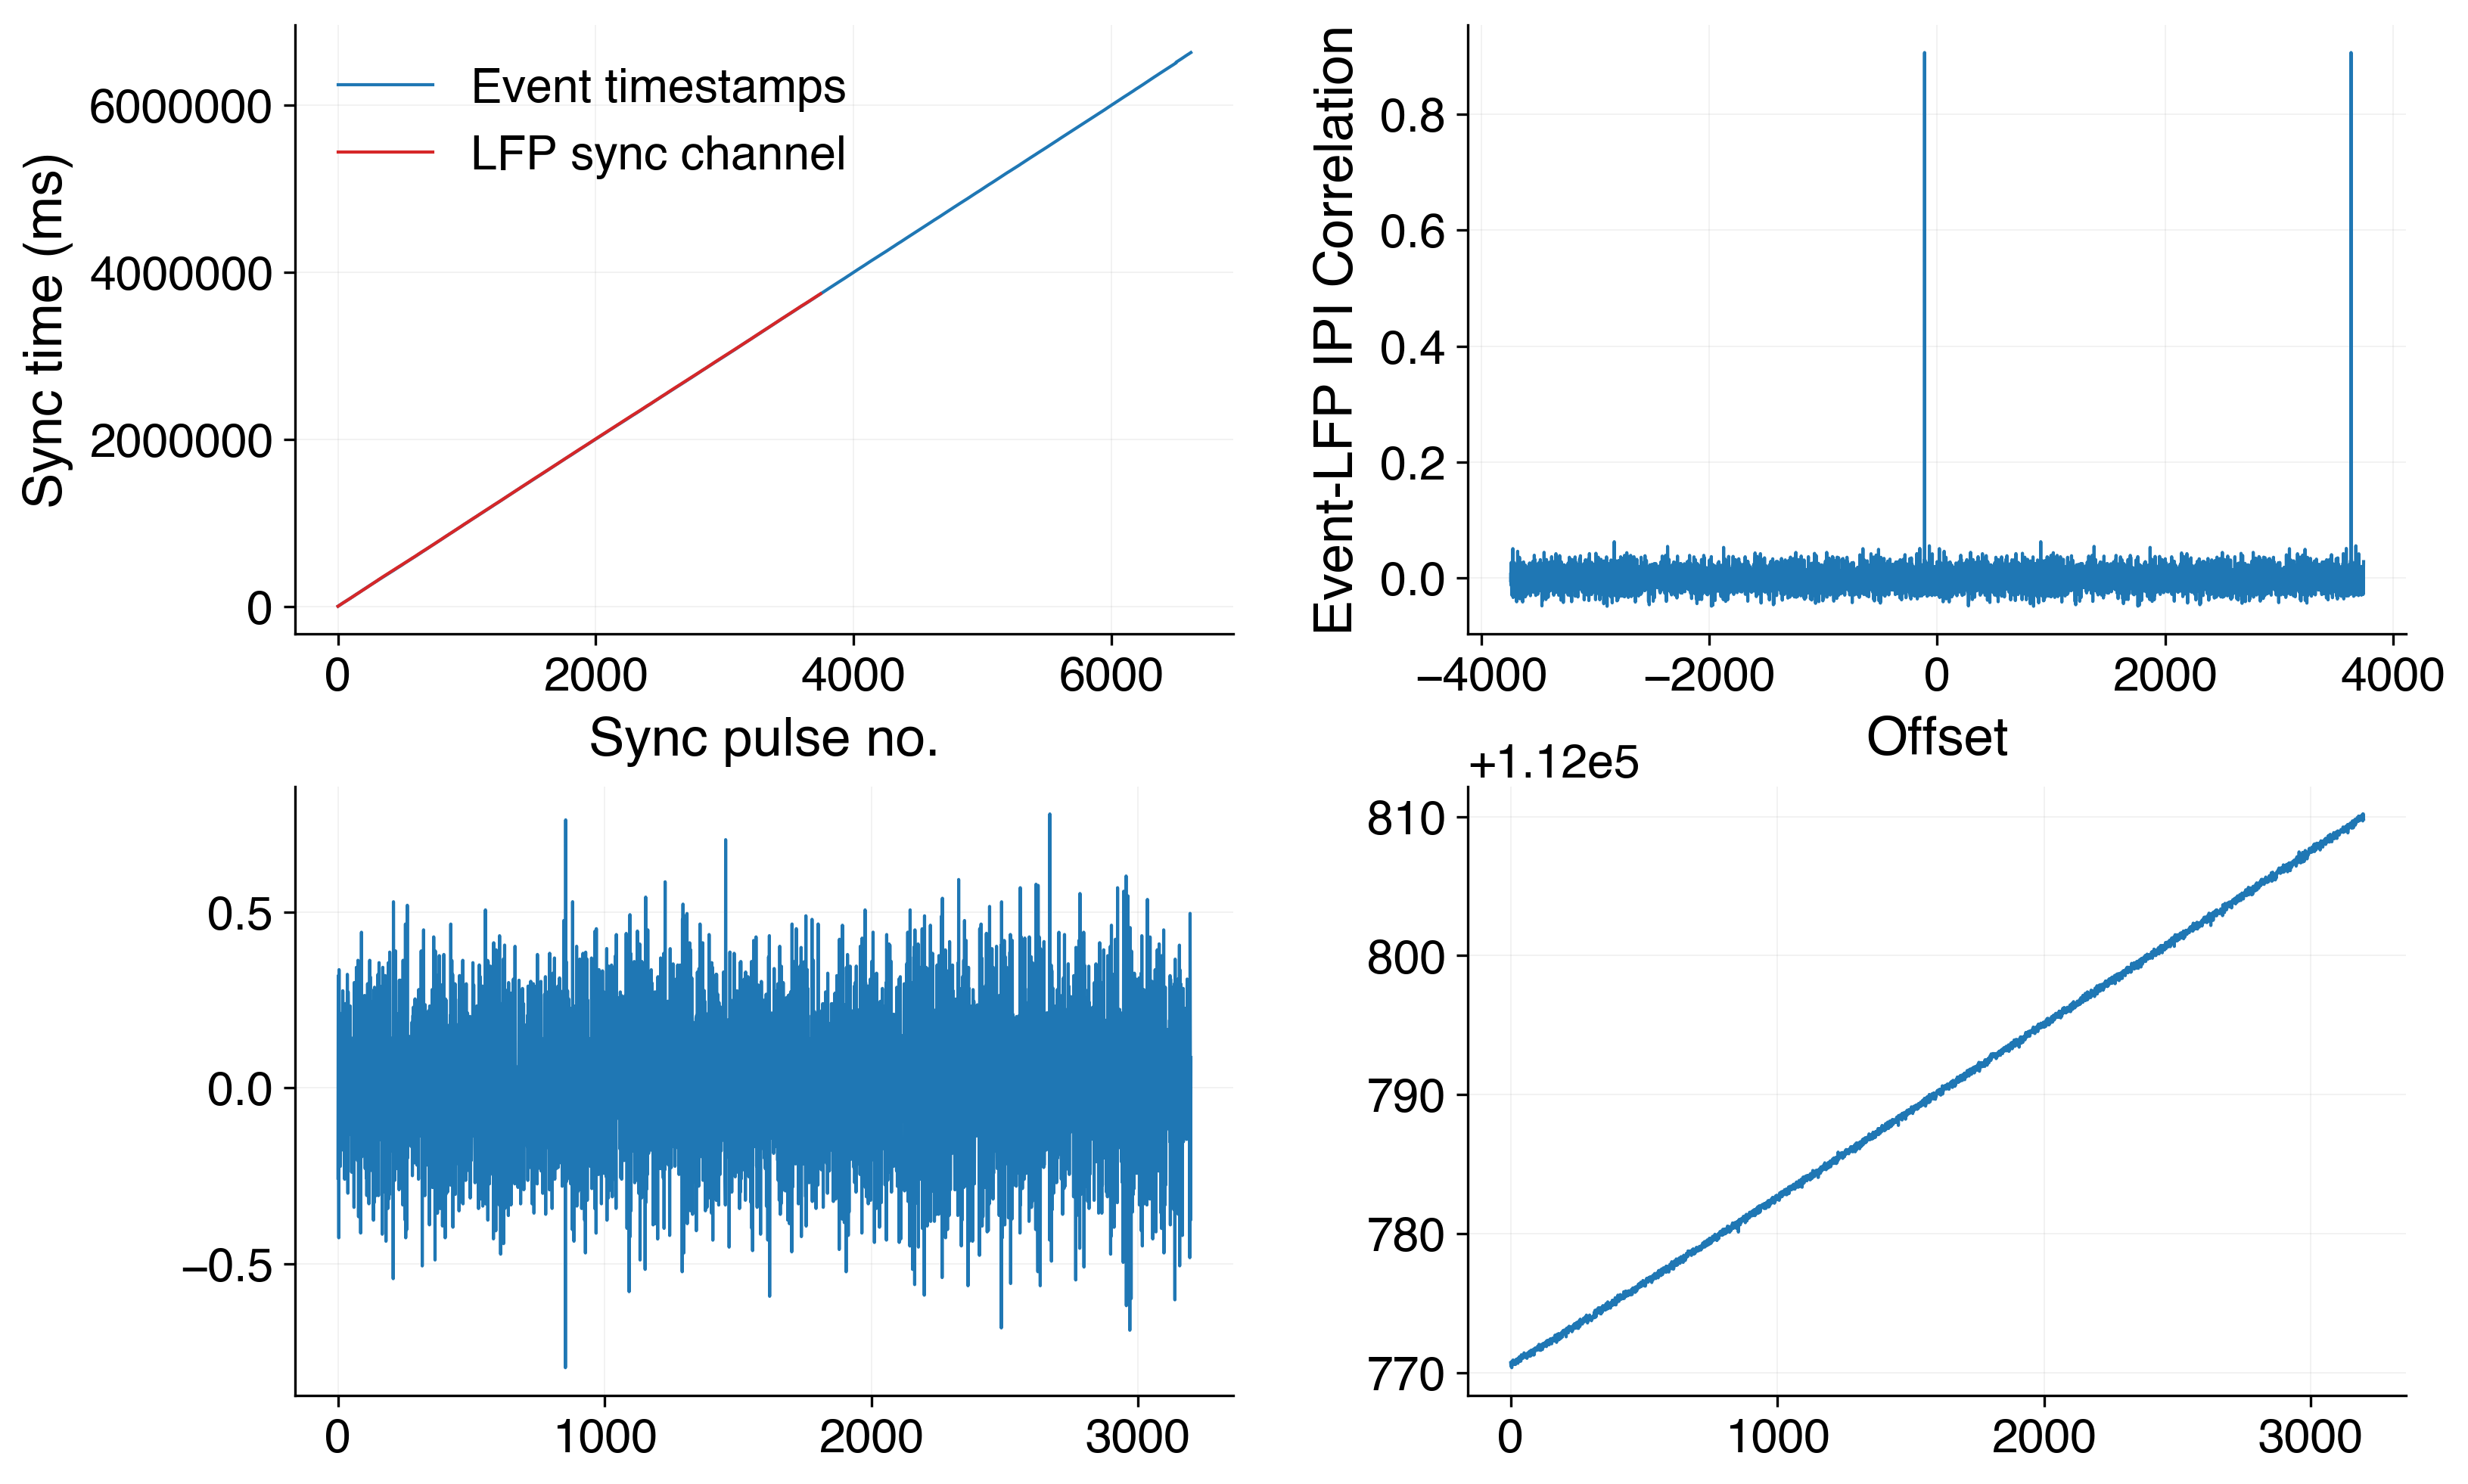

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i].plot(np.arange(len(event_synctimes)), event_synctimes, color='C0', label='Event timestamps')
ax[i].plot(np.arange(len(lfp_synctimes)), lfp_synctimes, color='C1', label='LFP sync channel')
ax[i].set_xlabel('Sync pulse no.', labelpad=5)
ax[i].set_ylabel('Sync time (ms)', labelpad=5)
ax[i].legend(loc=2)

i = 1
ax[i].plot(offsets, rvals)
ax[i].set_xlabel('Offset', labelpad=5)
ax[i].set_ylabel('Event-LFP IPI Correlation', labelpad=5)

i = 2
start = 300
stop = 3500
ax[i].plot(np.roll(np.diff(lfp_synctimes[:min_syncs]), shift_by)[start:stop] - np.diff(event_synctimes[:min_syncs])[start:stop])

i = 3
ax[i].plot(np.roll(lfp_synctimes[:min_syncs], shift_by)[start:stop] - event_synctimes[:min_syncs][start:stop])

In [274]:
# Align events to LFP.
sync_params, before_stats, after_stats = align_sync_pulses(event_synctimes[:min_syncs][start:stop], 
                                                           np.roll(lfp_synctimes[:min_syncs], shift_by)[start:stop], 
                                                           good_fit_thresh_ms=None)

# Define the intercept as the difference between the first LFP sync time 
# and the first events sync time that we are aligning
intercept = np.roll(lfp_synctimes[:min_syncs], shift_by)[start:stop][0] - event_synctimes[:min_syncs][start:stop][0]

# Apply the alignment to all event times.
# events['time_aligned'] = events['time'].apply(lambda x: 0 + (sync_params['slope'] * x))
events['time'] = events['time'].apply(lambda x: 112766.5349958418 + (sync_params['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes)))
print('\n--------------------\nAlignment parameters\n--------------------')
print('Intercept: {}\nSlope: {}'.format(sync_params['intercept'], sync_params['slope']))
print('Before alignment r={:.4f}, RMSE={:.4f} ms,\n|Error| percentiles:\n{}'
      .format(before_stats['r'], before_stats['rmse'], before_stats['err_pcts']))
print('After alignment r={:.4f}, RMSE={:.4f} ms,\n|Error| percentiles:\n{}'
      .format(after_stats['r'], after_stats['rmse'], after_stats['err_pcts']))
print(rmse(events.loc[events.key=='syncPulse', 'time'][:min_syncs][start:stop], lfp_synctimes[:min_syncs][start:stop]))
print(stats.pearsonr(np.diff(events.loc[events.key=='syncPulse', 'time'][:min_syncs][start:stop]), 
                     np.diff(lfp_synctimes[:min_syncs][-shift_by+start:-shift_by+stop])))
print(rmse(events.loc[events.key=='syncPulse', 'time'][:min_syncs][start:stop], lfp_synctimes[:min_syncs][-shift_by+start:-shift_by+stop]))
print(rmse(events.loc[events.key=='syncPulse', 'time'][-shift_by:-shift_by+min_syncs][start:stop], 
           lfp_synctimes[-shift_by:-shift_by+min_syncs][-shift_by+start:-shift_by+stop]))

Best IPI fit ind: 30 (shift=0), RMSE=0.22 ms
6618 event sync pulses
3745 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
Intercept: 112770.27631041144
Slope: 1.0000124185005053
Before alignment r=1.0000, RMSE=112790.1033 ms,
|Error| percentiles:
0      112770.359912
1      112770.999998
5      112772.346484
10     112774.273348
25     112780.150789
50     112790.059937
75     112800.014164
90     112806.004102
95     112808.037065
99     112809.650104
100    112810.193441
dtype: float64
After alignment r=1.0000, RMSE=3.7455 ms,
|Error| percentiles:
0      3.191047
1      3.358182
5      3.463322
10     3.519404
25     3.613026
50     3.729976
75     3.878201
90     3.975563
95     4.022093
99     4.110306
100    4.487188
dtype: float64
110779.71359327863
(0.9999981809253037, 0.0)
0.17676375931656035
0.1707154773111886


## Format ses1 events

In [143]:
experiment_scene = 'SimpleMaze'

# ----------------------------------
# Add column for scene.
events['scene'] = fill_column(events, 'loadScene', 'sceneName', fill_back=False)

# Get the main experiment events (dropping the tutorial events).
events = events.loc[events['scene']==experiment_scene].reset_index(drop=True).copy()

# Add column for game states.
events['gameState'] = fill_column(events, 'gameState', 'stateName', fill_back=False)

# Add column for trial.
events['trial'] = 0
trial_inds = get_trial_inds(events)
for trial, inds in trial_inds.items():
    events.loc[inds, 'trial'] = trial

# Add whether each trial has a time penalty or not. (-1 means we could not resolve.)
events['time_penalty'] = -1
for trial, has_penalty in {x['trial']:x['value']['isTimedTrial'] 
                           for idx, x in events.query("(key=='timedTrial')").iterrows()}.items():
    events.loc[events['trial']==trial, 'time_penalty'] = 1 if has_penalty else 0
    
# Reorder columns.
events = events[['time', 'key', 'value', 'scene', 'trial', 'time_penalty', 'gameState']]

# Distinguish between pre-encoding delays (Delay1)
# and pre-retrieval delays (Delay2),
# and between post-encoding returns to base (ReturnToBase1)
# and post-retrieval returns to base (ReturnToBase2)
for trial in range(1, events['trial'].max()+1):
    for game_state in ['Delay', 'ReturnToBase']:
        inds = events.loc[(events['trial']==trial) & (events['gameState']==game_state)].index.tolist()
        sep = np.where(np.diff(inds)>1)[0]
        assert len(sep) == 1
        events.loc[(events.index.isin(inds[:sep[0]+1])) & 
                   (events['trial']==trial) & 
                   (events['gameState']==game_state), 'gameState'] = game_state + '1'
        events.loc[(events.index.isin(inds[sep[0]+1:])) & 
                   (events['trial']==trial) & 
                   (events['gameState']==game_state), 'gameState'] = game_state + '2'
        
print(events.shape)

(83529, 7)


In [144]:
# Take note of which trial periods should be thrown out.
events['bad_trials'] = ''

# Flag incomplete trials.
check_game_states = ['InitTrial', 'Delay1', 'Encoding', 'ReturnToBase1',
                     'Delay2', 'Retrieval', 'ReturnToBase2', 'DoNextTrial']
events.loc[(events['trial']==0), 'bad_trials'] = 'incomplete'
for trial in range(1, events['trial'].max()+1):
    game_states = list(events.loc[(events['trial']==trial), 'gameState'].unique())
    if not np.all([x in game_states for x in check_game_states]):
        events.loc[(events['trial']==trial), 'bad_trials'] = 'incomplete'

# Flag trial periods with manual pauses.
timed_game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
pause_inds = [idx for idx, row in events.query("(key=='gamePaused')").iterrows() 
              if row['value']['pauseType']=='manualPause']
for idx in pause_inds:
    game_state = events.iloc[idx]['gameState']
    if game_state in timed_game_states:
        events.loc[(events['trial']==trial) & (events['gameState']==game_state), 'bad_trials'] = 'paused'

# Remove bad trial periods.
print('Removing trial periods:\n')
display(events.query("bad_trials!=''").groupby(['trial', 'gameState'])['bad_trials'].apply(lambda x: np.unique(x)))
events = events.loc[events['bad_trials']==''].reset_index(drop=True)
events.shape

Removing trial periods:



trial  gameState  
0      DoNextTrial    [incomplete]
       InitTrial      [incomplete]
Name: bad_trials, dtype: object

(80243, 8)

In [145]:
print('Main experiment has {} events recorded over {} min and {} sec'.format(len(events), 
                                                         int((events.iloc[-1]['time'] - events.iloc[0]['time'])/60000), 
                                                         int(((events.iloc[-1]['time'] - events.iloc[0]['time'])%60000)/1000)))

Main experiment has 80243 events recorded over 60 min and 3 sec


In [106]:
subj_sess = 'U518_ses1'
data_dir = '/scratch/dscho/time_cells/data'
analysis_dir = '/scratch/dscho/time_cells/analysis'
sampling_rate = 30000

# --------------------------------------

# Get subject directories.
subj, sess = subj_sess.split('_')
subj_dir = os.path.join(data_dir, subj, sess)
events_dir = os.path.join(subj_dir, 'events')
spikes_dir = os.path.join(subj_dir, 'spikes', 'wave_clus3_autosort')
micros_dir = os.path.join(subj_dir, 'micro_lfps')
sync_dir = os.path.join(subj_dir, 'sync')
sr = sampling_rate

# Save events!
events_f = os.path.join(analysis_dir, 'events', '{}_events_formatted.pkl'.format(subj_sess))
if os.path.exists(events_f):
    print('Found events')
    events = dio.open_pickle(events_f)
else:
    dio.save_pickle(events, events_f)

Found events


In [114]:
(np.min(events['time']) * 1e-3) / 60, np.min(events['time'])

(1.8794422499306966, 112766.5349958418)

In [155]:
# events.groupby(['trial', 'gameState'], sort=False)['time'].apply(lambda x: [(np.min(x)) * 1e-3, 
#                                                                             (np.max(x)) * 1e-3])

In [142]:
with h5py.File(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'), 'r') as f:
    lfp_timestamps = np.squeeze(f['timeStamps'])
lfp_timestamps = lfp_timestamps * 1e3

In [148]:
lfp_timestamps[-1], len(lfp_timestamps)/30, len(lfp_timestamps)

(3739787.166666667, 3739787.2, 112193616)

In [136]:
print(np.round(3253.61136433 - 3122.71901883, 2), 
      np.round(3253.61136433 - 2458.90783808, 2))

130.89 794.7


In [152]:
73767235/112193616, 97608341/112193616

(0.6574993981832264, 0.8699990648309258)

In [141]:
int(2458.90783808 * 30000), int(3122.71901883 * 30000), int(3253.61136433 * 30000)+1

(73767235, 93681570, 97608341)

In [156]:
3253.61136433 - 3122.71901883

130.89234549999992

In [153]:
# liberal: throw out (0, 60) and (3122.71901883, 3253.61136433) sec, 
#          corresponding to samples (1, 30000) and (93681570, 97608341)
# conservative : throw (0, 60) and (2458.90783808, 3253.61136433) sec, 
#                corresponding to samples (1, 30000) and (73767235, 97608341)
# throw out trial 31 retrieval through end of trial 31
# throw out trials 25-31

## Load ses1 spike data

In [ ]:
# Format wave_clus outputs and generate a spike null distribution.
spikes = format_spikes(subj_sess, fr_thresh=0.1, overwrite=True, save_output=True)
spikes = add_null_to_spikes(spikes, n_perms=1000, save_output=True)

In [476]:
print(np.min(events['time']), np.max(events['time']), (np.max(events['time']) - np.min(events['time'])))
print(np.min(events['time'])/6e4, np.max(events['time'])/6e4, (np.max(events['time']) - np.min(events['time']))/6e4)

112766.5349958418 3716161.2831996377 3603394.748203796
1.8794422499306966 61.93602138666063 60.05657913672993


In [352]:
# Get all spike files for the session.
spike_files = glob(os.path.join(spikes_dir, 'times*.mat'))
print('{} files'.format(len(spike_files)))

# Reorder spike files.
spike_fname = 'times_CSC{}.mat'
spike_files = [os.path.join(spikes_dir, spike_fname.format(chan))
               for chan in range(1, len(spike_files)+1)
               if os.path.exists(os.path.join(spikes_dir, spike_fname.format(chan)))]
print('{} files'.format(len(spike_files)))

94 files
92 files


In [353]:
# Get spike times from all wave_clus single-units.
n_spike_thresh = 0
fr_thresh = 0.1
# ------------------

chans = [int(os.path.basename(f).split('CSC')[1].split('.')[0]) for f in spike_files]
spike_dat = []
for iChan, spike_file in enumerate(spike_files):
    chan = chans[iChan]
    cluster_class = sio.loadmat(spike_file)['cluster_class']
    units = np.unique(cluster_class[:, 0])
    if len(units) > 1:
        for unit in range(1, len(units)):
            spike_times = cluster_class[:, 1][np.where(cluster_class[:, 0]==unit)[0]]
            n_spikes = len(spike_times)
            if n_spikes > n_spike_thresh:
                spike_dat.append([subj_sess, subj, sess, chan, unit, spike_times, n_spikes, n_spikes/session_length])
cols = ['subj_sess', 'subj', 'sess', 'chan', 'unit', 'spike_times', 'n_spikes', 'fr']
spike_dat = pd.DataFrame(spike_dat, columns=cols)
spike_dat = spike_dat.loc[spike_dat['fr']>fr_thresh].reset_index(drop=True)
print(spike_dat.shape)
print(spike_dat['fr'].describe())

(496, 8)
count    496.000000
mean       1.011980
std        1.841650
min        0.100006
25%        0.168793
50%        0.340394
75%        1.060756
max       15.590459
Name: fr, dtype: float64


In [354]:
# Add montage info for U515
def get_hemroi(chan):
    mont = od([('REC', np.arange(1, 9, dtype=int)),
               ('RTO', np.arange(9, 17, dtype=int)),
               ('RIP', np.arange(17, 25, dtype=int)),
               ('LA', np.arange(25, 33, dtype=int)),
               ('LMH', np.arange(33, 41, dtype=int)),
               ('LTO', np.arange(41, 49, dtype=int)),
               ('LAI', np.arange(49, 57, dtype=int)),
               ('LMTG', np.arange(57, 65, dtype=int)),
               ('LO', np.arange(65, 73, dtype=int)),
               ('LTPO', np.arange(73, 81, dtype=int)),
               ('LPC', np.arange(81, 89, dtype=int)),
               ('LPOSTI', np.arange(89, 97, dtype=int))])
    for hemroi, chans in mont.items():
        if chan in chans:
            return hemroi
spike_dat['hemroi'] = spike_dat['chan'].apply(lambda x: get_hemroi(x))

In [355]:
print('{} neurons'.format(len(spike_dat)))
spike_dat.groupby('hemroi').size()

496 neurons


hemroi
LA        84
LAI       64
LMH       19
LMTG      60
LO        17
LPC       25
LPOSTI    15
LTO       41
LTPO       9
REC       41
RIP       85
RTO       36
dtype: int64

In [453]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)

for i in range(len(spike_dat)):
    ax.plot(spike_dat['spike_times'].tolist()[i])

ax.set_xlabel('Spike no.', fontsize=labelfontsize, labelpad=8)
ax.set_ylabel('Time (ms)', fontsize=labelfontsize, labelpad=8)

fig.show()

## Analyze task period activity

In [356]:
# Get the start and stop times for each task period, for each trial.
df1 = game_state_intervals(events, game_state='Encoding', cols=['time'])
df2 = game_state_intervals(events, game_state='Retrieval', cols=['time'])
df1.insert(1, 'gameState', 'Encoding')
df2.insert(1, 'gameState', 'Retrieval')
task_times = pd.concat((df1, df2), axis=0)

# Divide each task period into 60 time bins of equal duration
# (should be ~500 ms each)
n_time_bins_task = 60
task_times['time_bins'] = task_times['time'].apply(lambda x: np.linspace(x[0], x[1], num=n_time_bins_task+1))
task_time_bins = np.array(task_times['time_bins'].tolist()) # event x time_bin

print(task_time_bins.shape)

(72, 61)


In [300]:
# For each neuron, get the number of spikes in each task period time bin
start_time = time()

task_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>task_time_bins[iEvent, iTime], 
                                                spike_dat.loc[iUnit, 'spike_times']<=task_time_bins[iEvent, iTime+1]))
                            for iTime in range(task_time_bins.shape[1]-1)]
                           for iEvent in range(task_time_bins.shape[0])]
                         for iUnit in range(len(spike_dat))])
print(task_spikes.shape) # neuron x event x time_bin

print('Done in {:.2f} secs'.format(time() - start_time))

(496, 72, 60)
Done in 83.19 secs


In [301]:
# Use a one-way ANOVA to assess unequal firing rates across time
anova_results = []
for iUnit in range(task_spikes.shape[0]):
    df = pd.DataFrame({'trial_phase': np.repeat(task_times['gameState'].tolist(), n_time_bins_task),
                       'time_bin': np.tile(np.arange(n_time_bins_task, dtype=int), len(task_times)),
                       'n_spikes': task_spikes[iUnit, :, :].ravel()})
    model = ols('n_spikes ~ C(time_bin)', data=df).fit()
    anova_results.append((model.rsquared, model.fvalue, model.f_pvalue))
anova_results = pd.DataFrame(anova_results, columns=['R^2', 'F', 'F_p'])
anova_results.insert(0, 'iUnit', np.arange(len(anova_results), dtype=int))
anova_results['sig_fdr'] = sm.stats.multipletests(anova_results['F_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
anova_results = anova_results.sort_values('R^2', ascending=False).reset_index(drop=True)

# For each neuron, add the number of spikes in each time bin, across all task periods.
sig_cells_task = np.array(anova_results.query("(sig_fdr==True)")['iUnit'].tolist())
xtrial_task_spikes = np.sum(task_spikes[sig_cells_task, :, :], axis=1) # neuron x time_bin
show_units_task = sig_cells_task[np.argsort(xtrial_task_spikes.argmax(axis=-1))]

n_sig = anova_results['sig_fdr'].sum()
n_cells = len(anova_results)

print('{}/{} ({:.1f}%) cells are significantly time-modified'.format(n_sig, n_cells, 100 * (n_sig/n_cells)))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1594: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid


14/496 (2.8%) cells are significantly time-modified


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


min=0.00


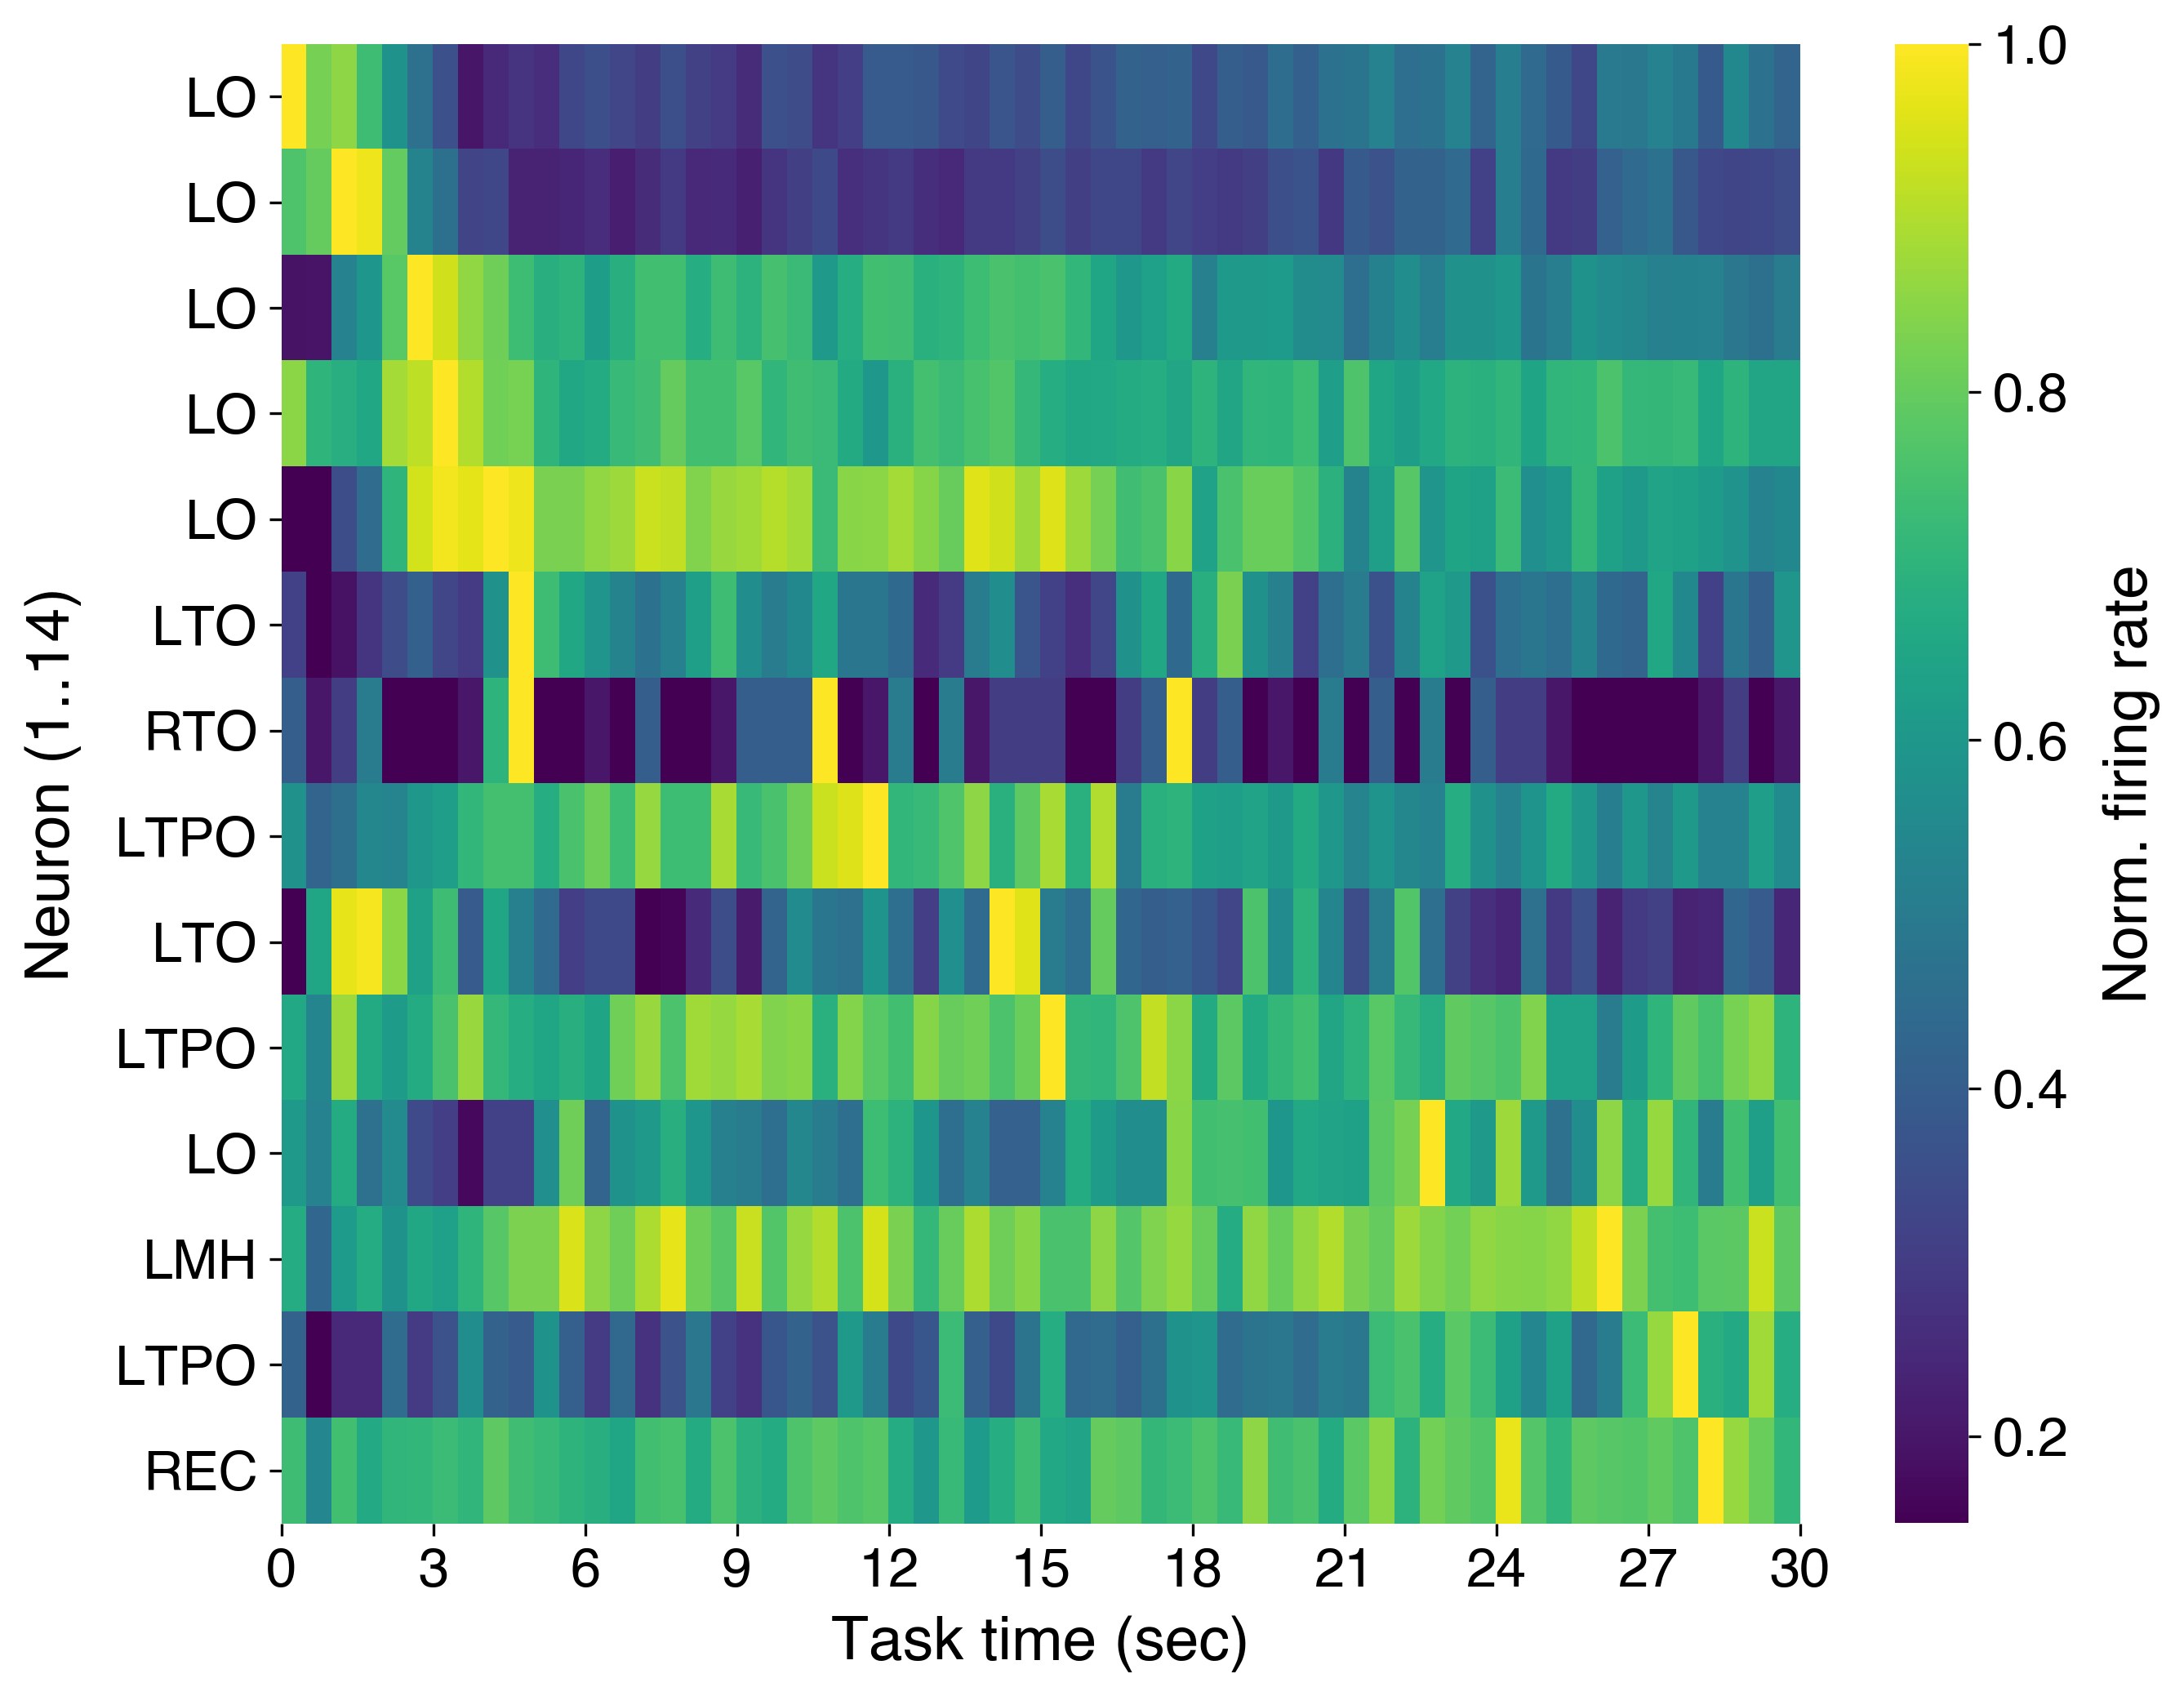

In [302]:
# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_task_spikes[np.argsort(xtrial_task_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, vmin=0.15, vmax=1, cmap='viridis', cbar=True, square=False, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 60, 11))
ax[i].set_xticklabels(np.linspace(0, 30, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spike_dat.iloc[show_units_task]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Task time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_task_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

## Analyze ses1 delay period activity

In [357]:
# Get the start and stop times for each delay period, for each trial.
df1 = game_state_intervals(events, game_state='Delay1', cols=['time'])
df2 = game_state_intervals(events, game_state='Delay2', cols=['time'])
df1.insert(1, 'gameState', 'Delay1')
df2.insert(1, 'gameState', 'Delay2')
assert len(df1) == len(df2)

dat = []
for iRow in range(len(df1)):
    dat.append(df1.iloc[iRow])
    dat.append(df2.iloc[iRow])
    
delay_times = pd.DataFrame(dat, columns=df1.columns)

# Divide each delay period into 50 time bins of equal duration
# (should be ~500 ms each)
n_time_bins_delay = 20
delay_times['time_bins'] = delay_times['time'].apply(lambda x: np.linspace(x[0], x[1], num=n_time_bins_delay+1))
delay_time_bins = np.array(delay_times['time_bins'].tolist()) # event x time_bin

print(delay_time_bins.shape)

(72, 21)


In [358]:
def spikes_by_time_bin(events,
                       game_states, 
                       n_time_bins, 
                       n_bootstraps=5, 
                       output='/scratch/dscho/time_cells/analysis/spikes_by_time_bin'):
    dfs = []
    for i, game_state in enumerate(game_states):
        dfs[i] = game_state_intervals(events, game_state=game_state, cols=['time'])
    assert len(np.unique([len(df) for df in dfs])) == 1
    
    dat = []
    for df in dfs:
        for iRow in range(len(dfs[0])):
            dat.append(df.iloc[iRow])
    
    event_times = pd.DataFrame(dat, columns=df1.columns)
    event_times['time_bins'] = event_times['time'].apply(lambda x: np.linspace(x[0], x[1], num=n_time_bins+1))
    event_time_bins = np.array(event_times['time_bins'].tolist()) # event x time_bin

In [551]:
start_time = time()

n_time_bins_delay = 20
n_time_bins_task = 60
n_bootstraps = 5

# ------------------------------------------------------
# DELAY
# ------------------------------------------------------

# Get the start and stop times for each event interval, for each trial.
# Then divide each event interval into 20 time bins of equal duration
# (should be ~500 ms each).
df1 = game_state_intervals(events, game_state='Delay1', cols=['time'])
df2 = game_state_intervals(events, game_state='Delay2', cols=['time'])
df1.insert(1, 'gameState', 'Delay1')
df2.insert(1, 'gameState', 'Delay2')

assert len(df1) == len(df2)
dat = []
for iRow in range(len(df1)):
    dat.append(df1.iloc[iRow])
    dat.append(df2.iloc[iRow])
    
delay_times = pd.DataFrame(dat, columns=df1.columns)
delay_times['time_bins'] = delay_times['time'].apply(lambda x: np.linspace(x[0], x[1], num=n_time_bins_delay+1))
delay_time_bins = np.array(delay_times['time_bins'].tolist()) # event x time_bin

# For each neuron, count the number of spikes in each time bin.
delay_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>delay_time_bins[iEvent, iTime], 
                                                 spike_dat.loc[iUnit, 'spike_times']<=delay_time_bins[iEvent, iTime+1]))
                           for iTime in range(delay_time_bins.shape[1]-1)]
                          for iEvent in range(delay_time_bins.shape[0])]
                         for iUnit in range(len(spike_dat))])

# Create a null distribution by randomly circ-shifting spikes within each event interval.
delay_times_bs = np.array(
    [[[shift_spike_inds(spike_dat.loc[iUnit, 'spike_times'][np.logical_and(spike_dat.loc[iUnit, 'spike_times']>delay_time_bins[iEvent, 0], 
                                                                           spike_dat.loc[iUnit, 'spike_times']<=delay_time_bins[iEvent, -1])],
                        np.random.rand() * (delay_time_bins[iEvent, -1] - delay_time_bins[iEvent, 0]), 
                        delay_time_bins[iEvent, 0], delay_time_bins[iEvent, -1])
         for iEvent in range(delay_time_bins.shape[0])]
        for iBoot in range(n_bootstraps)]
       for iUnit in range(len(spike_dat))]
    ) # neuron x bs_ind x event

# Count the number of spikes in each time bin, for each permutation.
delay_spikes_bs = np.array(
    [[[[np.sum(np.logical_and(delay_times_bs[iUnit, iBoot, iEvent]>delay_time_bins[iEvent, iTime], 
                              delay_times_bs[iUnit, iBoot, iEvent]<=delay_time_bins[iEvent, iTime+1]))
        for iTime in range(delay_time_bins.shape[1]-1)]
       for iEvent in range(delay_time_bins.shape[0])]
      for iBoot in range(n_bootstraps)]
     for iUnit in range(len(spike_dat))]
    ) # neuron x bs_ind x event x time_bin

# ------------------------------------------------------
# TASK
# ------------------------------------------------------

# Get the start and stop times for each event interval, for each trial.
# Then divide each event interval into 60 time bins of equal duration
# (should be ~500 ms each).
df1 = game_state_intervals(events, game_state='Encoding', cols=['time'])
df2 = game_state_intervals(events, game_state='Retrieval', cols=['time'])
df1.insert(1, 'gameState', 'Encoding')
df2.insert(1, 'gameState', 'Retrieval')

assert len(df1) == len(df2)
dat = []
for iRow in range(len(df1)):
    dat.append(df1.iloc[iRow])
    dat.append(df2.iloc[iRow])

task_times = pd.DataFrame(dat, columns=df1.columns)
task_times['time_bins'] = task_times['time'].apply(lambda x: np.linspace(x[0], x[1], num=n_time_bins_task+1))
task_time_bins = np.array(task_times['time_bins'].tolist()) # event x time_bin

# For each neuron, count the number of spikes in each time bin.
task_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>task_time_bins[iEvent, iTime], 
                                                spike_dat.loc[iUnit, 'spike_times']<=task_time_bins[iEvent, iTime+1]))
                            for iTime in range(task_time_bins.shape[1]-1)]
                           for iEvent in range(task_time_bins.shape[0])]
                         for iUnit in range(len(spike_dat))])

# Create a null distribution by randomly circ-shifting spikes within each event interval.
task_times_bs = np.array(
    [[[shift_spike_inds(spike_dat.loc[iUnit, 'spike_times'][np.logical_and(spike_dat.loc[iUnit, 'spike_times']>task_time_bins[iEvent, 0], 
                                                                           spike_dat.loc[iUnit, 'spike_times']<=task_time_bins[iEvent, -1])],
                        np.random.rand() * (task_time_bins[iEvent, -1] - task_time_bins[iEvent, 0]), 
                        task_time_bins[iEvent, 0], task_time_bins[iEvent, -1])
         for iEvent in range(task_time_bins.shape[0])]
        for iBoot in range(n_bootstraps)]
       for iUnit in range(len(spike_dat))]
    ) # neuron x bs_ind x event

# Count the number of spikes in each time bin, for each permutation.
task_spikes_bs = np.array(
    [[[[np.sum(np.logical_and(task_times_bs[iUnit, iBoot, iEvent]>task_time_bins[iEvent, iTime], 
                              task_times_bs[iUnit, iBoot, iEvent]<=task_time_bins[iEvent, iTime+1]))
        for iTime in range(task_time_bins.shape[1]-1)]
       for iEvent in range(task_time_bins.shape[0])]
      for iBoot in range(n_bootstraps)]
     for iUnit in range(len(spike_dat))]
    ) # neuron x bs_ind x event x time_bin

output = od([('delay_times', delay_times),
             ('delay_spikes', delay_spikes),
             ('delay_times_bs', delay_times_bs),
             ('delay_spikes_bs', delay_spikes_bs),
             ('task_times', task_times),
             ('task_spikes', task_spikes),
             ('task_times_bs', task_times_bs),
             ('task_spikes_bs', task_spikes_bs)])

output_f = os.path.join(analysis_dir, 'spikes_by_time_bin', '{}_spikes_by_time_bin.pkl'.format(subj_sess))
if not os.path.exists(output_f):
    dio.save_pickle(output, output_f)
    
print('Done in {:.2f} secs'.format(time() - start_time))

Saved /scratch/dscho/time_cells/analysis/spikes_by_time_bin/U518_ses0_spikes_by_time_bin.pkl
Done in 84.81 secs


In [ ]:
# For each neuron, get the number of spikes in each delay period time bin
start_time = time()

delay_spikes_bs = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>delay_time_bins[iEvent, iTime], 
                                                 spike_dat.loc[iUnit, 'spike_times']<=delay_time_bins[iEvent, iTime+1]))
                              for iTime in range(delay_time_bins.shape[1]-1)]
                             for iEvent in range(delay_time_bins.shape[0])]
                            for iUnit in range(len(spike_dat))])
print(delay_spikes_bs.shape) # neuron x event x time_bin

print('Done in {:.2f} secs'.format(time() - start_time))

In [359]:
# For each neuron, get the number of spikes in each delay period time bin
start_time = time()

delay_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>delay_time_bins[iEvent, iTime], 
                                                 spike_dat.loc[iUnit, 'spike_times']<=delay_time_bins[iEvent, iTime+1]))
                           for iTime in range(delay_time_bins.shape[1]-1)]
                          for iEvent in range(delay_time_bins.shape[0])]
                         for iUnit in range(len(spike_dat))])
print(delay_spikes.shape) # neuron x event x time_bin

print('Done in {:.2f} secs'.format(time() - start_time))

(496, 72, 20)
Done in 27.92 secs


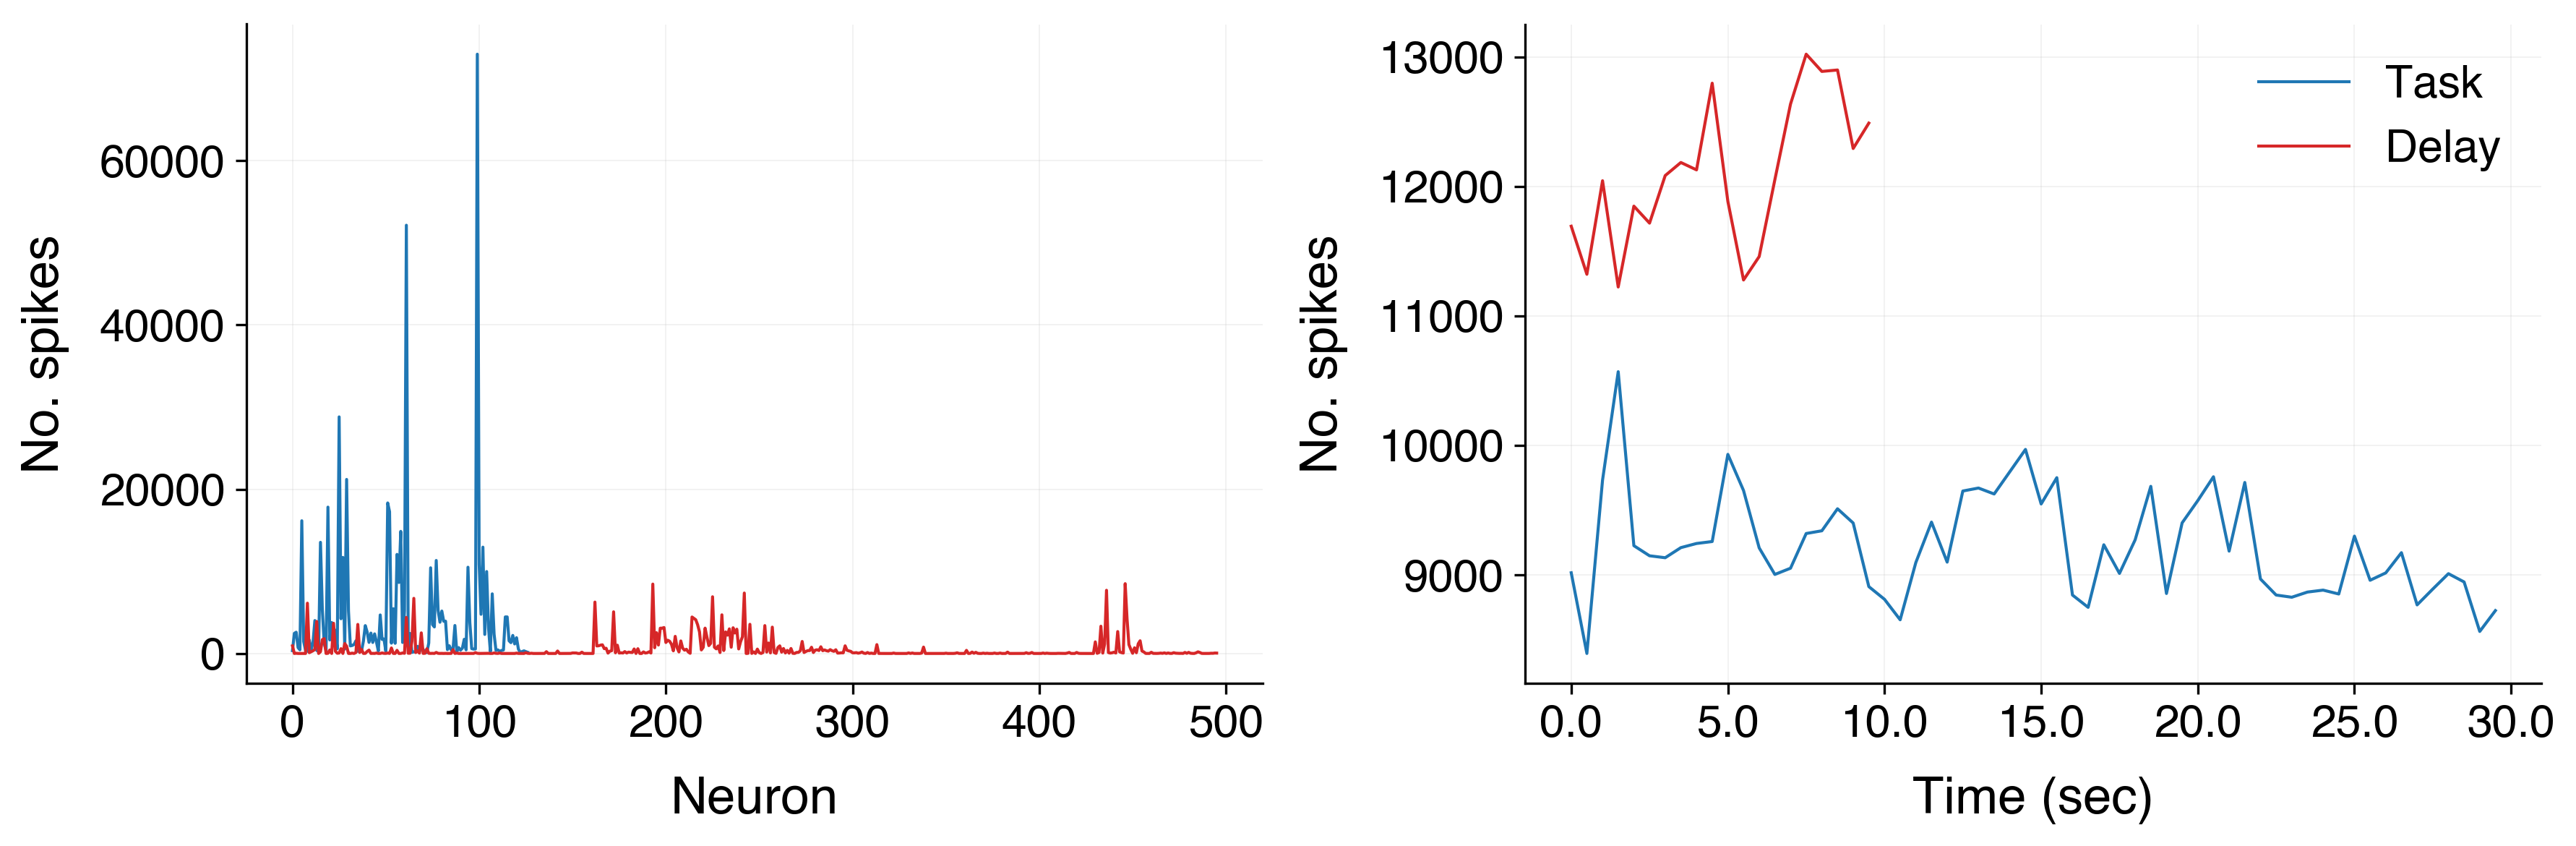

In [292]:
# How many spikes in each time bin across neurons?
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i].plot(np.sum(task_spikes, axis=(1, 2)), label='Task')
ax[i].plot(np.sum(delay_spikes, axis=(1, 2)), label='Delay')
ax[i].set_xlabel('Neuron')
ax[i].set_ylabel('No. spikes')

i = 1
ax[i].plot(np.sum(task_spikes, axis=(0, 1)), label='Task')
ax[i].plot(np.sum(delay_spikes, axis=(0, 1)), label='Delay')
ax[i].set_xticks(np.linspace(0, 60, 7, dtype=int))
ax[i].set_xticklabels([x/2 for x in np.linspace(0, 60, 7, dtype=int)])
ax[i].set_xlabel('Time (sec)')
ax[i].set_ylabel('No. spikes')
ax[i].legend()

fig.tight_layout()

In [360]:
# Use a one-way ANOVA to assess unequal firing rates across time x trial_phase
anova_results = []
for iUnit in range(delay_spikes.shape[0]):
    df = pd.DataFrame({'trial_phase': np.repeat(delay_times['gameState'].tolist(), n_time_bins_delay),
                       'time_bin': np.tile(np.arange(n_time_bins_delay, dtype=int), len(delay_times)),
                       'n_spikes': delay_spikes[iUnit, :, :].ravel()})
    model = ols('n_spikes ~ C(time_bin)', data=df).fit()
    anova_results.append((model.rsquared, model.fvalue, model.f_pvalue))
anova_results = pd.DataFrame(anova_results, columns=['R^2', 'F', 'F_p'])
anova_results.insert(0, 'iUnit', np.arange(len(anova_results), dtype=int))
anova_results['sig_fdr'] = sm.stats.multipletests(anova_results['F_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
anova_results = anova_results.sort_values('R^2', ascending=False).reset_index(drop=True)

# For each neuron, add the number of spikes in each time bin, across all delay periods.
sig_cells_delay = np.array(anova_results.query("(sig_fdr==True)")['iUnit'].tolist())
xtrial_delay_spikes = np.sum(delay_spikes[sig_cells_delay, :, :], axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=-1))]

n_sig = anova_results['sig_fdr'].sum()
n_cells = len(anova_results)

print('{}/{} ({:.1f}%) cells are significantly time-modified'.format(n_sig, n_cells, 100 * (n_sig/n_cells)))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1594: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid


6/496 (1.2%) cells are significantly time-modified


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [362]:
import warnings
warnings.filterwarnings("ignore")

In [802]:
n_bootstraps = 1000
bs_inds = np.array([np.random.permutation(np.arange(delay_spikes.shape[1]))
                    for iBoot in range(n_bootstraps)]) # bs_ind x time_bin

In [794]:
# Build a null distribution by shifting time bins from each event
iBoot = 0
delay_spikes[:, bs_inds[iBoot, :], :].shape

(139, 20, 24)

In [298]:
# What are the sig cells?
spike_dat.loc[sig_cells_delay]

subj_sess  subj  sess  chan  unit  \
430  U518_ses1  U518  ses1    65     1   
433  U518_ses1  U518  ses1    67     1   
442  U518_ses1  U518  ses1    70     1   
8    U518_ses1  U518  ses1     4     1   
435  U518_ses1  U518  ses1    67     3   
257  U518_ses1  U518  ses1    38     1   

                                           spike_times  n_spikes         fr  \
430  [516.4333333333334, 826.0666666666667, 1177.26...     58305  15.590459   
433  [1814.8666666666668, 2988.0, 4497.500000000001...     16507   4.413888   
442  [26.933333333333334, 412.6666666666667, 1098.7...     45936  12.283052   
8    [78.26666666666667, 102.7, 114.3, 191.76666666...     31107   8.317853   
435  [21.566666666666666, 1264.8000000000002, 2791....      7680   2.053593   
257  [432.93333333333334, 522.6333333333333, 579.23...     18555   4.961512   

    hemroi  
430     LO  
433     LO  
442     LO  
8      REC  
435     LO  
257    LMH

In [301]:
spike_dat.groupby('hemroi').size()

hemroi
LA        11
LAI       11
LMH       18
LO         9
LPOSTI     6
LTO       28
LTPO      13
REC       22
RIP        3
RTO       16
dtype: int64

In [305]:
np.round(spike_dat.loc[sig_cells_delay].groupby('hemroi').size() / spike_dat.groupby('hemroi').size() * 100, 1)

hemroi
LA         NaN
LAI        9.1
LMH        5.6
LO        66.7
LPOSTI     NaN
LTO        3.6
LTPO      15.4
REC       13.6
RIP       33.3
RTO       31.2
dtype: float64

In [315]:
list(spike_dat.groupby('hemroi').size().index)

['LA', 'LAI', 'LMH', 'LO', 'LPOSTI', 'LTO', 'LTPO', 'REC', 'RIP', 'RTO']

In [328]:
spike_dat.groupby('hemroi')['fr'].apply(lambda x: np.round(np.mean(x), 2))

In [297]:
df = (pd.DataFrame({'Region': spike_dat.groupby('hemroi').size().index,
                    'No. neurons': spike_dat.groupby('hemroi').size(),
                    'Median firing rate': spike_dat.groupby('hemroi')['fr'].apply(lambda x: np.round(np.median(x), 2)),
                    'No. time-modified': spike_dat.loc[sig_cells_delay].groupby('hemroi').size(),
                    'Pct. time-modified': np.round(spike_dat.loc[sig_cells_delay].groupby('hemroi').size() / spike_dat.groupby('hemroi').size() * 100, 1),
                    'Median firing rate (time-modified)': spike_dat.loc[sig_cells_delay].groupby('hemroi')['fr'].apply(lambda x: np.round(np.median(x), 2))})
      .reset_index(drop=True))
for col in ['No. time-modified', 'Pct. time-modified']:
    df.loc[np.invert(df[col] > 0), col] = 0
df['No. time-modified'] = df['No. time-modified'].astype(np.int)
df

Region  No. neurons  Median firing rate  No. time-modified  \
0       LA           84                1.20                  0   
1      LAI           64                0.24                  0   
2      LMH           19                0.30                  1   
3     LMTG           60                0.17                  0   
4       LO           17                0.93                  4   
5      LPC           25                0.22                  0   
6   LPOSTI           15                0.19                  0   
7      LTO           41                0.74                  0   
8     LTPO            9                1.24                  0   
9      REC           41                0.52                  1   
10     RIP           85                0.21                  0   
11     RTO           36                0.49                  0   

    Pct. time-modified  Median firing rate (time-modified)  
0                  0.0                                 NaN  
1                  0.0                                 NaN  
2                  5.3                                4.96  
3                  0.0                                 NaN  
4                 23.5                                8.35  
5                  0.0                                 NaN  
6                  0.0                                 NaN  
7                  0.0                                 NaN  
8                  0.0                                 NaN  
9                  2.4                                8.32  
10                 0.0                                 NaN  
11                 0.0                                 NaN

min=0.19


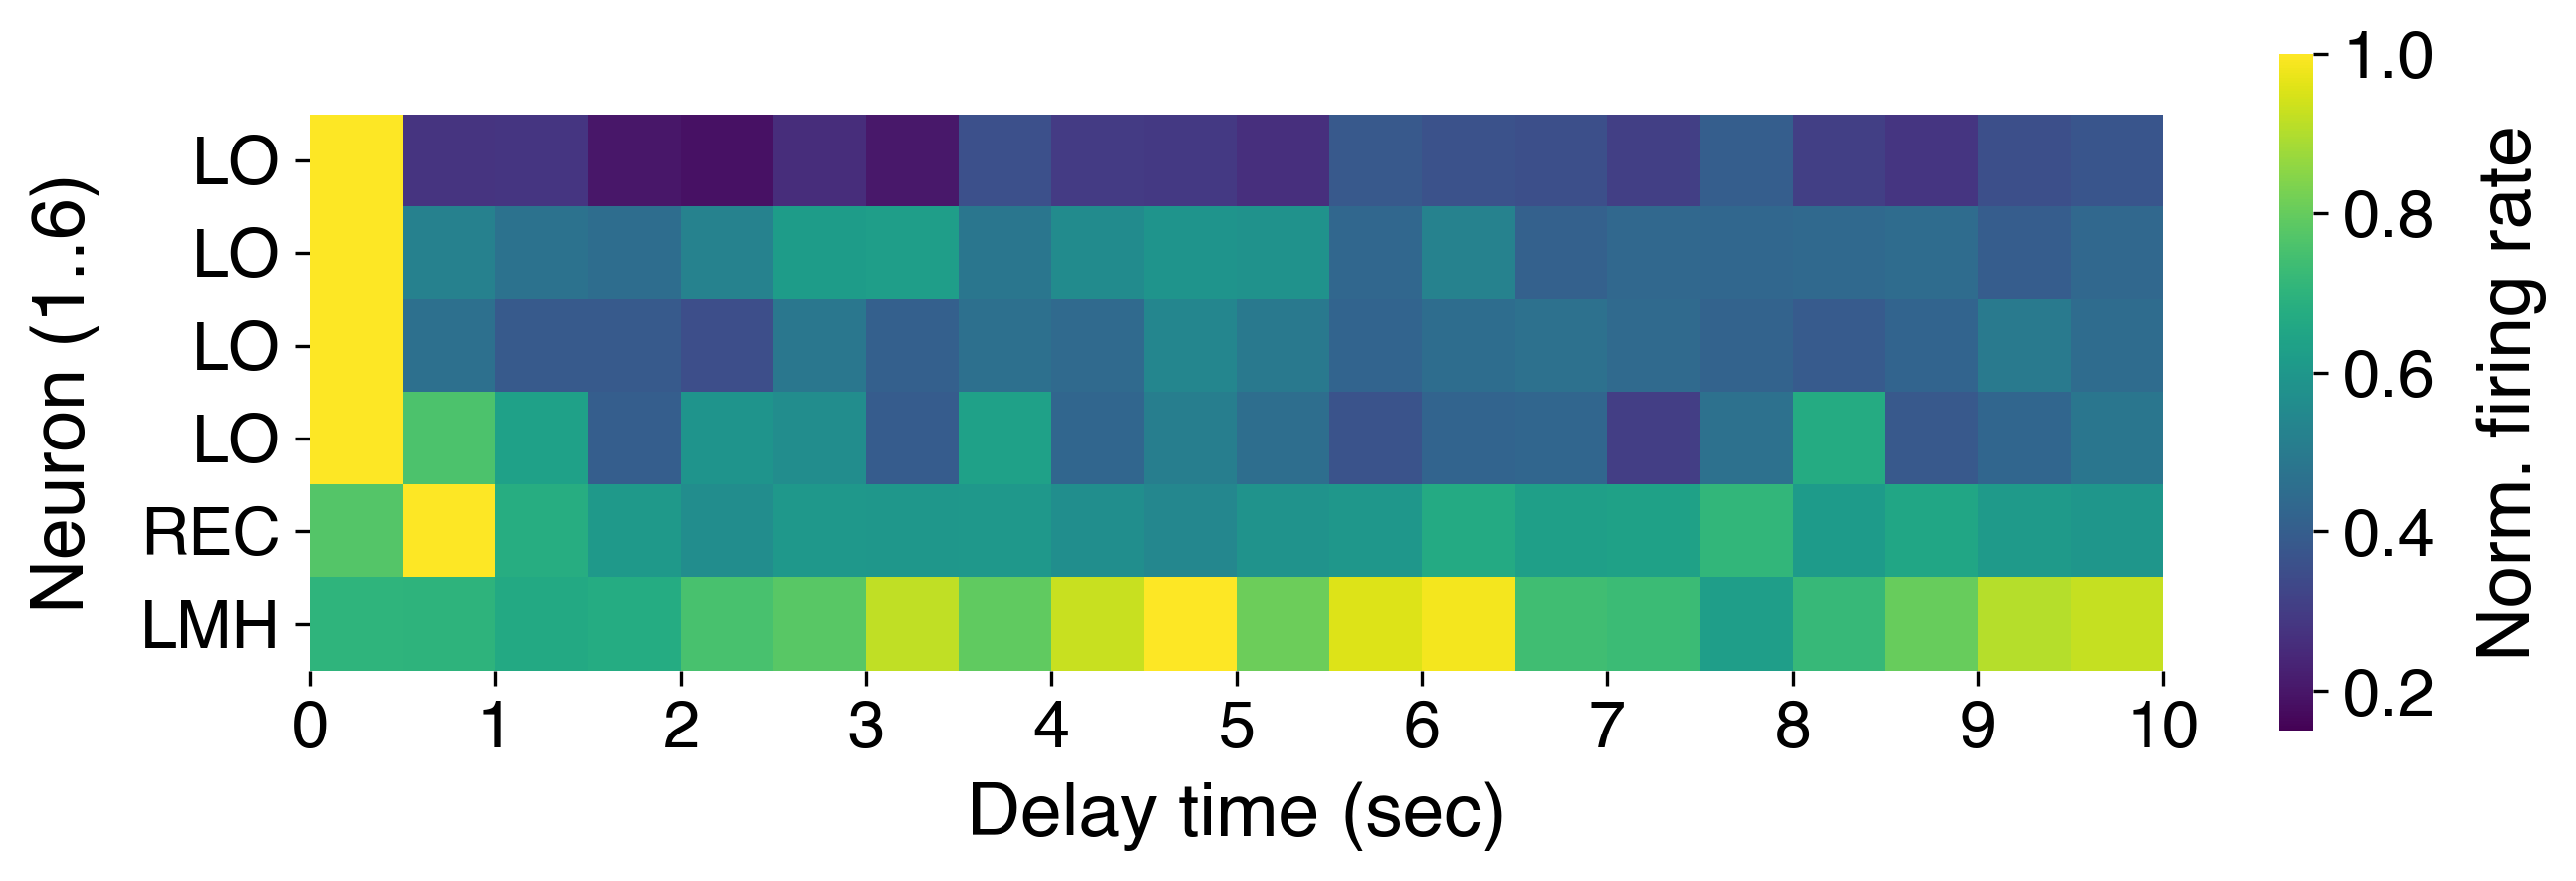

In [304]:
# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, vmin=0.15, vmax=1, cmap='viridis', cbar=True, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spike_dat.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

In [363]:
# Use a one-way ANOVA to assess unequal firing rates across time x trial_phase
anova_results = []
for iUnit in range(delay_spikes.shape[0]):
    df = pd.DataFrame({'trial_phase': np.repeat(delay_times['gameState'].tolist(), n_time_bins_delay),
                       'time_bin': np.tile(np.arange(n_time_bins_delay, dtype=int), len(delay_times)),
                       'n_spikes': delay_spikes[iUnit, :, :].ravel()})
    model = ols('n_spikes ~ C(time_bin) * C(trial_phase)', data=df).fit()
    anova_ixn = sm.stats.anova_lm(model, typ=2)
    model = ols('n_spikes ~ C(time_bin) + C(trial_phase)', data=df).fit()
    anova = sm.stats.anova_lm(model, typ=2)    
    anova_results.append((anova_ixn.loc['C(time_bin):C(trial_phase)']['F'], 
                          anova_ixn.loc['C(time_bin):C(trial_phase)']['PR(>F)'],
                          anova.loc['C(time_bin)']['F'],
                          anova.loc['C(time_bin)']['PR(>F)'],
                          anova.loc['C(trial_phase)']['F'],
                          anova.loc['C(trial_phase)']['PR(>F)']))
cols = ['ixn_F', 'ixn_p', 'time_F', 'time_p', 'trial_phase_F', 'trial_phase_p']
anova_results = pd.DataFrame(anova_results, columns=cols)
anova_results.insert(0, 'iUnit', np.arange(len(anova_results), dtype=int))
anova_results['ixn_sig_fdr'] = sm.stats.multipletests(anova_results['ixn_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
anova_results['time_sig_fdr'] = sm.stats.multipletests(anova_results['time_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
anova_results['trial_phase_sig_fdr'] = sm.stats.multipletests(anova_results['trial_phase_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]

# For each neuron, add the number of spikes in each time bin, across all delay periods.
sig_cells_delay = np.array(anova_results.query("(time_sig_fdr==True)")['iUnit'].tolist())
xtrial_delay_spikes = np.sum(delay_spikes[sig_cells_delay, :, :], axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=-1))]

n_sig_ixn = anova_results['ixn_sig_fdr'].sum()
n_sig_time = anova_results['time_sig_fdr'].sum()
n_sig_trial_phase = anova_results['trial_phase_sig_fdr'].sum()
n_cells = len(anova_results)

print('{}/{} ({:.1f}%) cells have a significant time x trial phase interaction'.format(n_sig_ixn, n_cells, 100 * (n_sig_ixn/n_cells)))
print('{}/{} ({:.1f}%) cells are significantly time-modified'.format(n_sig_time, n_cells, 100 * (n_sig_time/n_cells)))
print('{}/{} ({:.1f}%) cells are significantly trial phase-modified'.format(n_sig_trial_phase, n_cells, 100 * (n_sig_trial_phase/n_cells)))

0/496 (0.0%) cells have a significant time x trial phase interaction
6/496 (1.2%) cells are significantly time-modified
10/496 (2.0%) cells are significantly trial phase-modified


In [391]:
iUnit = 239
df = pd.DataFrame({'trial_phase': np.repeat(delay_times['gameState'].tolist(), n_time_bins_delay),
                   'time_bin': np.tile(np.arange(n_time_bins_delay, dtype=int), len(delay_times)),
                   'n_spikes': delay_spikes[iUnit, :, :].ravel()})
model = ols('n_spikes ~ C(time_bin) * C(trial_phase)', data=df).fit()
anova_ixn = sm.stats.anova_lm(model, typ=2)
anova_ixn

sum_sq      df          F    PR(>F)
C(time_bin)                  106.368750    19.0   0.785347  0.726874
C(trial_phase)               136.284028     1.0  19.118160  0.000013
C(time_bin):C(trial_phase)    96.063194    19.0   0.709258  0.812420
Residual                    9979.916667  1400.0        NaN       NaN

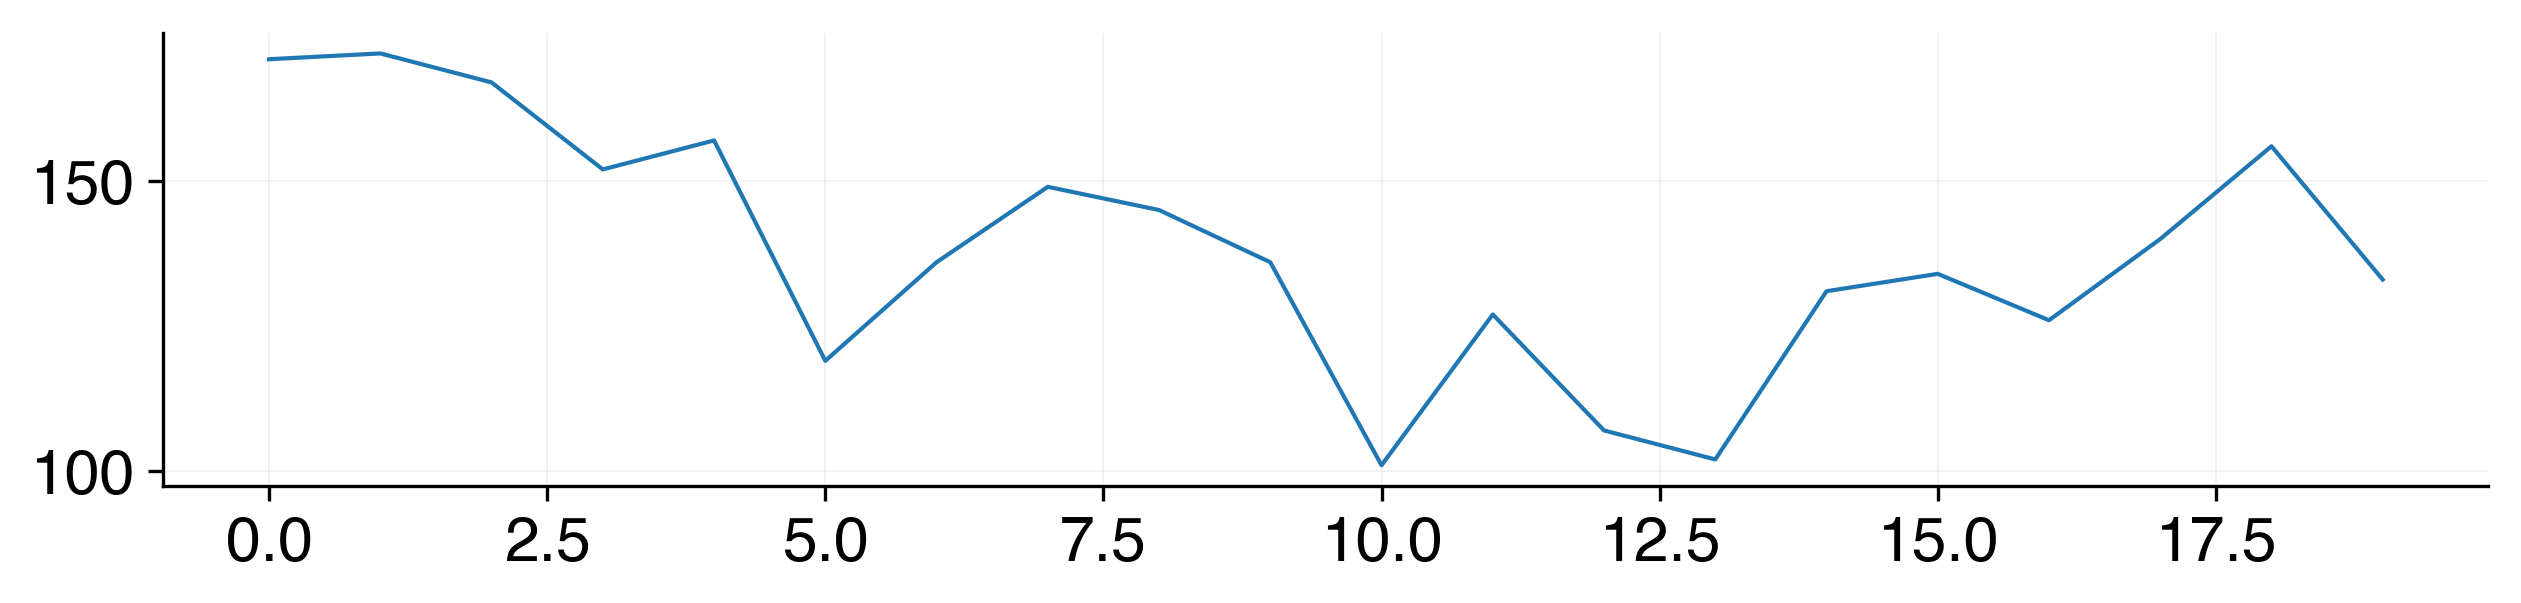

In [405]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2), dpi=300)

iUnit = 216
ax.plot(np.sum(delay_spikes[iUnit, ::2, :], axis=0))

In [366]:
anova_results.query("(trial_phase_sig_fdr==True)")

iUnit     ixn_F     ixn_p    time_F    time_p  trial_phase_F  \
185    185  0.611836  0.900154  0.691195  0.830781      12.190774   
188    188  0.684566  0.837281  0.819515  0.685186      14.919215   
204    204  0.225639  0.999813  0.193526  0.999943      17.213078   
216    216  0.108171  1.000000  0.064143  1.000000      12.945671   
224    224  0.502087  0.962875  0.062818  1.000000      13.792297   
231    231  0.356749  0.995193  0.317629  0.997787      24.354723   
239    239  0.709258  0.812420  0.788416  0.723203      19.192876   
249    249  0.976719  0.486195  0.893151  0.591899      11.179472   
253    253  0.737284  0.782335  1.527175  0.067652      27.014983   
267    267  0.864836  0.628075  1.183444  0.262793      12.468880   

     trial_phase_p  ixn_sig_fdr  time_sig_fdr  trial_phase_sig_fdr  
185   4.949933e-04        False         False                 True  
188   1.172687e-04        False         False                 True  
204   3.539717e-05        False         False                 True  
216   3.316798e-04        False         False                 True  
224   2.120848e-04        False         False                 True  
231   8.959944e-07        False         False                 True  
239   1.268364e-05        False         False                 True  
249   8.486282e-04        False         False                 True  
253   2.313563e-07        False         False                 True  
267   4.270304e-04        False         False                 True

In [374]:
#sig_cells_delay = np.array(anova_results.query("(trial_phase_sig_fdr==True)")['iUnit'].tolist())
dat.shape

(20, 36)

In [370]:
np.vstack((np.sum(delay_spikes[0, ::2, :], axis=1), 
           np.sum(delay_spikes[0, 1::2, :], axis=1))).shape

(2, 36)

In [381]:
np.sum(delay_spikes[iUnit, :, :], axis=1)

array([ 6,  2,  4,  9,  3,  6,  5,  9,  4, 18,  5, 13,  6,  8,  4, 11,  9,
       13,  4, 12,  8,  6,  7,  6, 14,  7,  8,  4,  9, 12,  8, 12,  8, 13,
        2,  8,  7,  9,  9, 16,  7,  9,  8, 15, 17, 11, 15,  9, 10,  3,  8,
       14,  8,  9,  7, 13,  4,  6,  5, 11,  3,  7,  8,  5,  6, 11,  3,  7,
        8, 14,  8, 12])

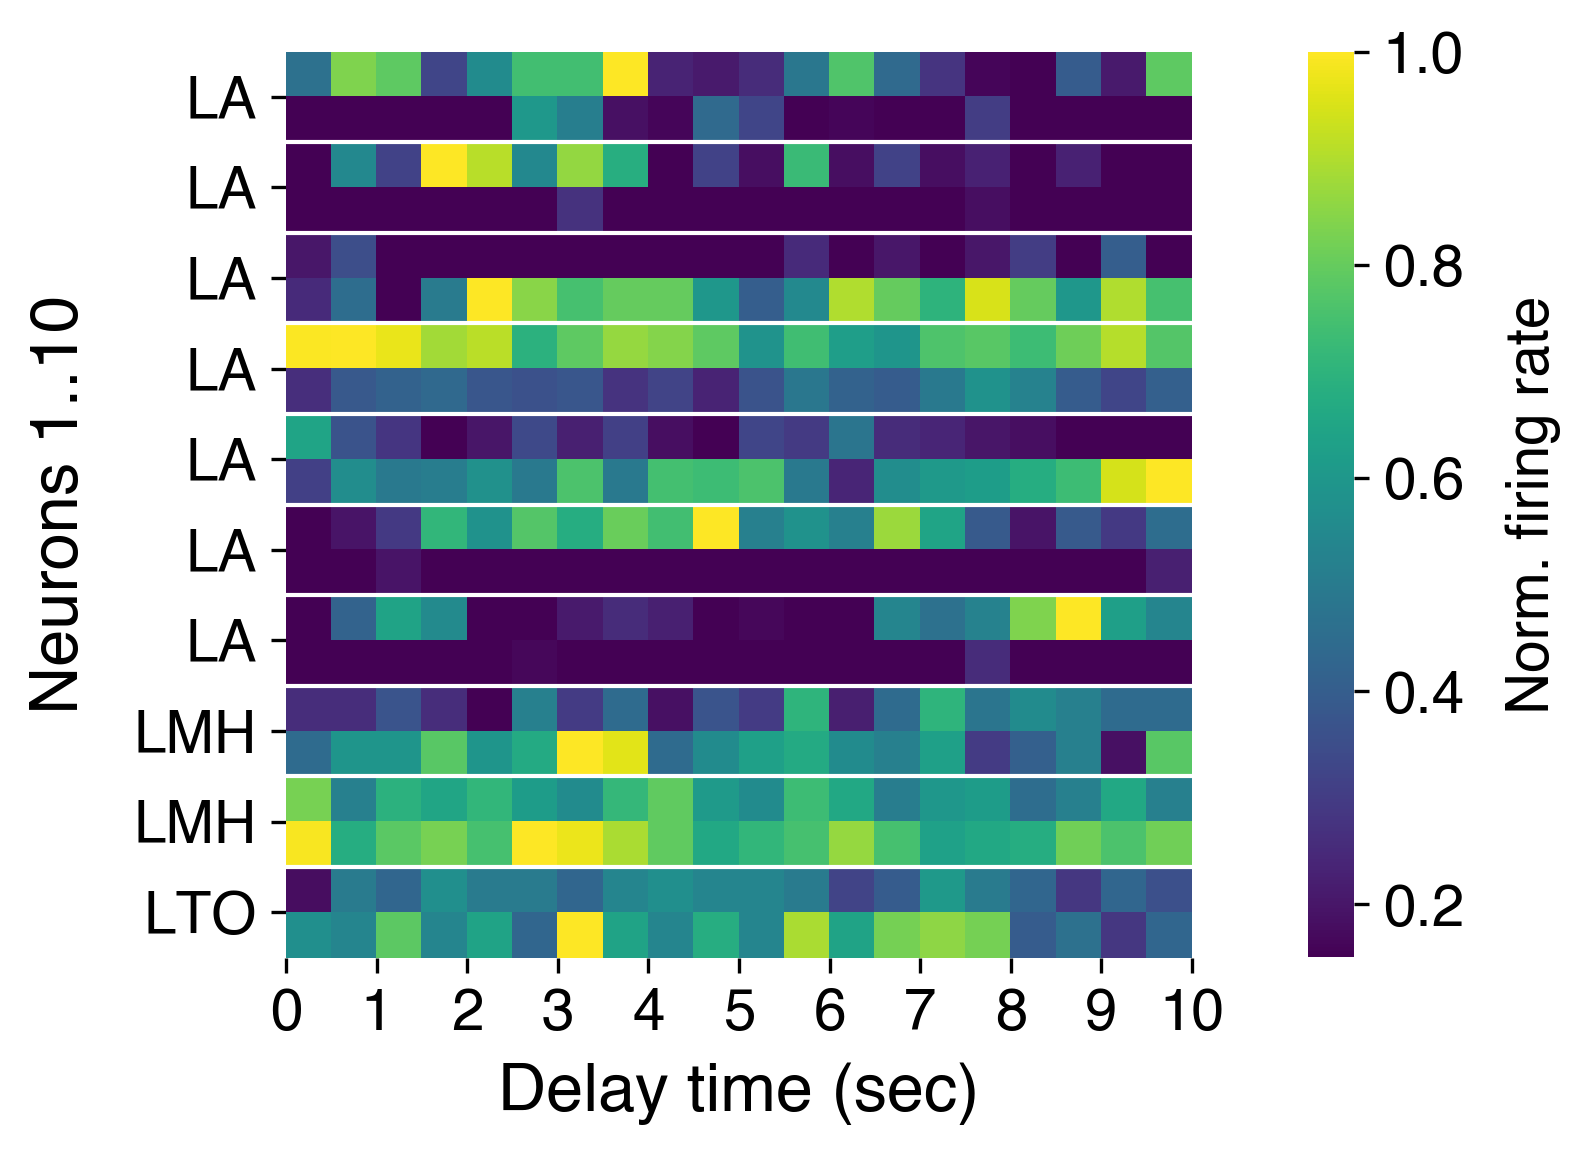

In [388]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
sig_cells_delay = np.array(anova_results.query("(trial_phase_sig_fdr==True)")['iUnit'].tolist())
xtrial_delay_spikes = []
for iUnit in sig_cells_delay:
    dat = np.vstack((np.sum(delay_spikes[iUnit, ::2, :], axis=0), 
                     np.sum(delay_spikes[iUnit, 1::2, :], axis=0)))
    dat = dat / np.max(dat)
    xtrial_delay_spikes.append(dat[0, :])
    xtrial_delay_spikes.append(dat[1, :])
xtrial_delay_spikes = np.array(xtrial_delay_spikes)
dat = xtrial_delay_spikes

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 16

i = 0
ax[i] = sns.heatmap(dat, vmin=0.15, vmax=1, cmap='viridis', cbar=True, square=True, ax=ax[i])
for iRow in range(len(sig_cells_delay)-1):
    ax[i].axhline(y=2*iRow+2, color='w', linewidth=1, alpha=1)
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])[::2]+1)
ax[i].set_yticklabels(spike_dat.iloc[sig_cells_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neurons 1..{}'.format(len(sig_cells_delay)), fontsize=labelfontsize, labelpad=10)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=tickfontsize)

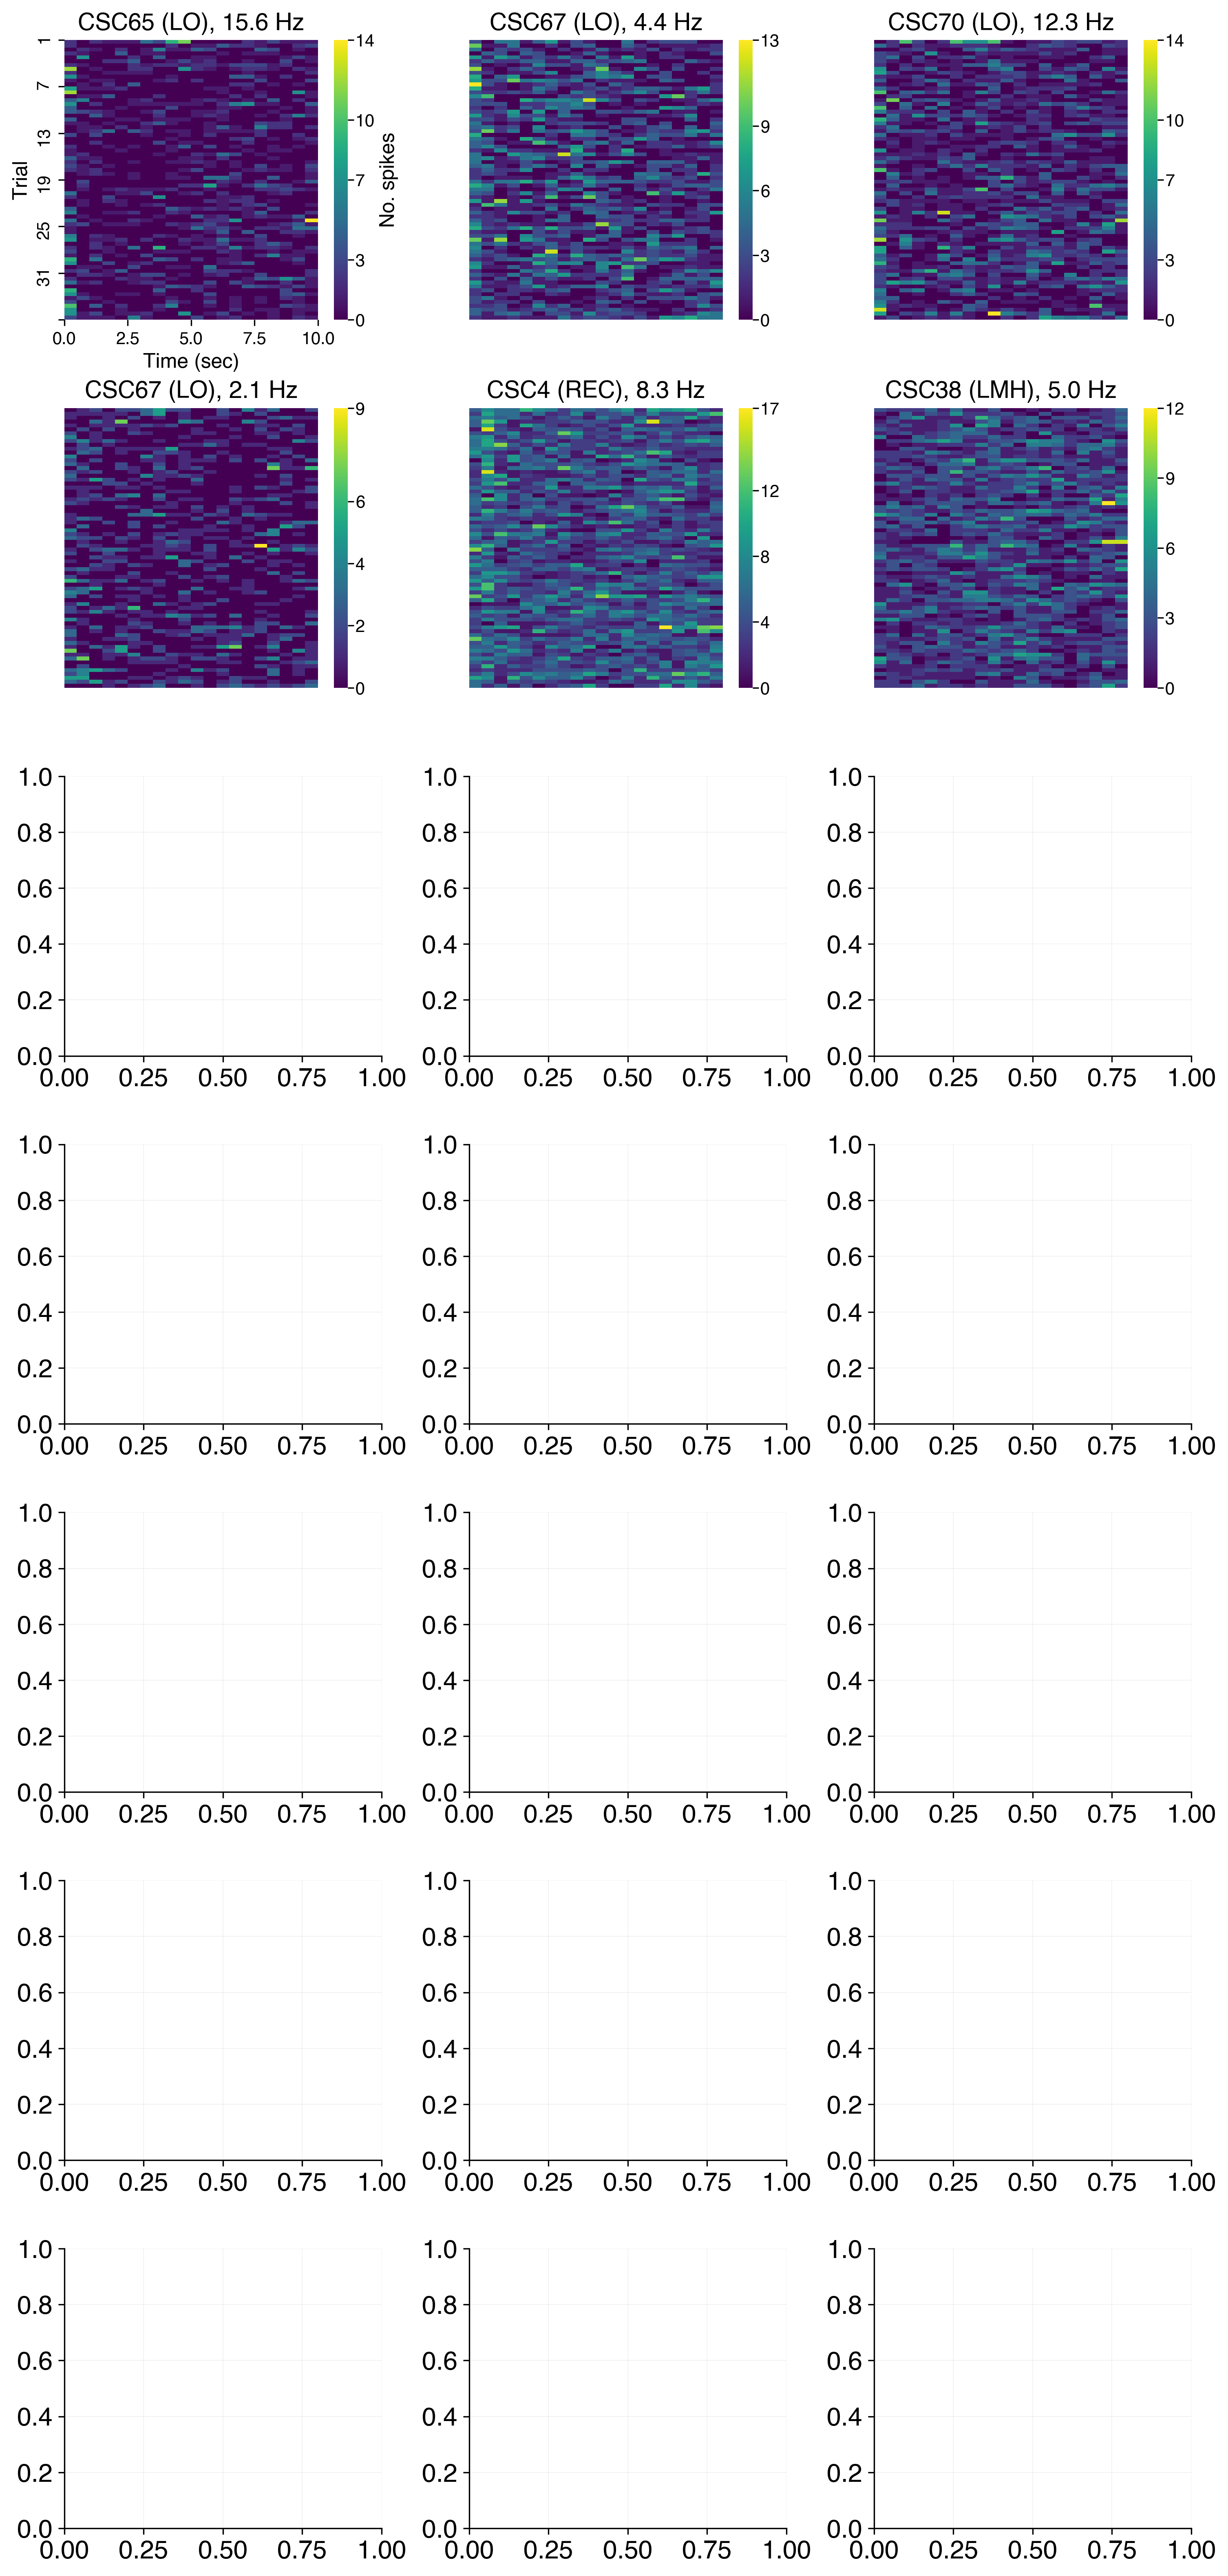

In [296]:
fig, ax = plt.subplots(7, 3, figsize=(10, 21), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 12
figfontsize = 14

for i in range(len(show_units_delay)):
    ax[i] = sns.heatmap(delay_spikes[show_units_delay[i], :, :], cmap='viridis', square=False, ax=ax[i])
    ax[i].set_title('CSC{} ({}), {:.1f} Hz'.format(spike_dat.iloc[show_units_delay[i]]['chan'], spike_dat.iloc[show_units_delay[i]]['hemroi'],
                                                   spike_dat.iloc[show_units_delay[i]]['fr']), fontsize=figfontsize, y=1.05)
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfontsize, pad=1)
    vmin = np.min(delay_spikes[show_units_delay[i], :, :])
    vmax = np.max(delay_spikes[show_units_delay[i], :, :])
    cbar.set_ticks(np.linspace(int(vmin), int(vmax), 5, dtype=int))
    cbar.set_ticklabels(np.linspace(int(vmin), int(vmax), 5, dtype=int))
    
    if i > 0:
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    if i == 0:
        ax[i].set_xticks(np.linspace(0, 20, 5))
        ax[i].set_xticklabels(np.linspace(0, 10, 5), fontsize=tickfontsize)
        ax[i].set_yticks(np.linspace(0, 72, 7))
        ax[i].set_yticklabels([str(x) for x in np.arange(1, 37, 6)], fontsize=tickfontsize)
        ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=3)
        ax[i].set_ylabel('Trial', fontsize=labelfontsize, labelpad=3)
        cbar.set_label('No. spikes', fontsize=labelfontsize, labelpad=3)

fig.tight_layout(pad=0.5)

## Analyze trial phases

In [295]:
trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
trial_times = np.array([game_state_intervals(events, game_state=trial_phase, cols=['time']).time.tolist()
                        for trial_phase in trial_phases]) # trial_phase x event x (time_start, time_stop)
trial_times.shape

(4, 36, 2)

In [160]:
# For each neuron, get the number of spikes/sec in each task period time bin
start_time = time()

delay_secs = 10.0
task_secs = 30.0
trial_spikes = np.array([[[np.sum(np.logical_and(spike_dat.loc[iUnit, 'spike_times']>trial_times[iTrialPhase, iEvent, 0], 
                                                 spike_dat.loc[iUnit, 'spike_times']<=trial_times[iTrialPhase, iEvent, 1]))
                           for iTrialPhase in range(trial_times.shape[0])]
                          for iEvent in range(trial_times.shape[1])]
                         for iUnit in range(len(spike_dat))])
trial_spikes[:, :, [0, 2]] = trial_spikes[:, :, [0, 2]] / delay_secs
trial_spikes[:, :, [1, 3]] = trial_spikes[:, :, [1, 3]] / task_secs
print(trial_spikes.shape, trial_spikes.sum()) # neuron x event x trial_phase

print('Done in {:.2f} secs'.format(time() - start_time))

(137, 36, 4) 30232
Done in 1.11 secs


In [ ]:
# Use a one-way ANOVA to assess unequal firing rates across time x trial_phase
anova_results = []
for iUnit in range(delay_spikes.shape[0]):
    df = pd.DataFrame({'trial_phase': np.repeat(delay_times['gameState'].tolist(), n_time_bins),
                       'time_bin': np.tile(np.arange(n_time_bins, dtype=int), len(delay_times)),
                       'n_spikes': delay_spikes[iUnit, :, :].ravel()})
    model = ols('n_spikes ~ C(time_bin)', data=df).fit()
    anova_results.append((model.rsquared, model.fvalue, model.f_pvalue))
anova_results = pd.DataFrame(anova_results, columns=['R^2', 'F', 'F_p'])
anova_results.insert(0, 'iUnit', np.arange(len(anova_results), dtype=int))
anova_results['sig_fdr'] = sm.stats.multipletests(anova_results['F_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
anova_results = anova_results.sort_values('R^2', ascending=False).reset_index(drop=True)
sig_cells = np.array(anova_results.query("(sig_fdr==True)")['iUnit'].tolist())

n_sig = anova_results['sig_fdr'].sum()
n_cells = len(anova_results)

print('{}/{} ({:.1f}%) cells are significantly time-modified'.format(n_sig, n_cells, 100 * (n_sig/n_cells)))

In [180]:
np.sum(trial_spikes, axis=0)

array([[156, 230, 217, 202],
       [161, 233, 394, 291],
       [210, 244, 183, 291],
       [226, 202, 164, 203],
       [192, 191, 154, 202],
       [228, 192, 288, 209],
       [177, 209, 209, 200],
       [156, 219, 161, 197],
       [194, 252, 170, 213],
       [195, 226, 198, 214],
       [223, 242, 249, 229],
       [156, 210, 162, 226],
       [240, 202, 190, 228],
       [197, 194, 147, 217],
       [183, 205, 219, 209],
       [162, 191, 171, 198],
       [378, 224, 179, 198],
       [166, 240, 195, 219],
       [159, 195, 166, 190],
       [178, 214, 278, 282],
       [194, 190, 151, 195],
       [201, 203, 236, 210],
       [218, 201, 218, 195],
       [261, 191, 145, 198],
       [224, 195, 144, 192],
       [171, 203, 161, 184],
       [153, 200, 296, 211],
       [420, 206, 335, 207],
       [230, 208, 187, 206],
       [196, 210, 173, 216],
       [197, 202, 168, 193],
       [173, 220, 179, 219],
       [386, 213, 187, 192],
       [176, 195, 178, 188],
       [267, 2

In [156]:
xtrial_spikes = np.mean(trial_spikes, axis=1) # neuron x trial_phase

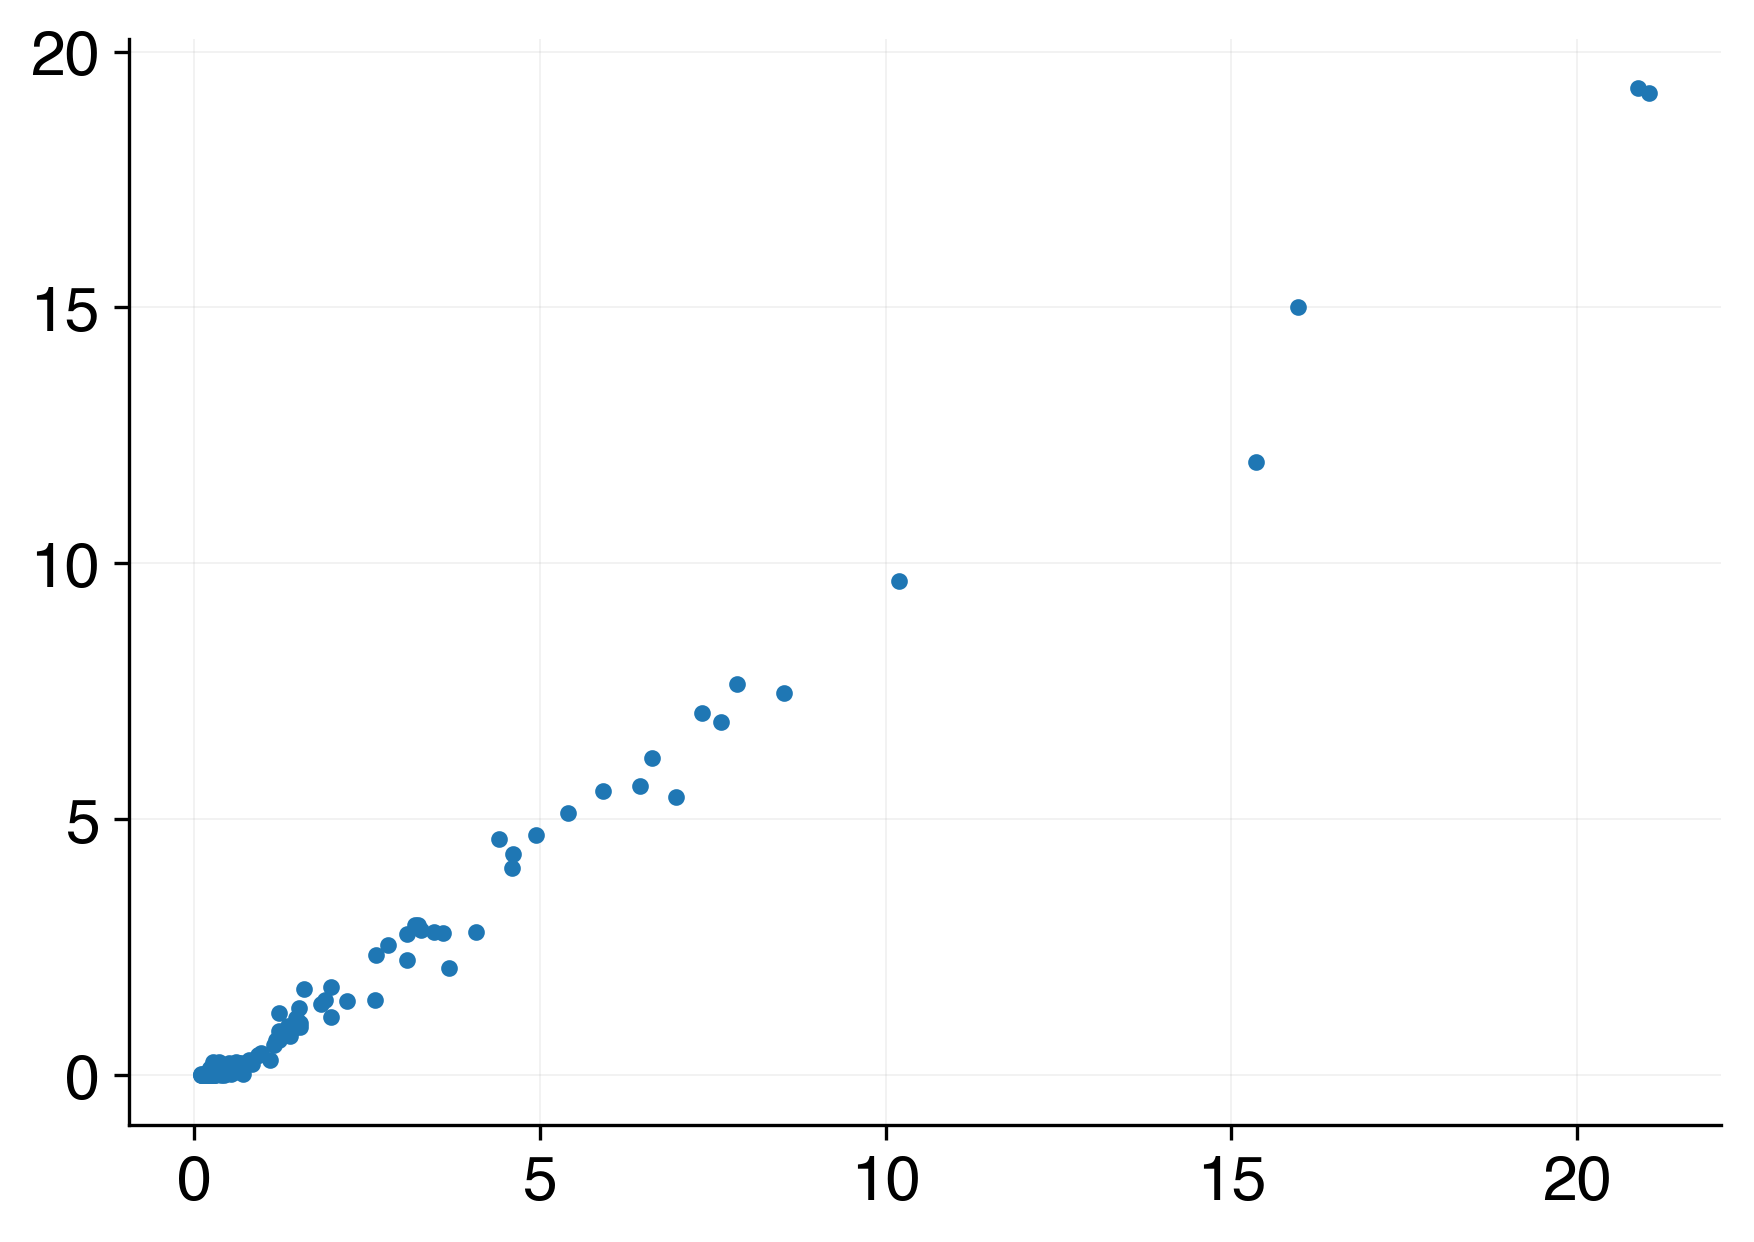

In [157]:
plt.scatter(np.array(spike_dat['fr'].tolist())[:130], np.mean(xtrial_spikes, axis=-1)[:130])

In [161]:
np.array([np.mean(trial_spikes[:, :, [0, 2]], 2), # neuron x event; delay periods
                     np.mean(trial_spikes[:, :, [1, 3]], 2)]).shape

(2, 137, 36)

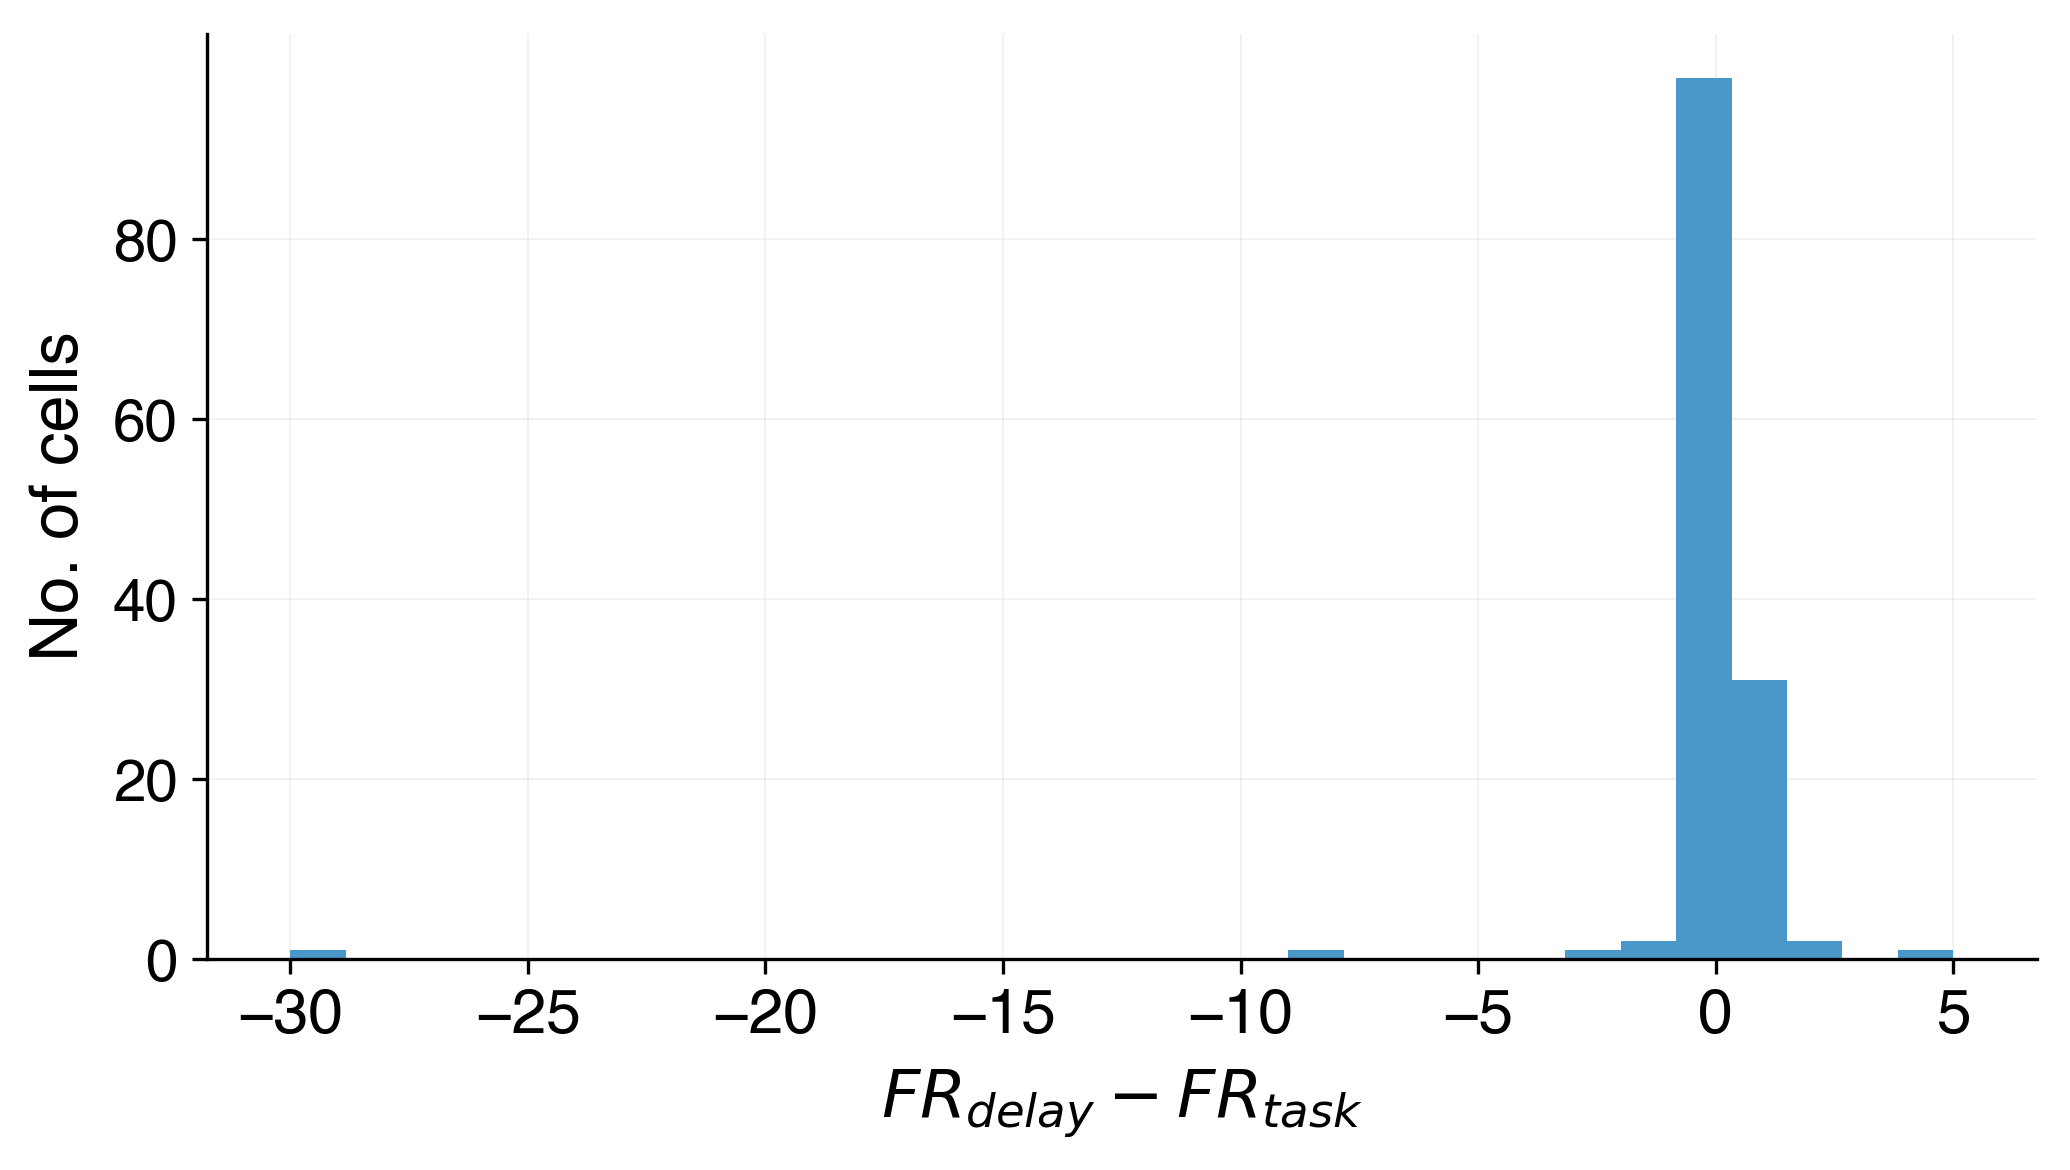

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 16

fr_pairs = np.array([np.mean(trial_spikes[:, :, [0, 2]], 2), # delay periods
                     np.mean(trial_spikes[:, :, [1, 3]], 2)]) # task periods
fr_pairs = np.moveaxis(fr_pairs, 0, -1) # neuron x trial x trial_phase
fr_diffs = np.array([np.median(fr_pairs[iUnit, :, 0]) - np.median(fr_pairs[iUnit, :, 1])
                     for iUnit in range(fr_pairs.shape[0])])

i = 0
ax[i].hist(fr_diffs, bins=30, color=colors[0])
#ax[i].set_xticks(np.linspace(-6, 6, 7, dtype=int))
#ax[i].set_xticklabels(np.linspace(-6, 6, 7, dtype=int), fontsize=tickfontsize)
ax[i].set_yticks(np.linspace(0, 80, 5, dtype=int))
ax[i].set_yticklabels(np.linspace(0, 80, 5, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('$FR_{delay} - FR_{task}$', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('No. of cells', fontsize=labelfontsize, labelpad=5)

fig.tight_layout()

In [176]:
fr_diffs

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         1.5 ,   0.5 ,   1.  ,   1.  ,   0.5 ,   0.  ,   0.  ,   0.  ,
         0.5 ,  -0.5 ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.5 ,  -0.5 ,   2.  ,   0.5 ,   0.  ,   0.5 ,   0.  ,
         0.  ,   0.25,   0.75,   0.5 ,   0.5 ,   1.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,  -0.5 ,   0.  ,   0.25,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.75,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,  -1.5 ,   1.  ,   0.  ,   0.75,   0.  ,   0.  ,   0.  ,
         0.  ,   0.5 ,   1.  ,   0.5 ,  -2.  ,   0.5 ,  -0.5 ,   0.  ,
        -8.5 ,   0.  ,   0.  ,   0.  ,   0.5 ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   1.  ,   0.  ,   1.25,   5.  ,   0.  ,   0.  ,
         1.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.5 ,   0.  ,   0.  ,   0.  ,   0.  ,   0.25,   0.  ,   0.  ,
        -0.5 ,   0.  ,   0.  ,   0.  ,   0.  , -30.  ,   0.5 ,   0.  ,
      

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


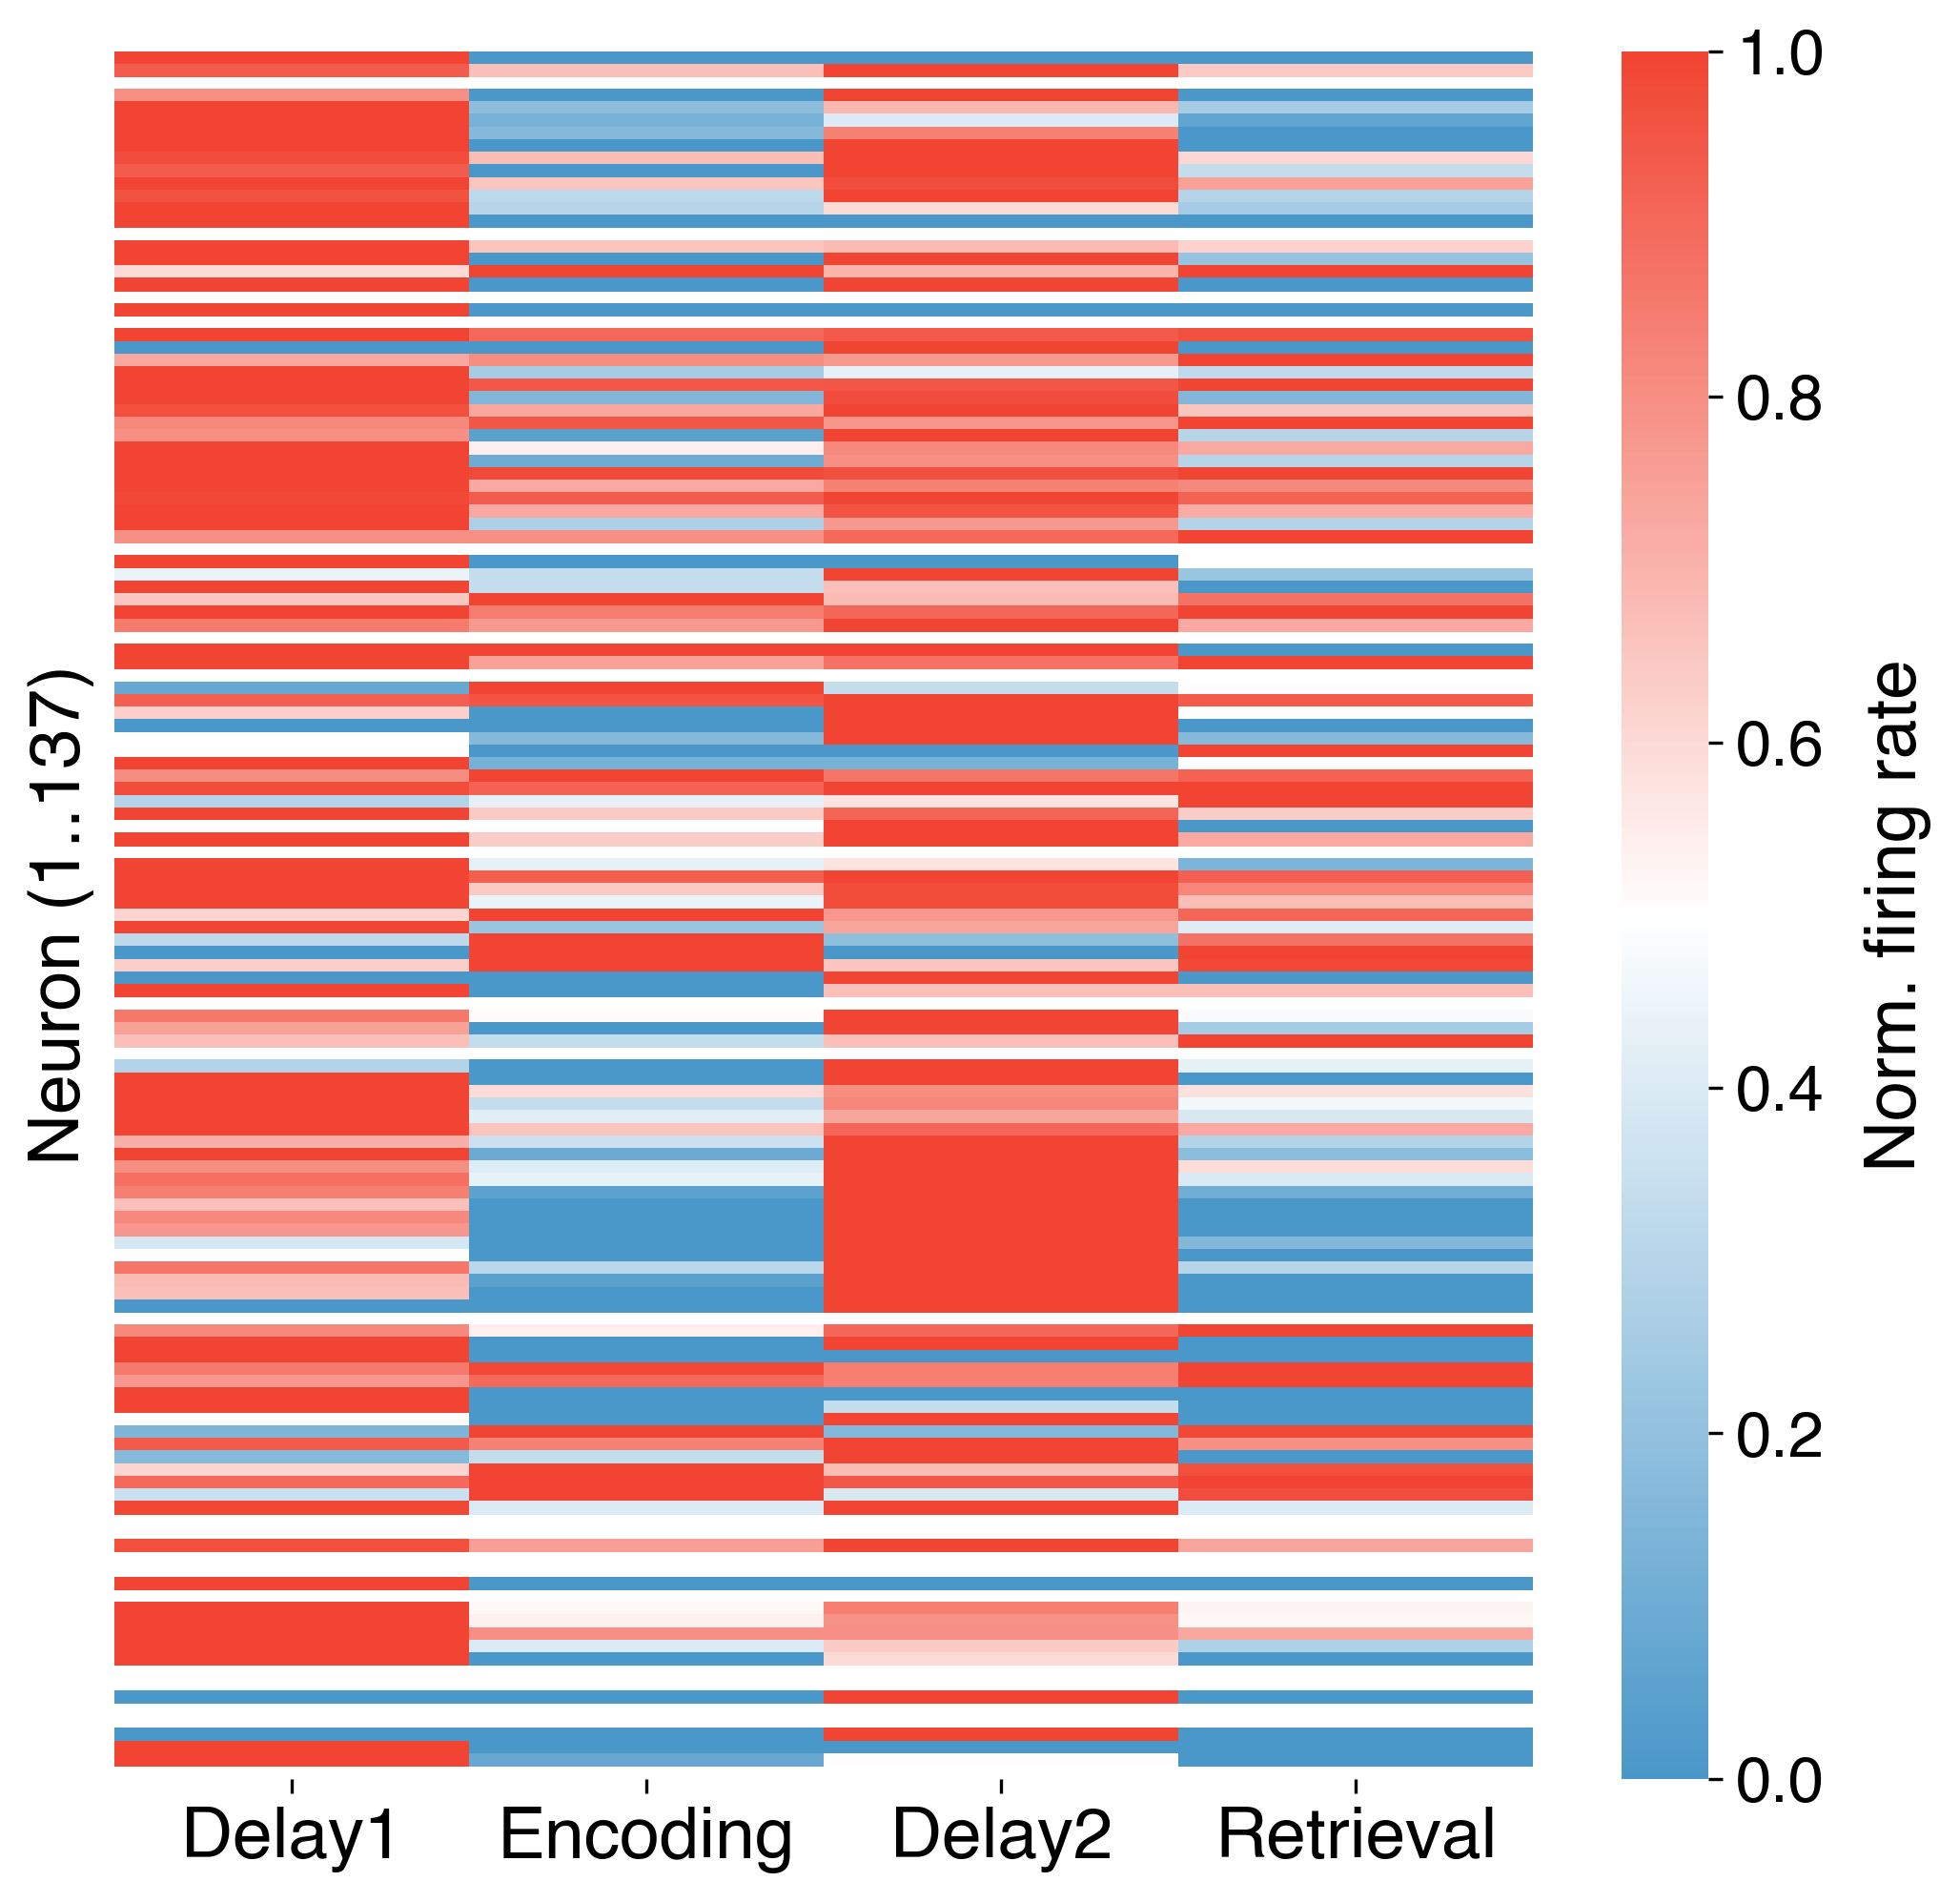

In [168]:
# For each neuron, calculate the mean firing rate during each trial phase.
xtrial_fr = np.mean(trial_spikes, axis=1) # neuron x trial_phase

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_fr#[np.argsort(xtrial_fr.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, cmap=cmap, cbar=True, square=False, ax=ax[i])
ax[i].set_xticks(np.arange(len(trial_phases))+0.5)
ax[i].set_xticklabels(trial_phases, fontsize=labelfontsize, rotation=0)
ax[i].set_yticks([])
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_fr.shape[0]), fontsize=labelfontsize, labelpad=5)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

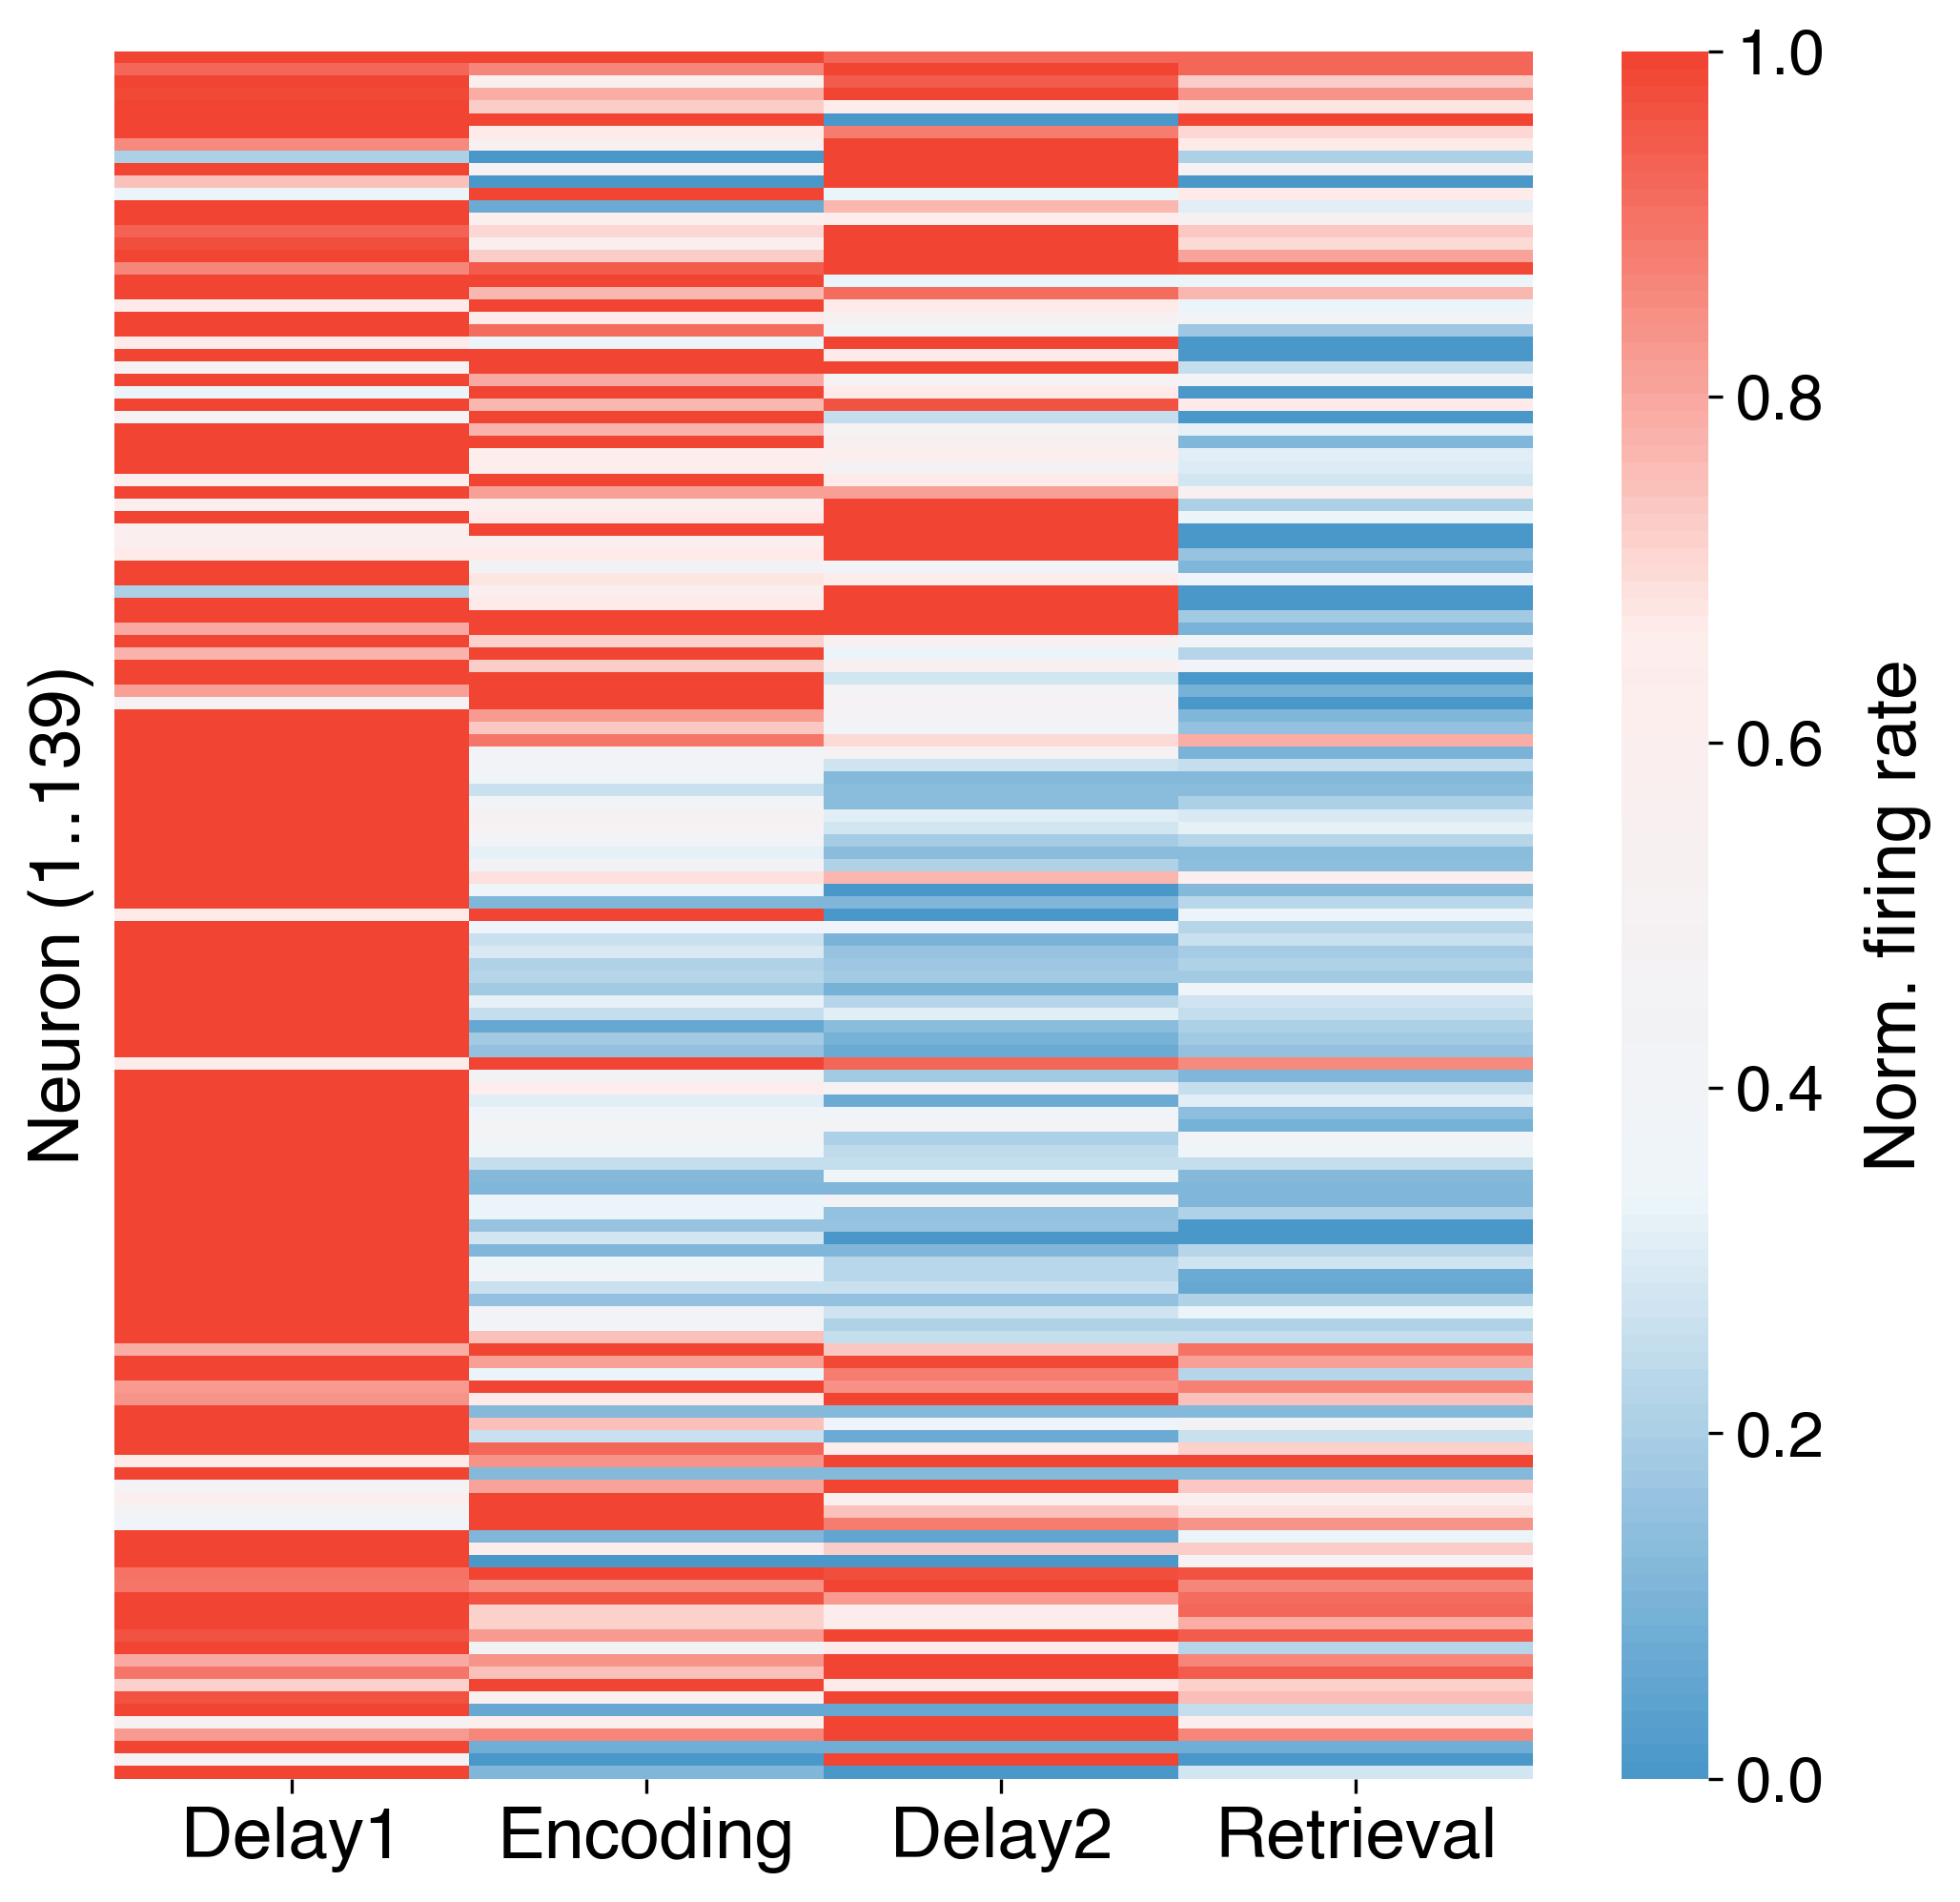

In [726]:
# For each neuron, calculate the mean firing rate during each trial phase.
xtrial_fr = np.mean(trial_spikes, axis=-1) # neuron x trial_phase

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_fr#[np.argsort(xtrial_fr.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

i = 0
ax[i] = sns.heatmap(dat, cmap=cmap, cbar=True, square=False, ax=ax[i])
ax[i].set_xticks(np.arange(len(trial_phases))+0.5)
ax[i].set_xticklabels(trial_phases, fontsize=labelfontsize, rotation=0)
ax[i].set_yticks([])
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_fr.shape[0]), fontsize=labelfontsize, labelpad=5)
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize)

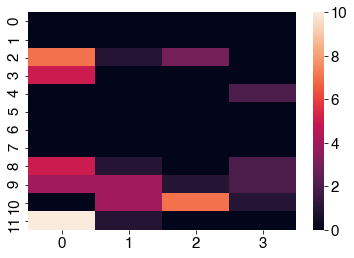

In [737]:
sns.heatmap(trial_spikes[70, :, :].T)

## Alignment plots

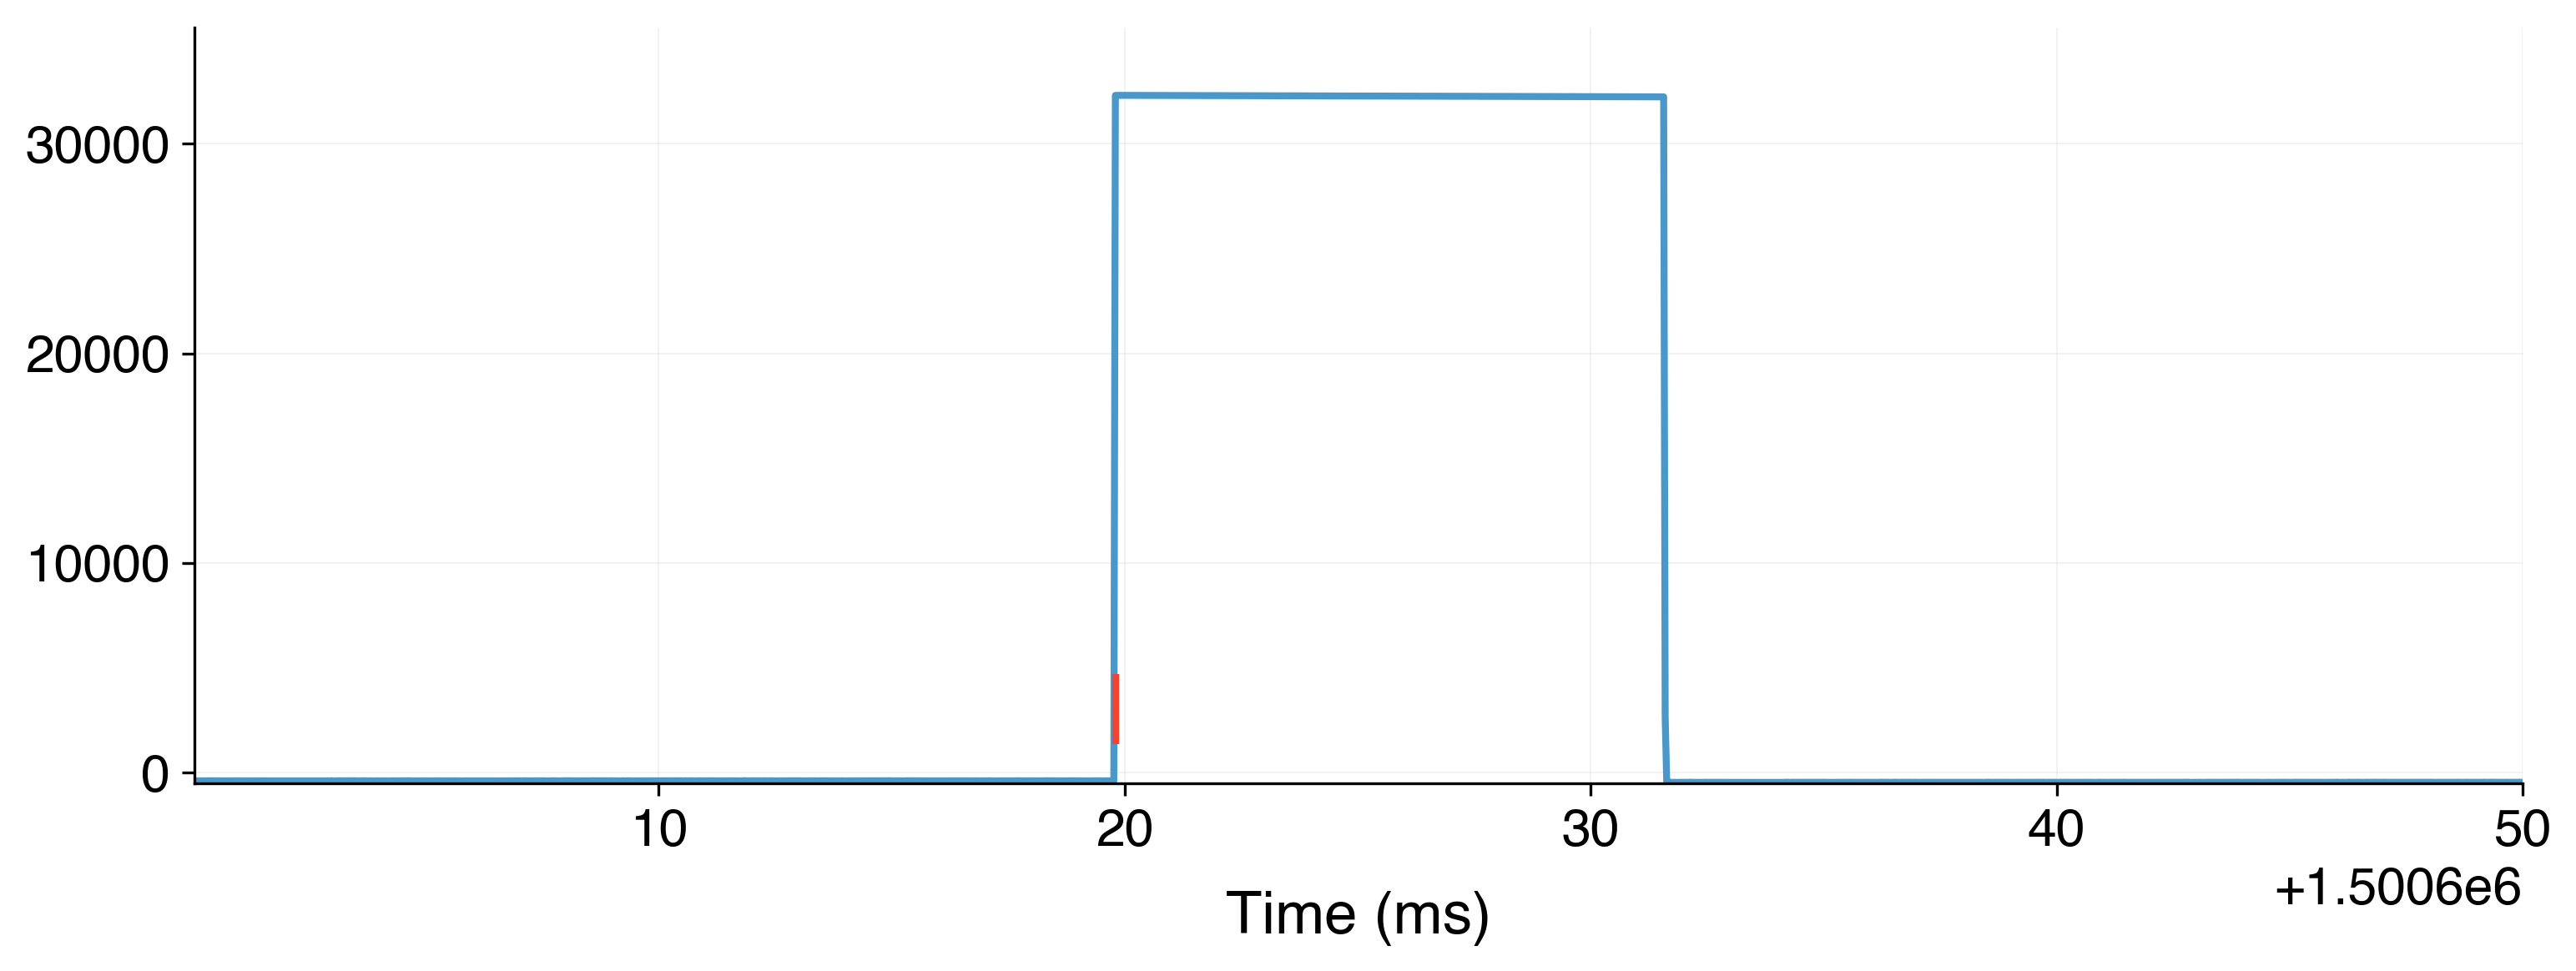

In [50]:
pulse_startinds = find_pulse_starts(sync_chan)
pulse_starts = np.zeros(len(sync_chan))
pulse_starts[pulse_startinds] = 3000

fig, ax = plot_trace(np.vstack((sync_chan, pulse_starts)),
                     start=1500.6*1e3, stop=1500.65*1e3, x_units='ms', sampling_rate=sr,
                     colors=[colors[0], colors[1]], linewidths=[2, 0], 
                     markers=[None, '|'], markeredgewidths=[0, 2])
fig.show()

In [33]:
lfp_timestamps, events['time'].values - events['time'].iloc[0]

(array([0.00000000e+00, 3.33333333e-02, 6.66666667e-02, ...,
        3.73978710e+06, 3.73978713e+06, 3.73978717e+06]),
 array([      0.        ,       0.        ,       0.        , ...,
        6624841.11293932, 6624857.11198567, 6625028.86175794]))

In [27]:
event_syncs = np.zeros(len(sync_chan))
event_syncs[event_synctimes] = 20000

IndexError: arrays used as indices must be of integer (or boolean) type

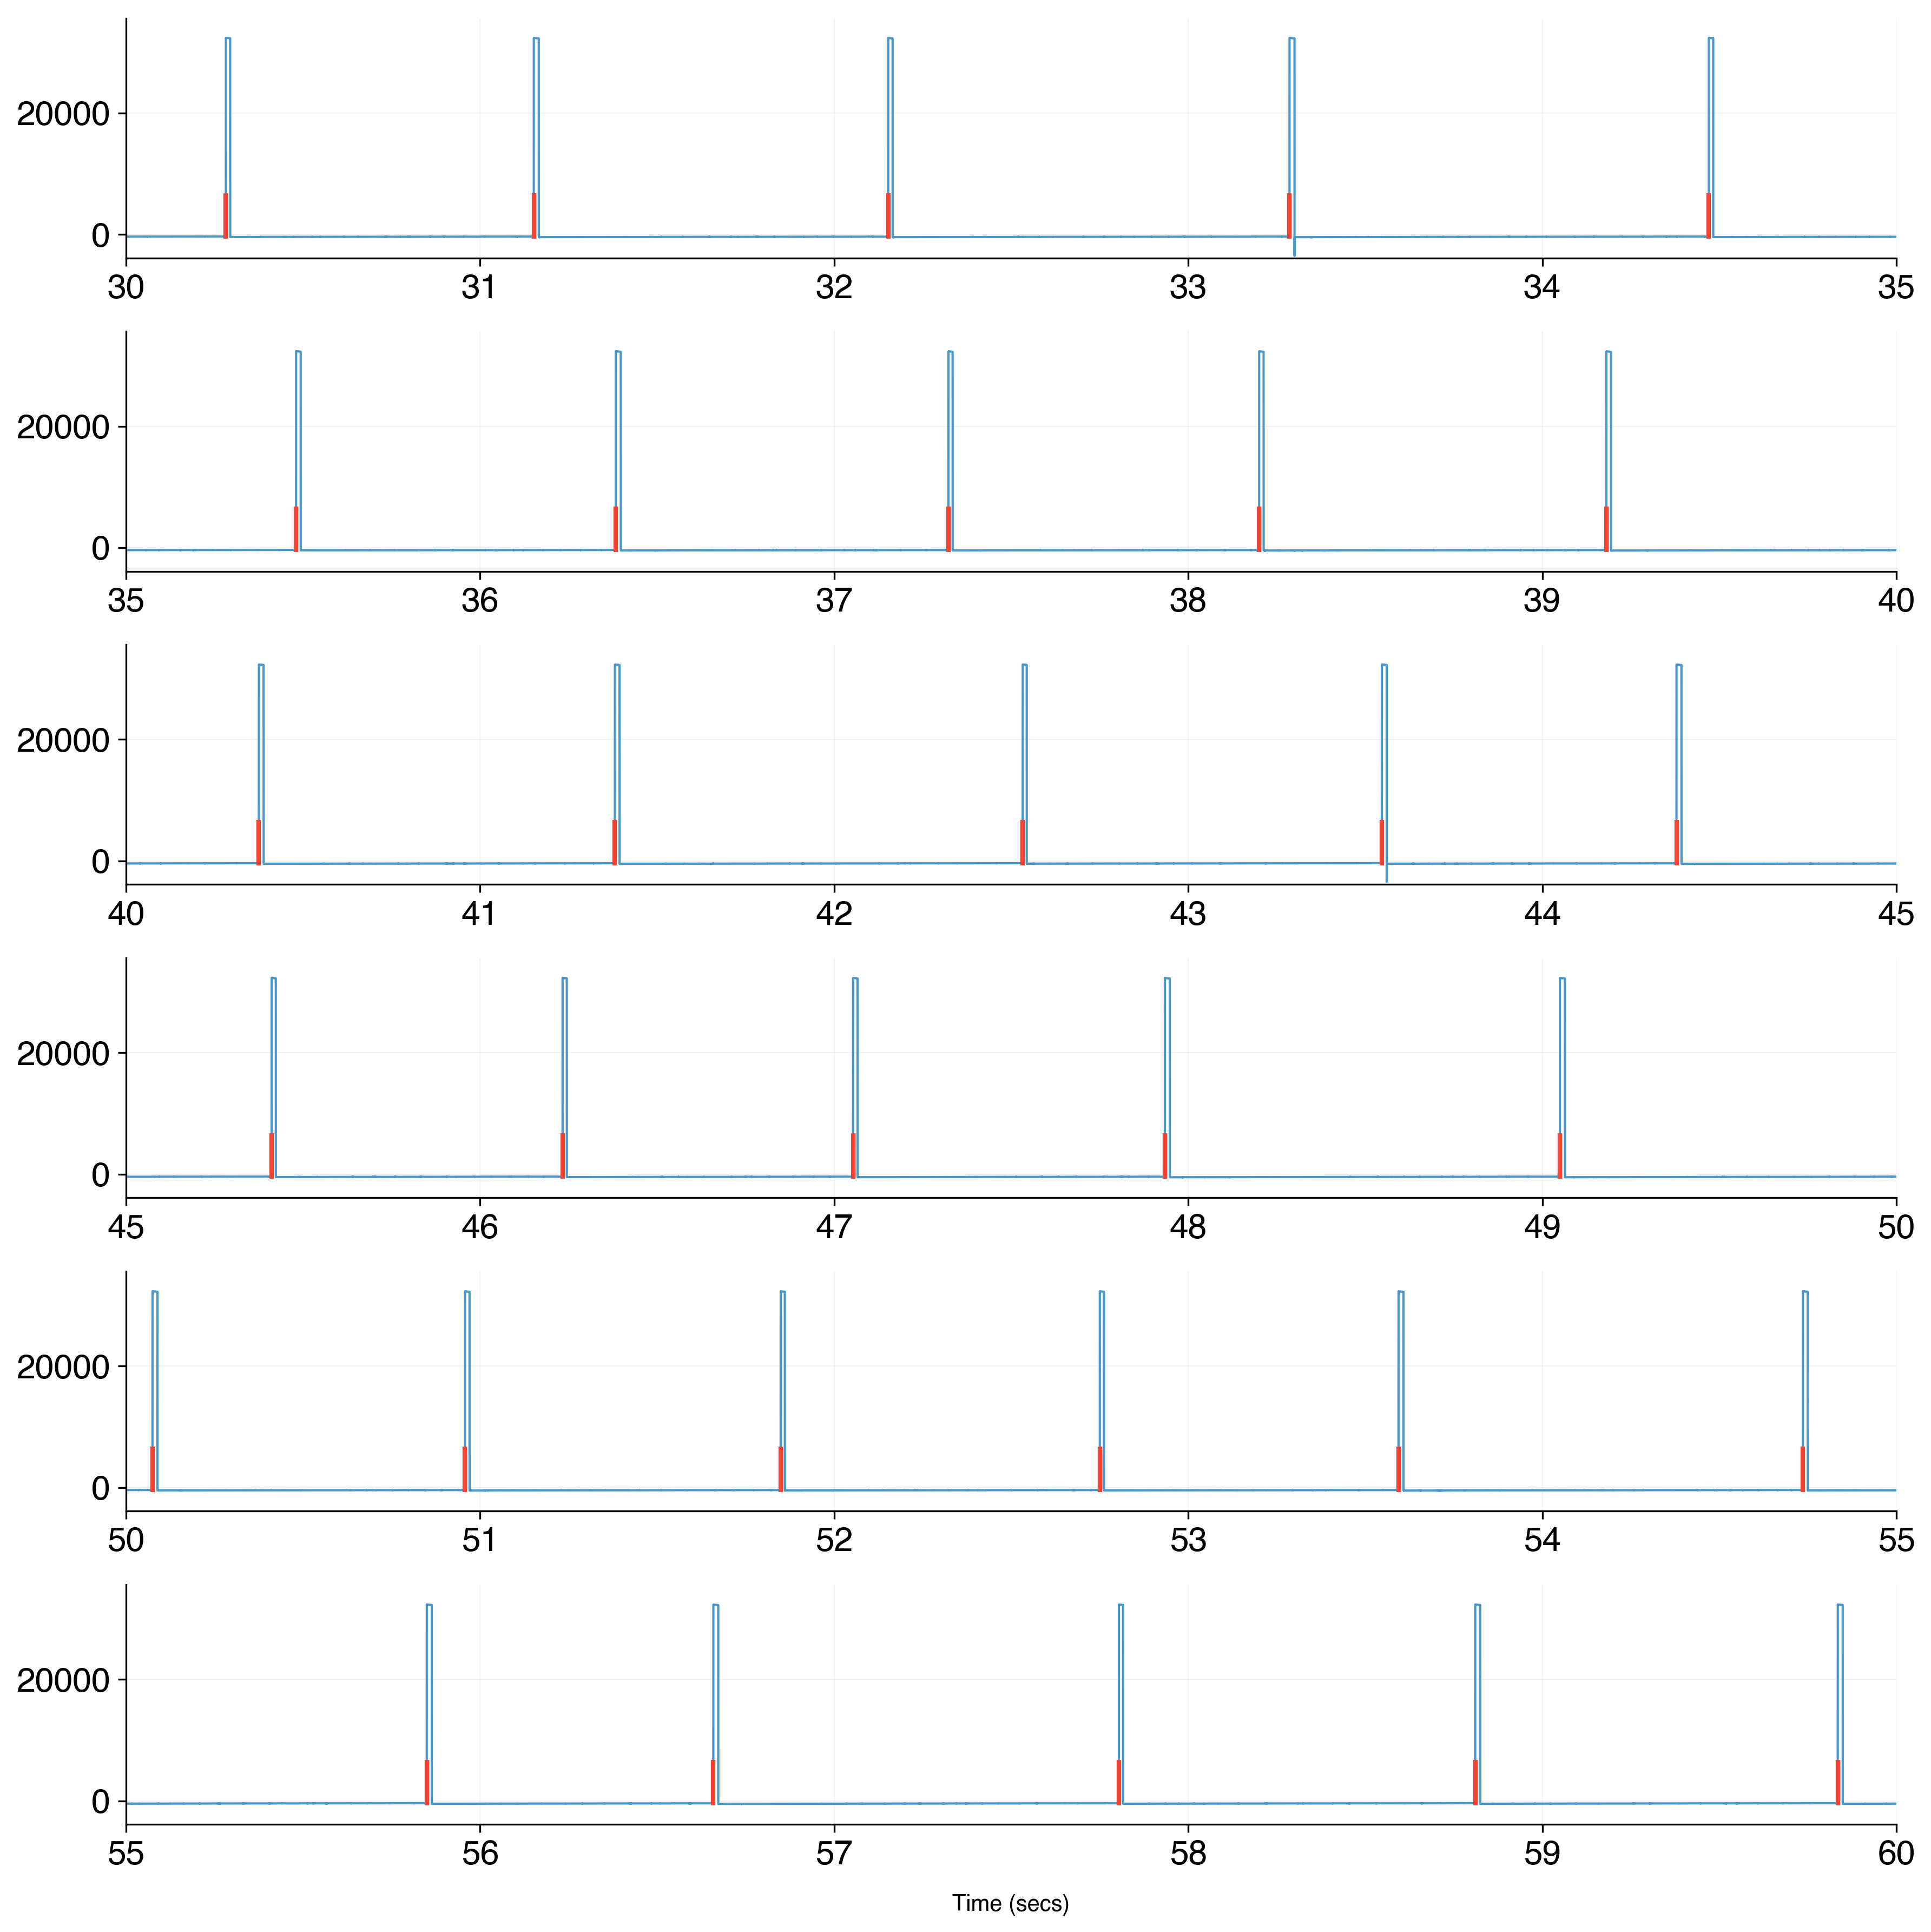

In [26]:
pulse_startinds = find_pulse_starts(sync_chan)
pulse_starts = np.zeros(len(sync_chan))
pulse_starts[pulse_startinds] = 3000
event_syncs = np.zeros(len(sync_chan))
event_syncs

fig, ax = plot_trace2(np.vstack((sync_chan, pulse_starts)), figsize=(12, 12),
                      start=30, stop=60, x_units='secs', sampling_rate=sr,
                      colors=[colors[0], colors[1]], linewidths=[1, 0], 
                      markers=[None, '|'], markeredgewidths=[0, 2])
fig.show()

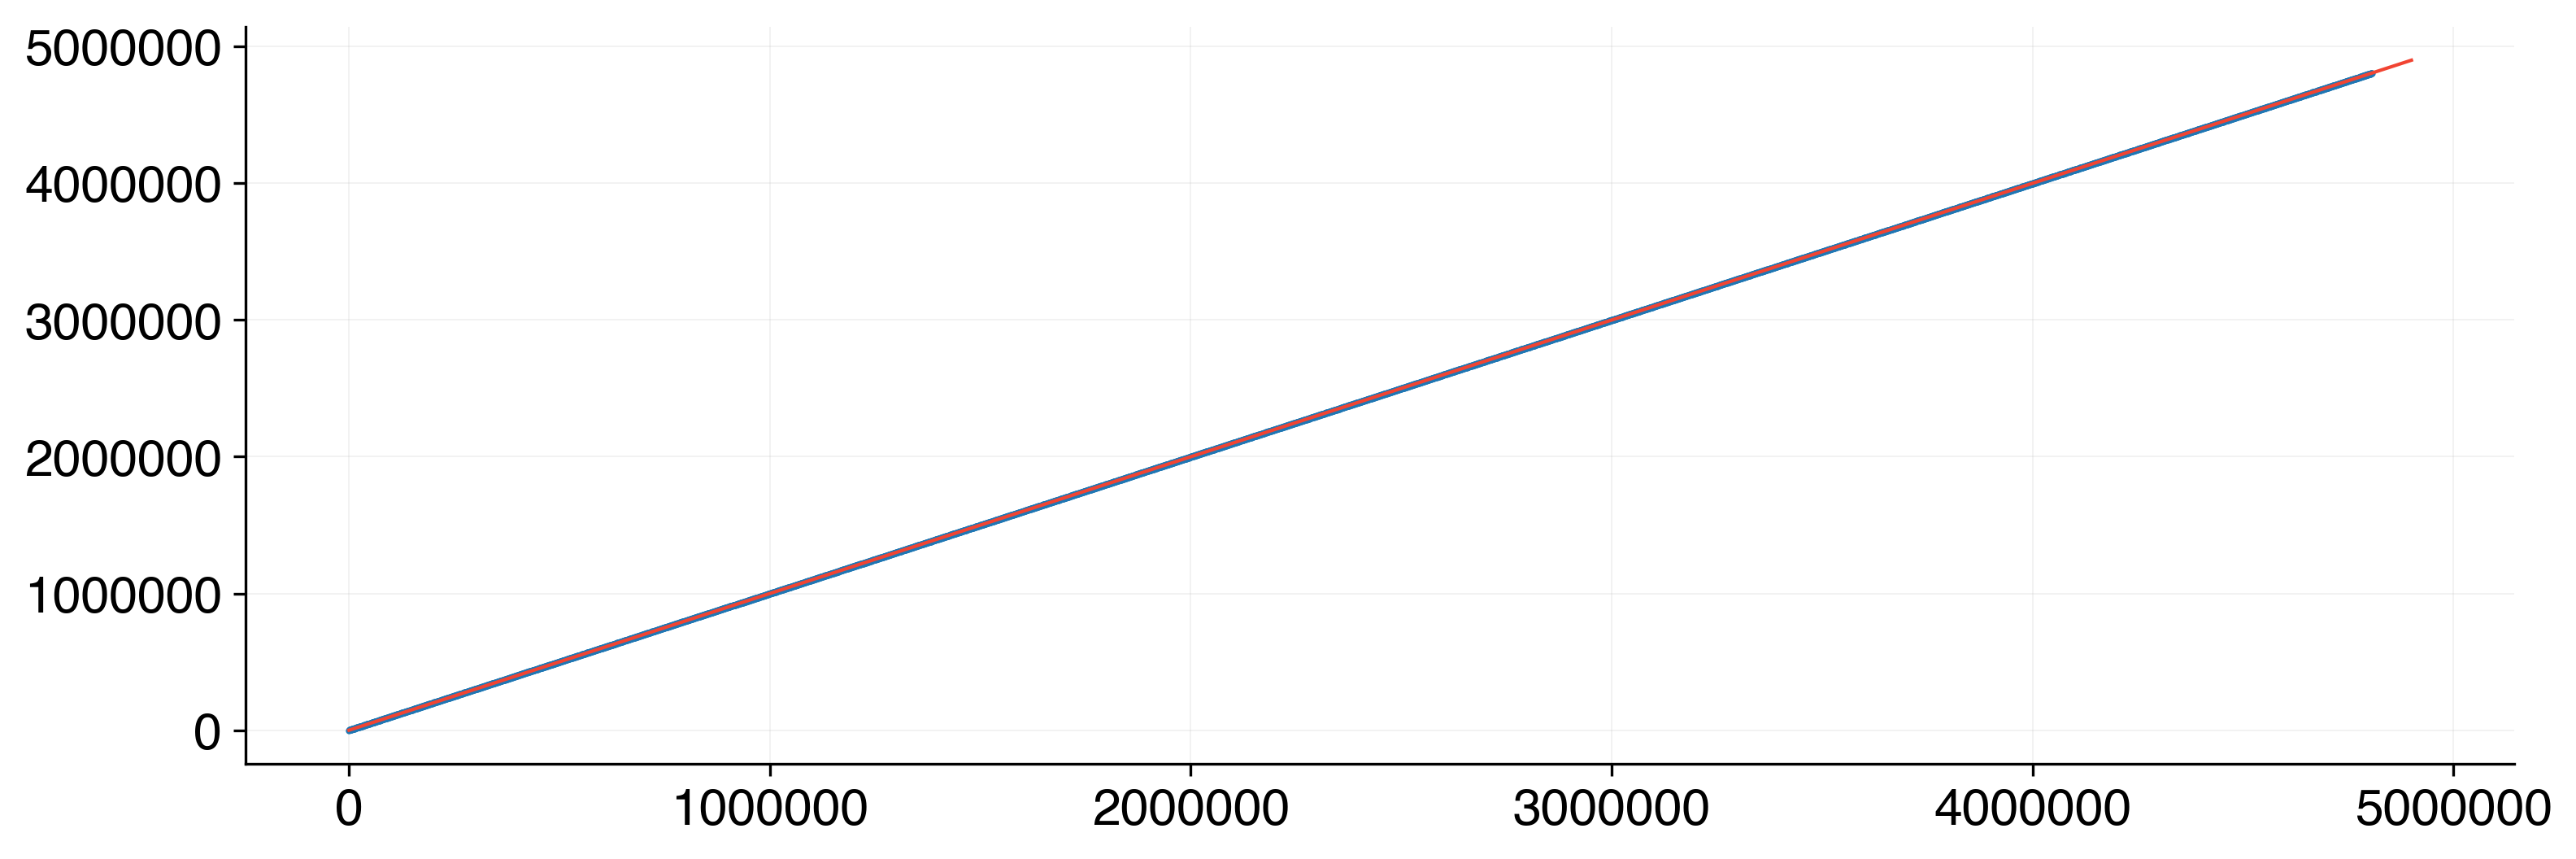

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=300)
ax.scatter(lfp_synctimes - lfp_synctimes[0], event_synctimes - event_synctimes[0], s=1)
ax.plot(np.arange(0, max(lfp_synctimes - lfp_synctimes[0])+1e5, 1e5), np.arange(0, max(lfp_synctimes - lfp_synctimes[0])+1e5, 1e5), 
        color=colors[1], linewidth=1)

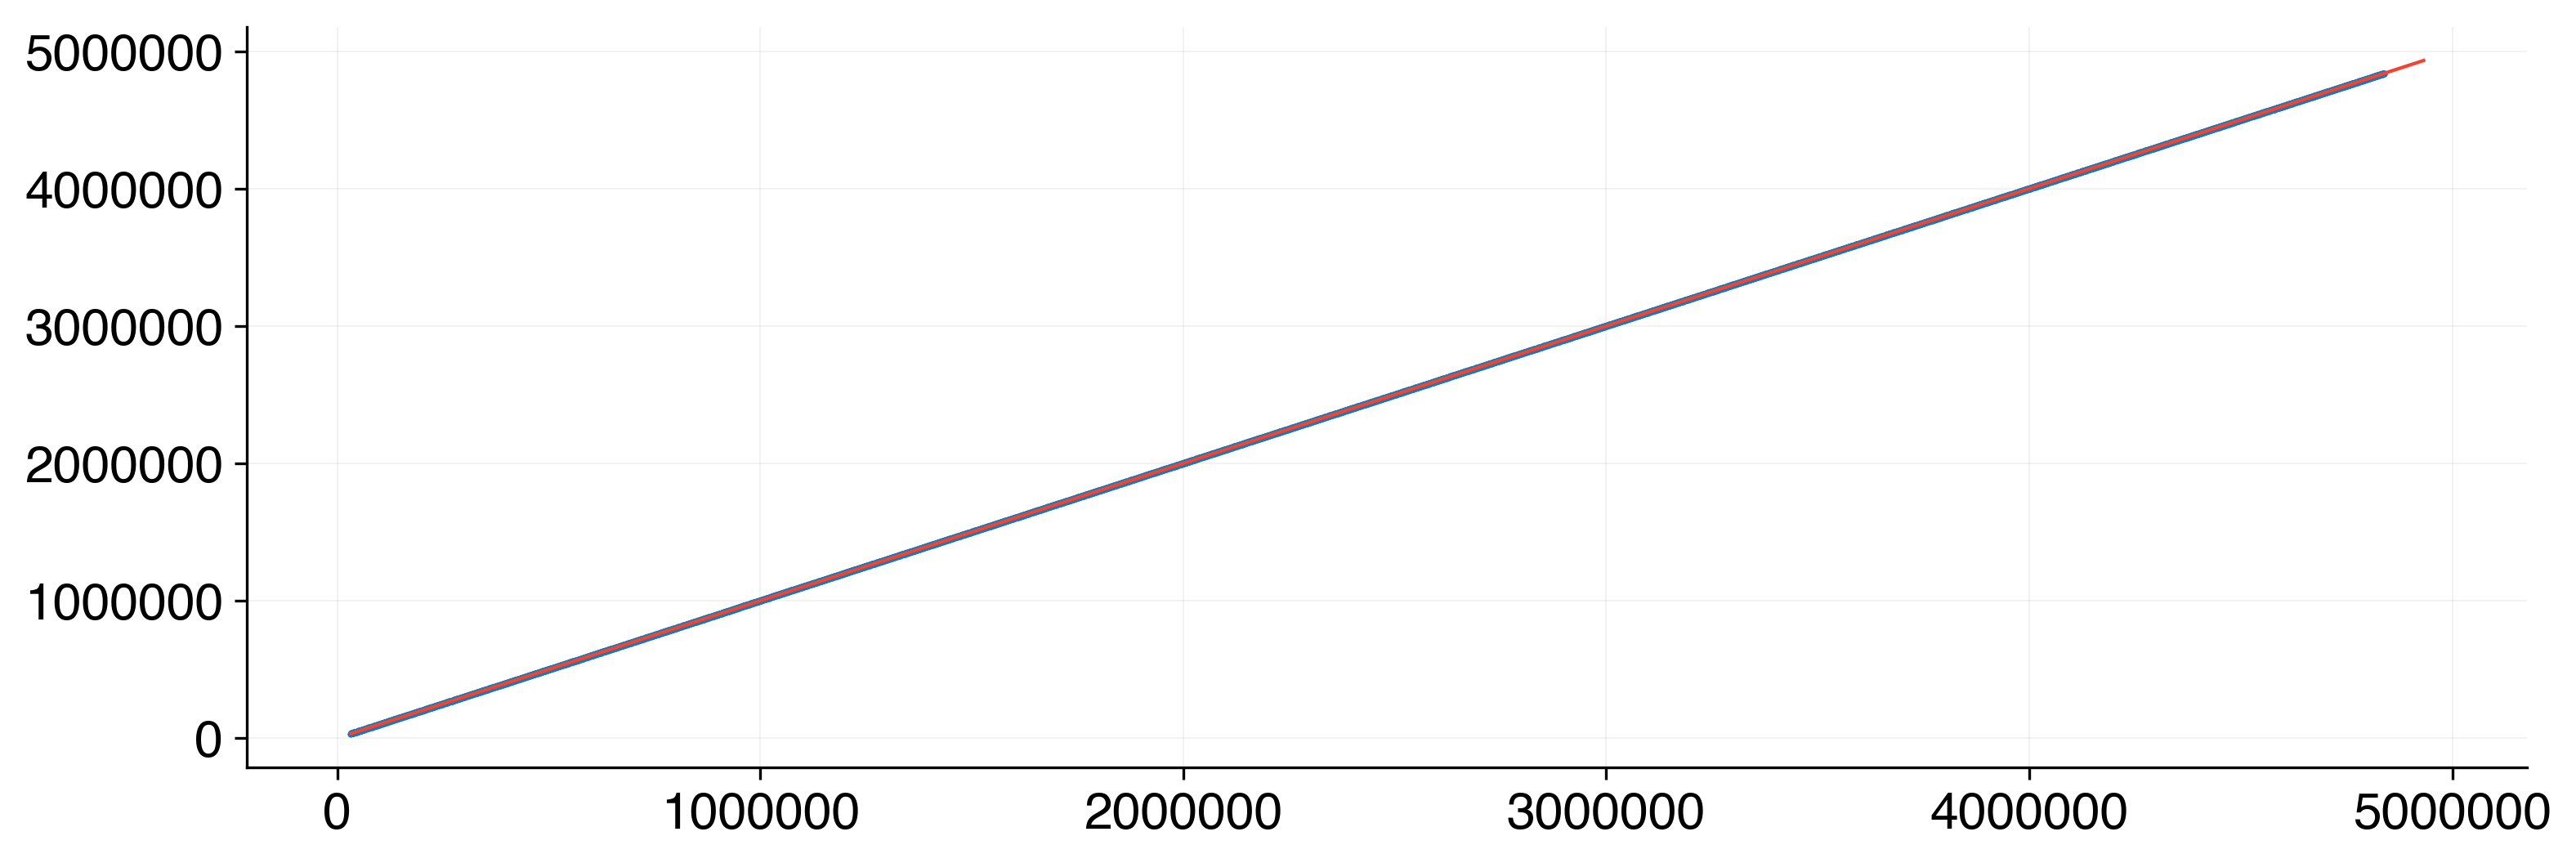

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=300)
ax.scatter(events.loc[events.key=='syncPulse', 'time'].values, lfp_synctimes, s=1)
ax.plot(np.arange(np.min(lfp_synctimes), np.max(lfp_synctimes)+1e5, 1e5), np.arange(np.min(lfp_synctimes), np.max(lfp_synctimes)+1e5, 1e5), 
        color=colors[1], linewidth=1)

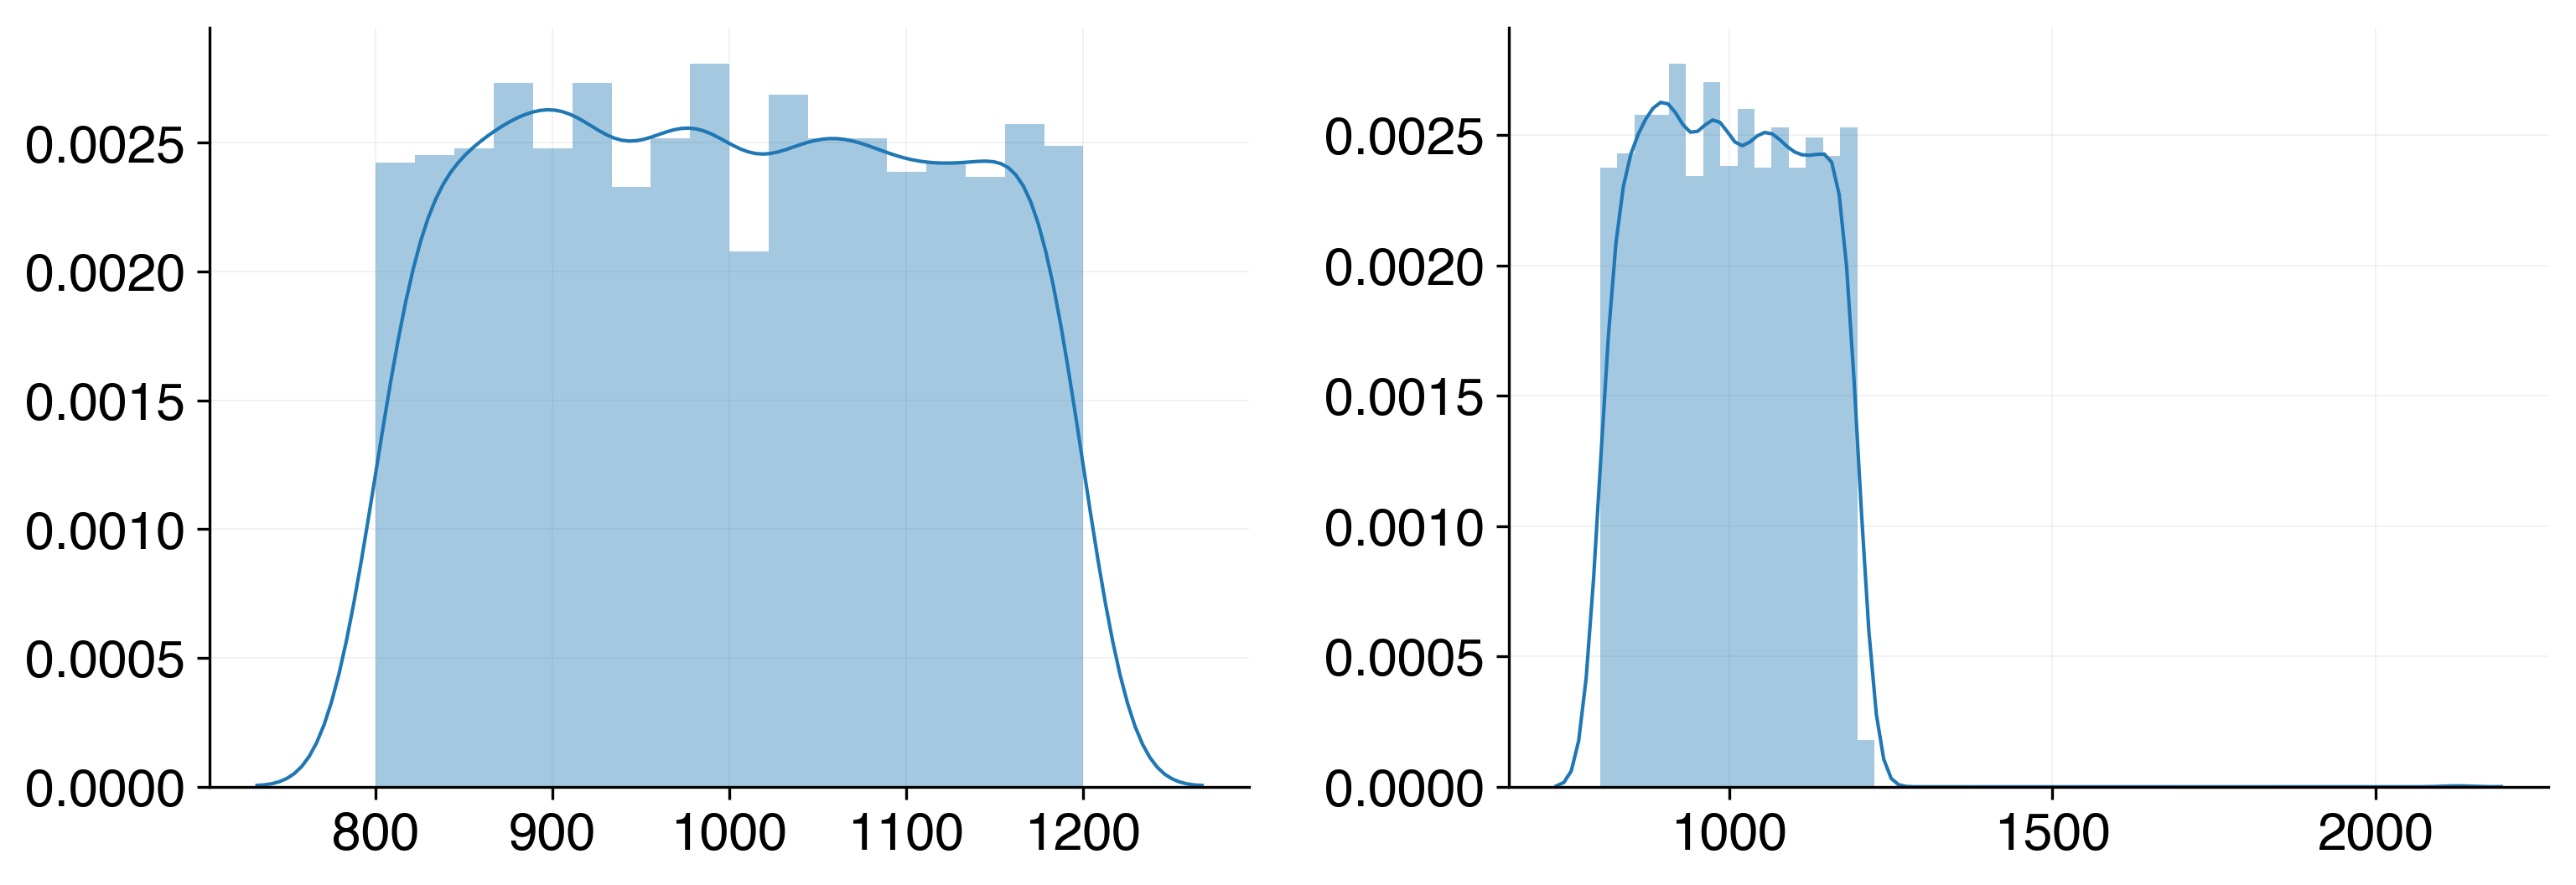

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i] = sns.distplot(np.diff(event_synctimes - event_synctimes[0]), ax=ax[i])

i = 1
ax[i] = sns.distplot(np.diff(lfp_synctimes - lfp_synctimes[0]), ax=ax[i])